# Развитие методов классификации и оценки значимости признаков на основе случайных лесов в контексте задачи картографирования земного покрова России

In [1]:
%matplotlib inline

import numpy as np
# import pandas as pd
import vaex
import matplotlib.pyplot as plt

# SEED = 42
vaex.multithreading.thread_count_default = 8

## Анализ данных


In [63]:
%%time

data_vaex = vaex.from_csv("data/lc_sample.csv", sep=";", convert=True, copy_index=False, chunk_size=5_000_000)
train_data_vaex = vaex.from_csv('data/lc_sample_train.csv', sep=';', convert=True, copy_index=False, chunk_size=5_000_000)

CPU times: total: 109 ms
Wall time: 1.45 s


### Общие сведения о данных


In [3]:
data_vaex.column_names

['CLASS',
 'X',
 'Y',
 'WINTER1',
 'WINTER2',
 'SPRING1',
 'SPRING2',
 'SPRING3',
 'SUMMER1',
 'SUMMER2',
 'SUMMER3',
 'FALL1',
 'FALL2',
 'FALL3']

In [4]:
len(data_vaex.column_names)

14

In [5]:
%%time

data_vaex.describe()

CPU times: total: 2min 13s
Wall time: 4min 55s


CLASS                  X                   Y  \
data_type              int64              int64               int64   
count               74029669           74029669            74029669   
NA                         0                  0                   0   
mean       7.611119766049474  24376.72315124089  12002.401741320768   
std                 6.342813        8210.278115          3491.21563   
min                        1               5820                1429   
max                       23              40161               20580   

                     WINTER1            WINTER2            SPRING1  \
data_type              int64              int64              int64   
count               74029669           74029669           74028645   
NA                         0                  0               1024   
mean       4548.318077161739  4731.401958476945  548.9908921472222   
std              2416.994088        2041.213183         222.399708   
min                        0                  0                  1   
max                    10583              10584               8653   

                     SPRING2            SPRING3            SUMMER1  \
data_type              int64              int64              int64   
count               74029669           74029669           74029669   
NA                         0                  0                  0   
mean       2052.998122860714  1848.420739284948  421.4262774834236   
std                591.31415         544.045962         251.964254   
min                        1                  1                  1   
max                     7018               5211               8653   

                     SUMMER2            SUMMER3              FALL1  \
data_type              int64              int64              int64   
count               74029669           74029669           74029669   
NA                         0                  0                  0   
mean       2556.332150843468  1787.649052544055  512.4376927580211   
std               701.879185         547.615536         253.744844   
min                        1                  1                  1   
max                     6907               4923               8653   

                       FALL2               FALL3  
data_type              int64               int64  
count               74029669            74029669  
NA                         0                   0  
mean       2131.846159666066  1697.7642905846303  
std                548.47765          582.313616  
min                        1                   1  
max                     6907                5280

### Классифицируемые типы земного покрова


#### Типы земного покрова и их представленность в выборке

In [6]:
def parse_classes(legend_filename: str) -> dict:
    """Parsing classes legend from text file.

    Parameters
    ----------
    legend_filename : string
        Input textfile name.

    Returns
    -------
    classes : dict
        Classes legend.
    """
    classes = {}
    with open(legend_filename, mode="rt", encoding="utf-8") as f:
        for line in f:
            key, value = line.rstrip().split(". ")
            classes[int(key)] = value
    return classes

In [7]:
%%time

classes_legend = parse_classes("data/33class_legend_rus.txt")

classes = data_vaex.CLASS.unique()
classes.sort()

classes_legend = { key: classes_legend[key] for key in classes }

classes_legend

CPU times: total: 7.91 s
Wall time: 20.5 s


{1: 'Темнохвойный лес',
 2: 'Светлохвойный лес',
 3: 'Лиственный лес',
 4: 'Хвойный листопадный лес',
 5: 'Хвойный кустарник',
 6: 'Болота',
 7: 'Болота',
 8: 'Луга',
 9: 'Лиственный кустарник',
 10: 'Смешанный лес с преобладанием хвойных',
 11: 'Смешанный лес',
 12: 'Смешанный лес с преобладанием лиственных',
 13: 'Открытые грунты и выходы горных пород',
 14: 'Степь',
 15: 'Прибрежная растительность',
 16: 'Кустарниковая тундра',
 17: 'Травянистая тундра',
 18: 'Кустарничковая тундра',
 19: 'Открытые грунты и выходы горных пород',
 20: 'Водные объекты',
 21: 'Болота',
 22: 'Болота',
 23: 'Редины хвойные листопадные'}

In [8]:
%%time

classes_names = [
    "Темнохвойный лес",
    "Светлохвойный лес",
    "Лиственный лес",
    "Смешанный лес с преобладанием хвойных",
    "Смешанный лес",
    "Смешанный лес с преобладанием лиственных",
    "Хвойный листопадный лес",
    "Редины хвойные листопадные",
    "Луга",
    "Степь",
    "Хвойный кустарник",
    "Лиственный кустарник",
    "Кустарничковая тундра",
    "Травянистая тундра",
    "Кустарниковая тундра",
    "Болота",
    "Прибрежная растительность",
    "Открытые грунты и выходы горных пород",
    "Водные объекты"
]

colors_legend = {
    "Темнохвойный лес": (0.47, 0.2, 0.57),
    "Светлохвойный лес": (0.96, 0.73, 0.1),
    "Лиственный лес": (0.3, 0.97, 0.5),
    "Смешанный лес с преобладанием хвойных": (0.12, 0.3, 0.11),
    "Смешанный лес": (0, 0.5, 0.1),
    "Смешанный лес с преобладанием лиственных": (0, 0.75, 0),
    "Хвойный листопадный лес": (0.64, 0.31, 0.16),
    "Редины хвойные листопадные": (0.76, 0.57, 0.4),
    "Луга": (1, 0.75, 0.79),
    "Степь": (0.95, 0.94, 0.72),
    "Хвойный кустарник": (1, 0, 1),
    "Лиственный кустарник": (0.36, 0.8, 0.58),
    "Кустарничковая тундра": (0, 0.98, 1),
    "Травянистая тундра": (0.15, 0.82, 0.93),
    "Кустарниковая тундра": (0.23, 0.17, 0.88),
    "Болота": (0.68, 0.65, 0.32),
    "Прибрежная растительность": (0.65, 1, 0),
    "Открытые грунты и выходы горных пород": (0.75, 0.75, 0.75),
    "Водные объекты": (0.74, 0.89, 1)
}

unordered_classes_summary = {}
total = 0

for class_id in classes_legend:
    number = len(data_vaex[data_vaex["CLASS"] == class_id])
    total += number
    if classes_legend[class_id] in unordered_classes_summary:
        unordered_classes_summary[classes_legend[class_id]]["id"].append(class_id)
        unordered_classes_summary[classes_legend[class_id]]["number"] += number
    else:
        unordered_classes_summary[classes_legend[class_id]] = {"id": [class_id], "number": number, "color": colors_legend[classes_legend[class_id]]}

for class_name in unordered_classes_summary:
    unordered_classes_summary[class_name]["percent"] = unordered_classes_summary[class_name]["number"] * 100 / total

classes_summary = {}
for class_name in classes_names:
    classes_summary[class_name] = unordered_classes_summary[class_name]

classes_summary

CPU times: total: 10.3 s
Wall time: 4.81 s


{'Темнохвойный лес': {'id': [1],
  'number': 6153034,
  'color': (0.47, 0.2, 0.57),
  'percent': 8.311578429453737},
 'Светлохвойный лес': {'id': [2],
  'number': 4500884,
  'color': (0.96, 0.73, 0.1),
  'percent': 6.07983807140891},
 'Лиственный лес': {'id': [3],
  'number': 8734036,
  'color': (0.3, 0.97, 0.5),
  'percent': 11.798021142036985},
 'Смешанный лес с преобладанием хвойных': {'id': [10],
  'number': 1025492,
  'color': (0.12, 0.3, 0.11),
  'percent': 1.3852446105087948},
 'Смешанный лес': {'id': [11],
  'number': 378946,
  'color': (0, 0.5, 0.1),
  'percent': 0.5118839583086614},
 'Смешанный лес с преобладанием лиственных': {'id': [12],
  'number': 1505855,
  'color': (0, 0.75, 0),
  'percent': 2.034123643049113},
 'Хвойный листопадный лес': {'id': [4],
  'number': 22271771,
  'color': (0.64, 0.31, 0.16),
  'percent': 30.08492581535114},
 'Редины хвойные листопадные': {'id': [23],
  'number': 3586296,
  'color': (0.76, 0.57, 0.4),
  'percent': 4.844403667399891},
 'Луга': 

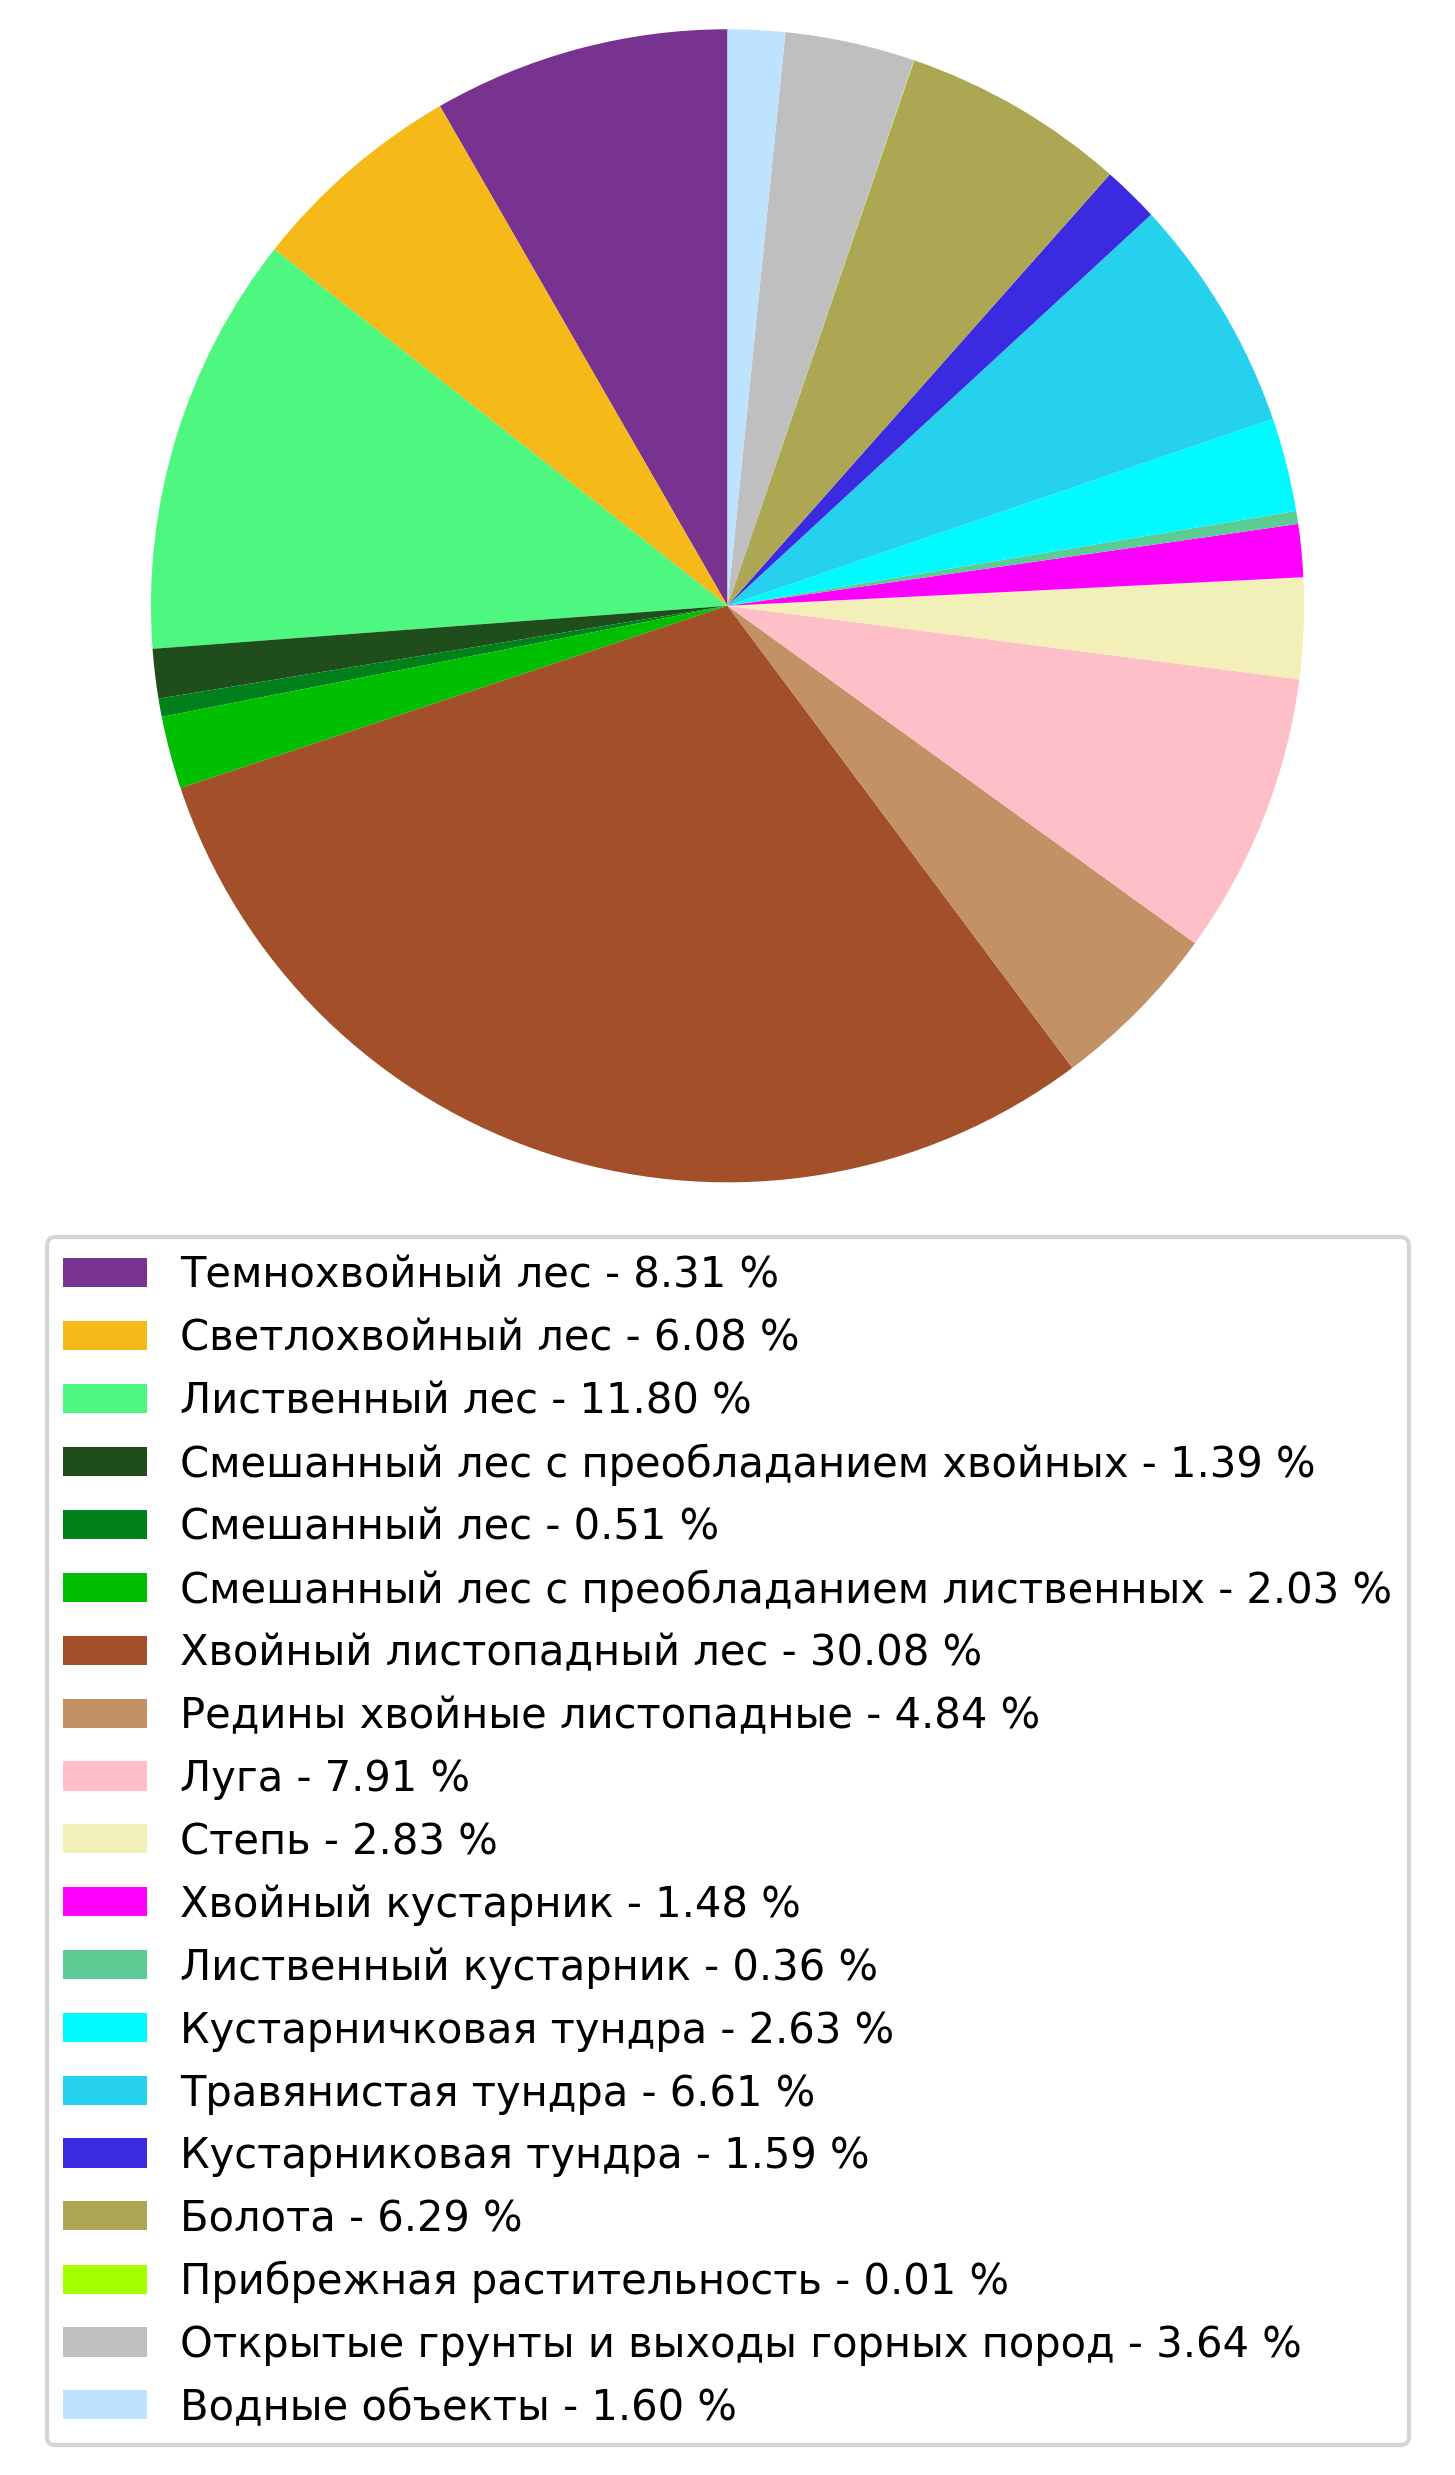

CPU times: total: 1.55 s
Wall time: 1.75 s


In [116]:
%%time

names = [class_name for class_name in classes_summary]
percents = [classes_summary[class_name]["percent"] for class_name in classes_summary]
colors = [classes_summary[class_name]["color"] for class_name in classes_summary]

labels = [f"{name} - {percent:1.2f} %" for name, percent in zip(names, percents)]

fig = plt.figure(figsize=(6, 10), dpi=300)
ax = fig.add_subplot(211)
ax.axis("equal")
pie = ax.pie(percents, colors=colors, startangle=90, radius=1.4)
legend_ax = fig.add_subplot(212)
legend_ax.axis("off")
legend_ax.legend(pie[0], labels, loc="center")

plt.savefig("text/images/classes-ratio.png", bbox_inches="tight", pad_inches=0)

plt.show()

#### Визуализация типов земного покрова

##### Ящики с усами

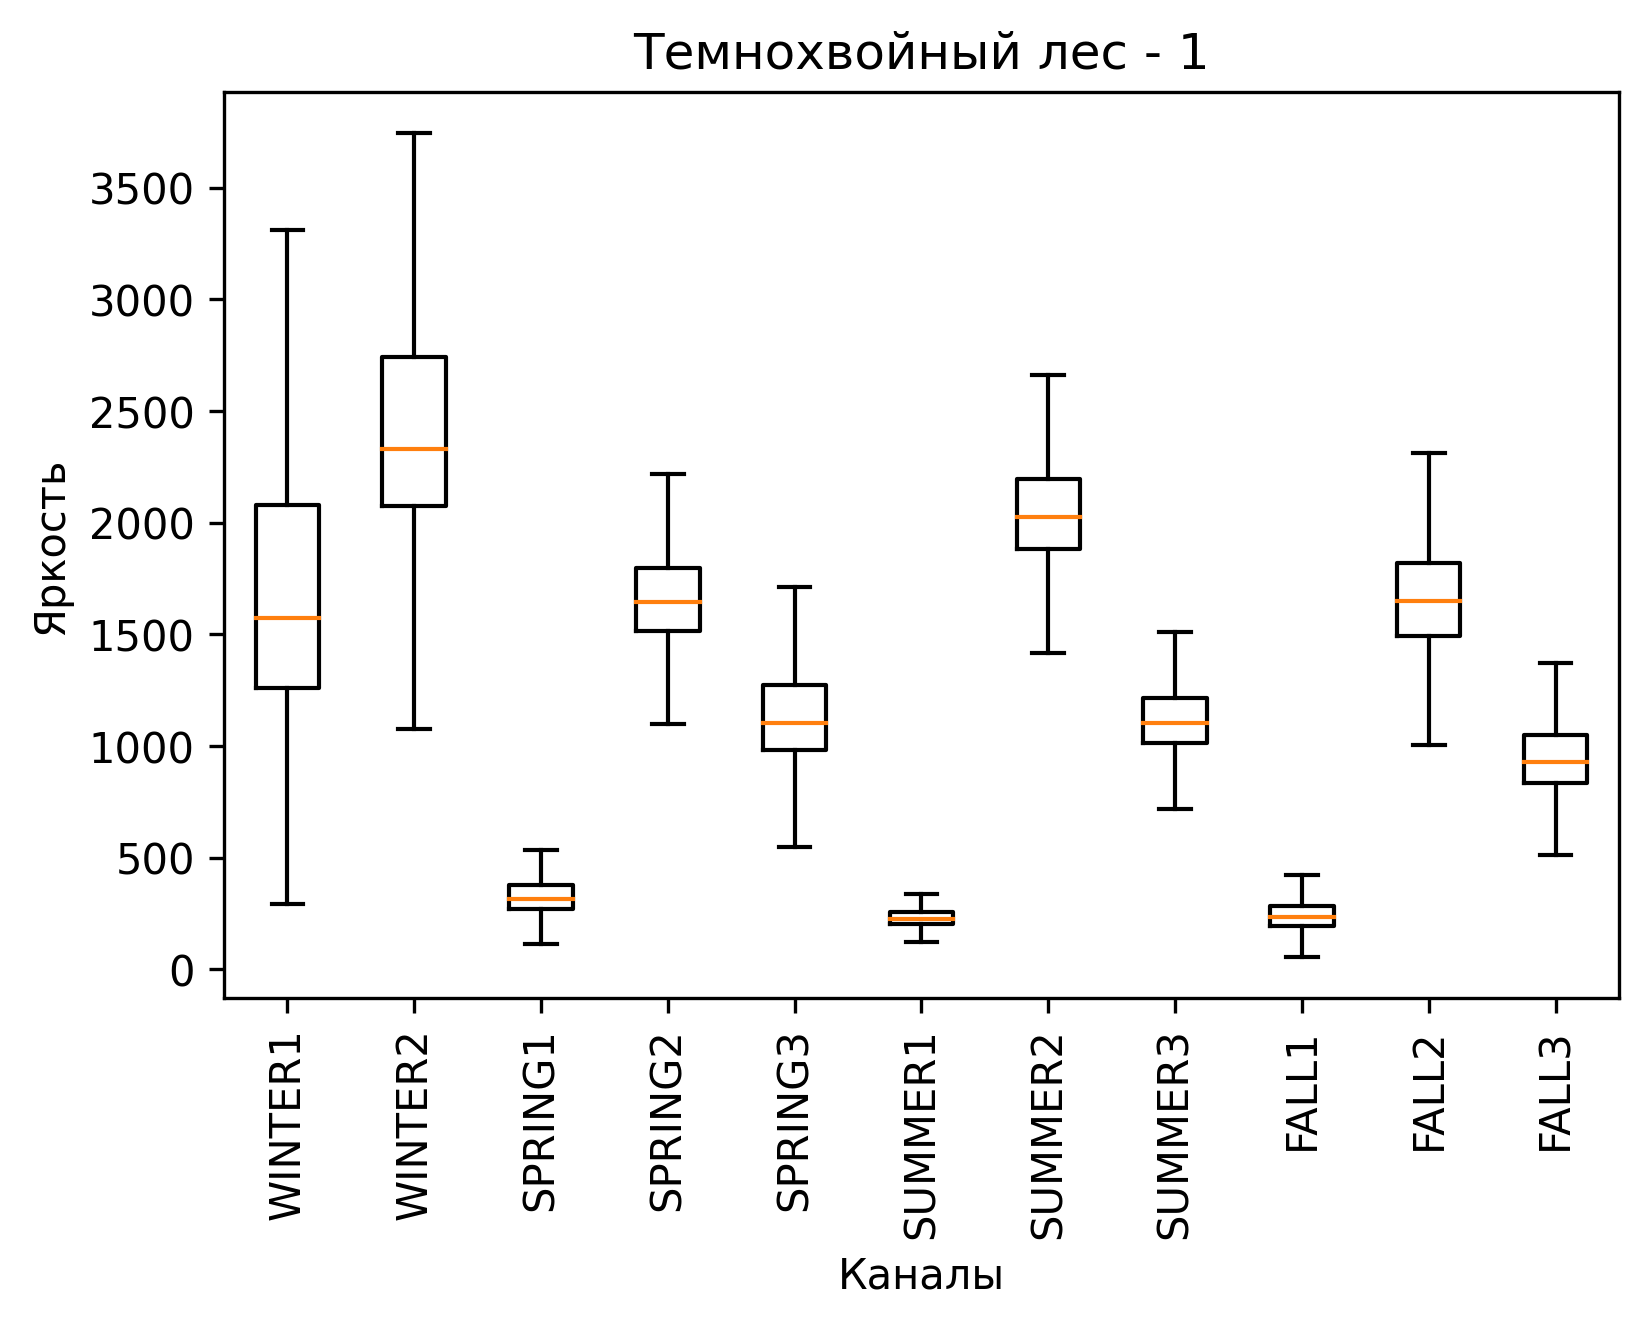

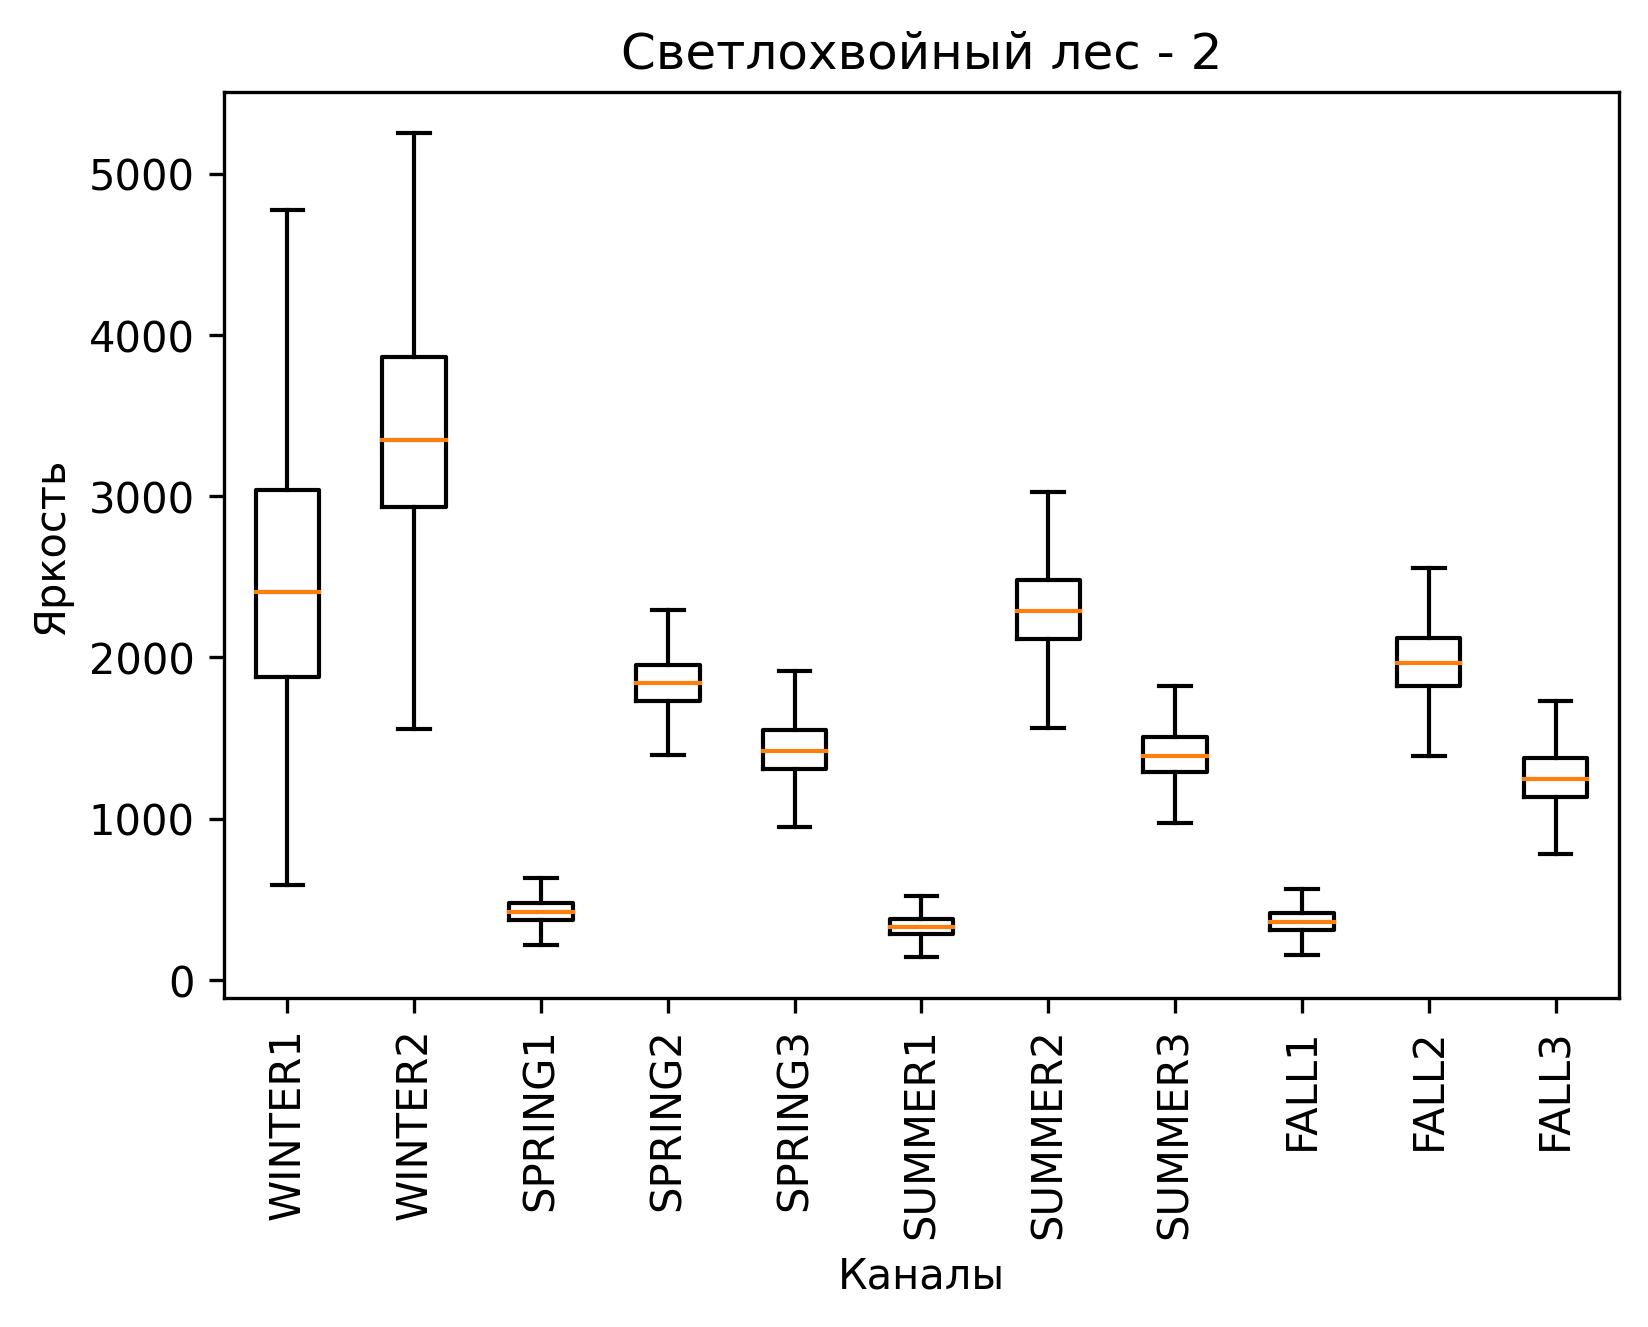

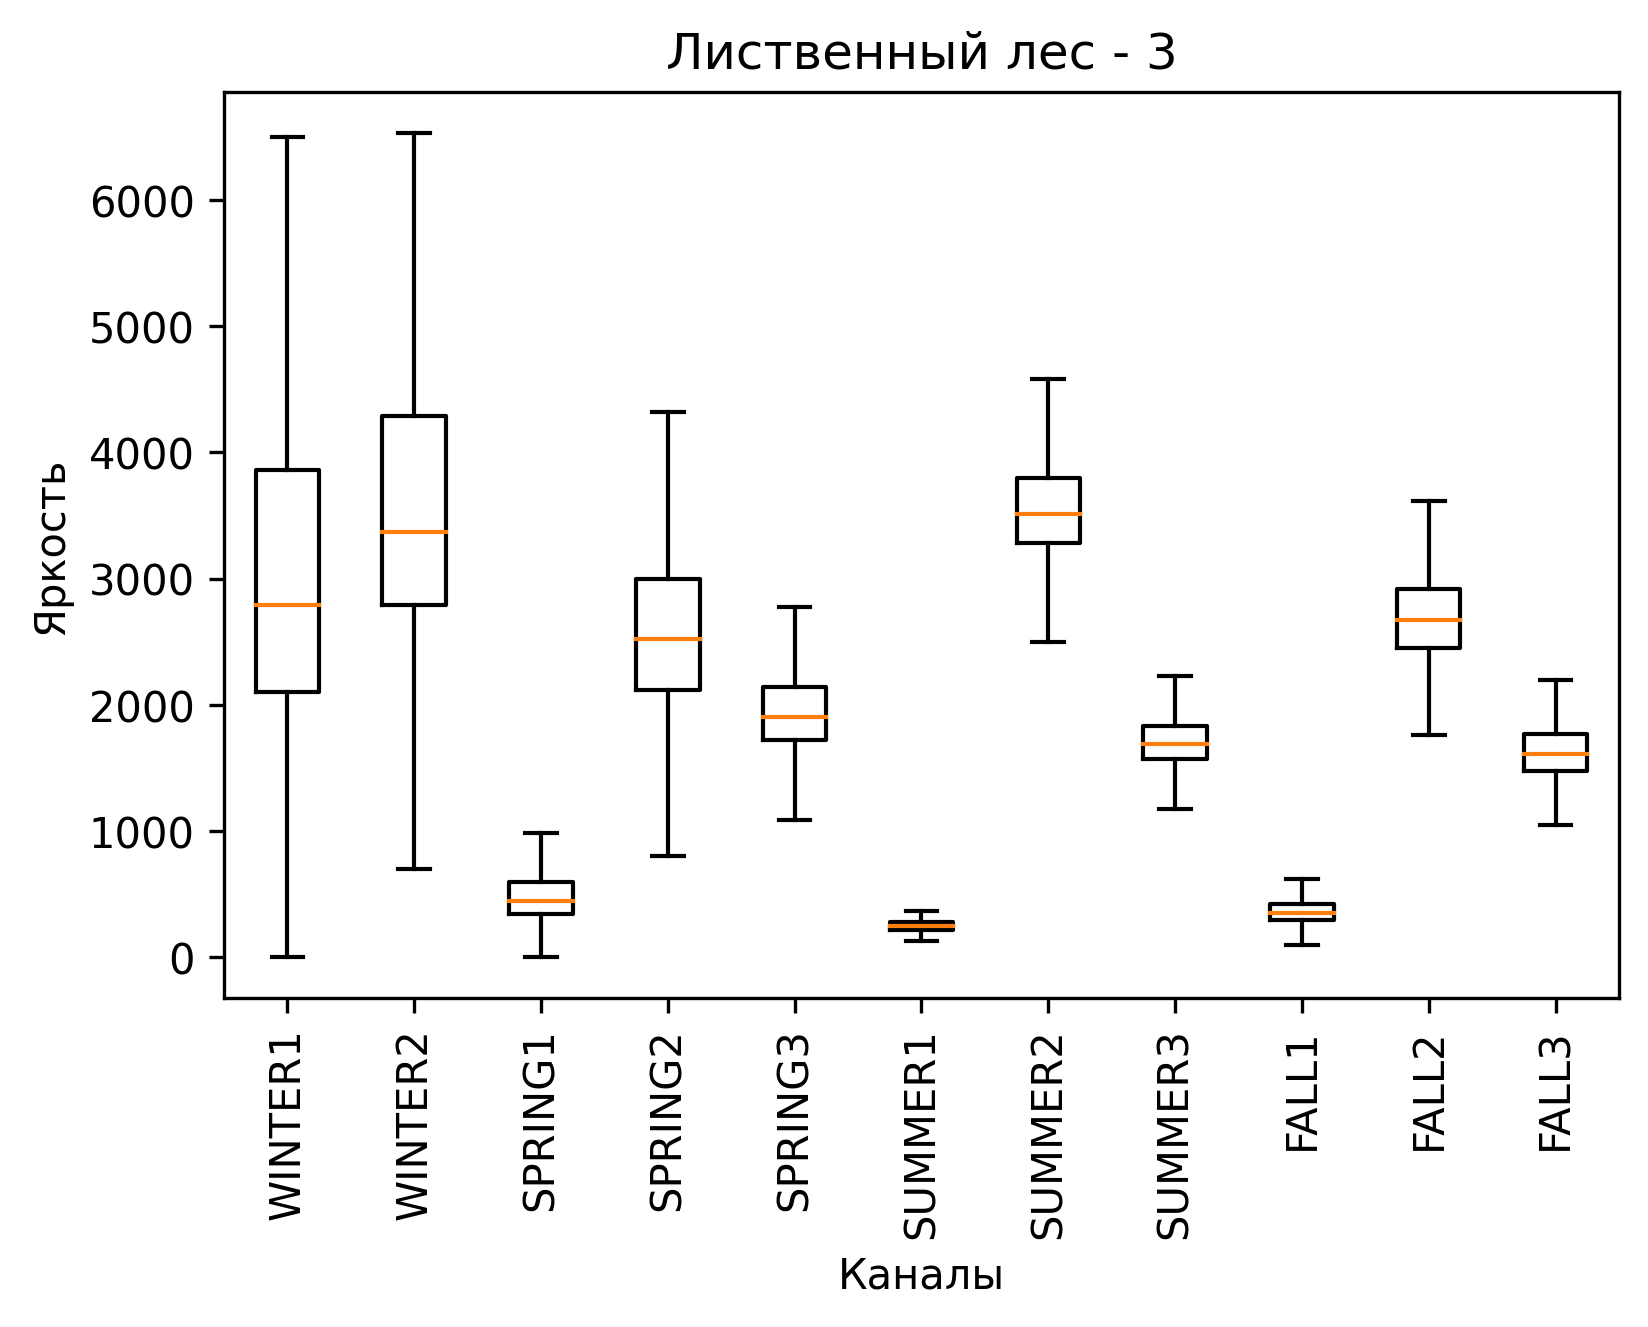

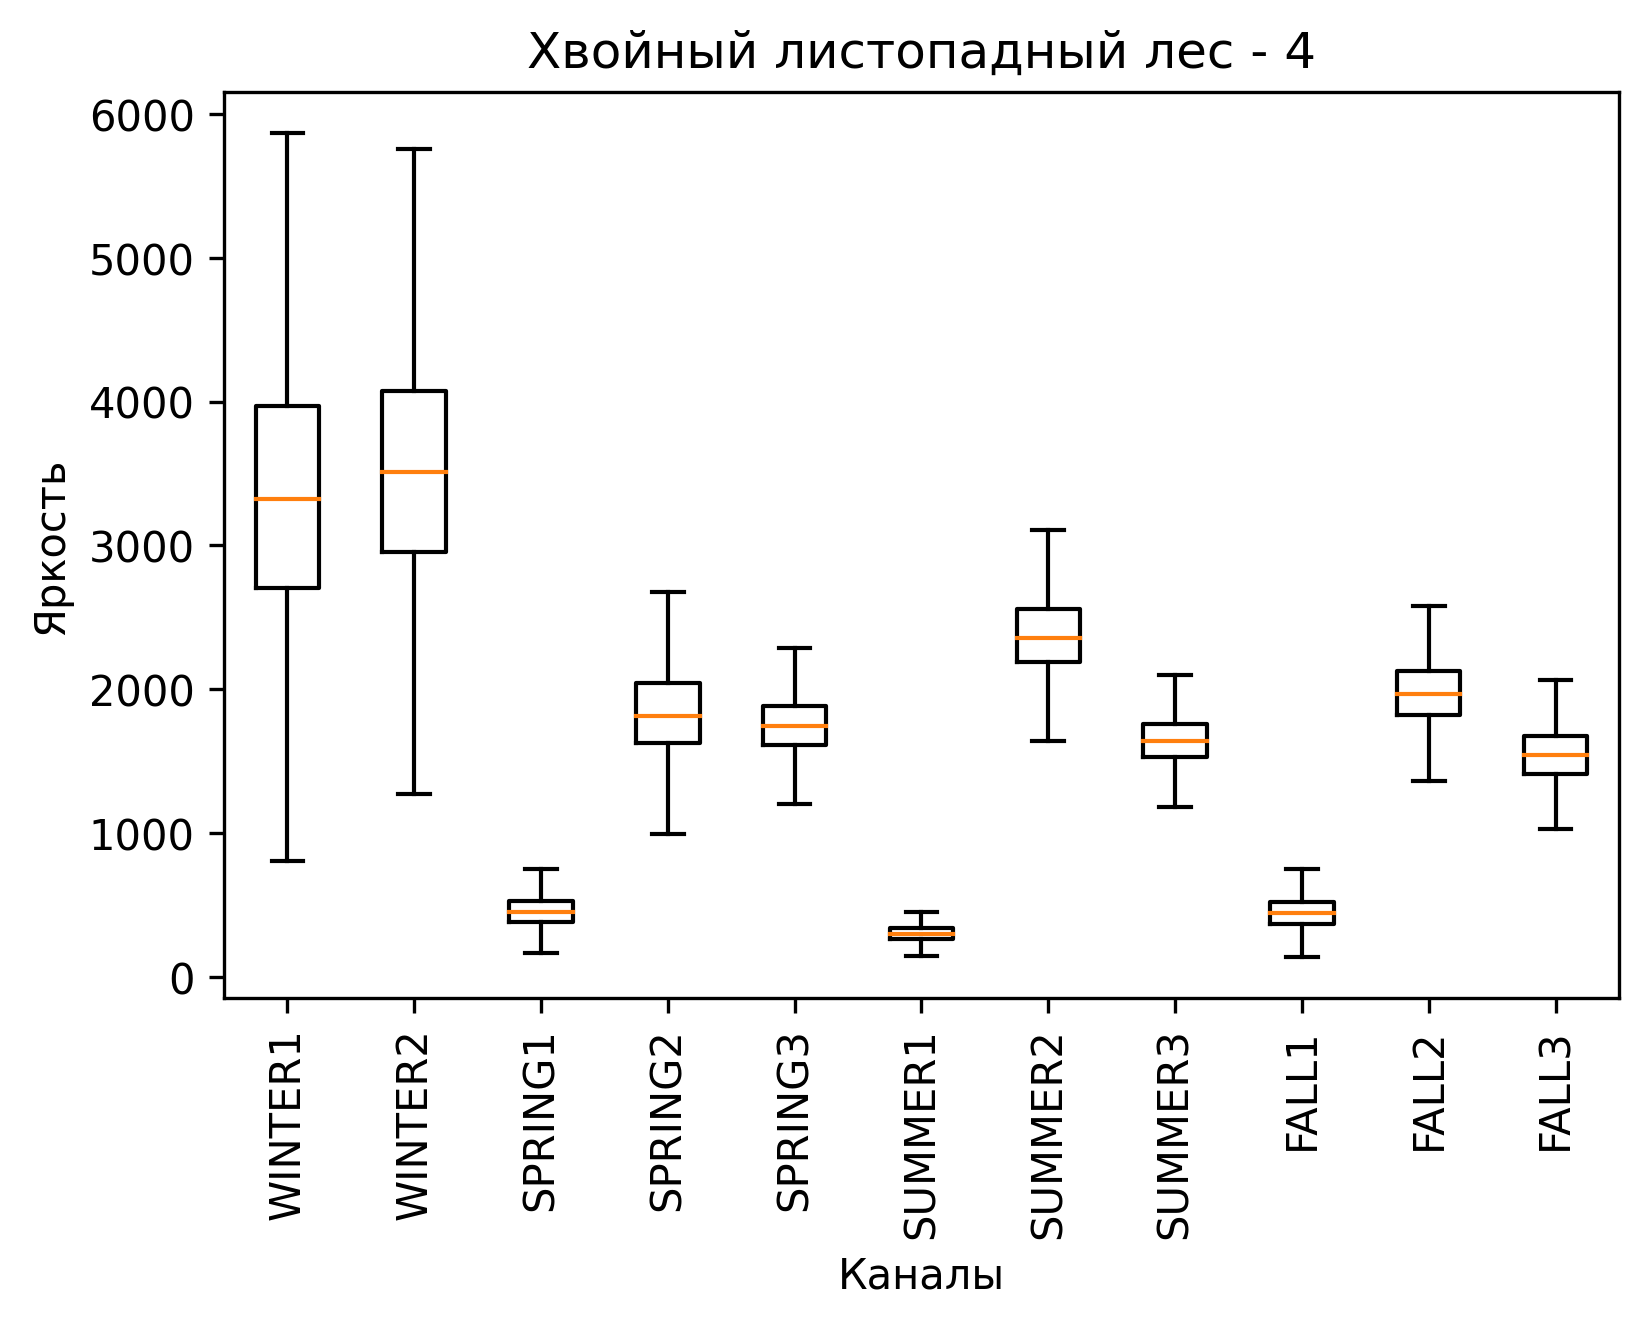

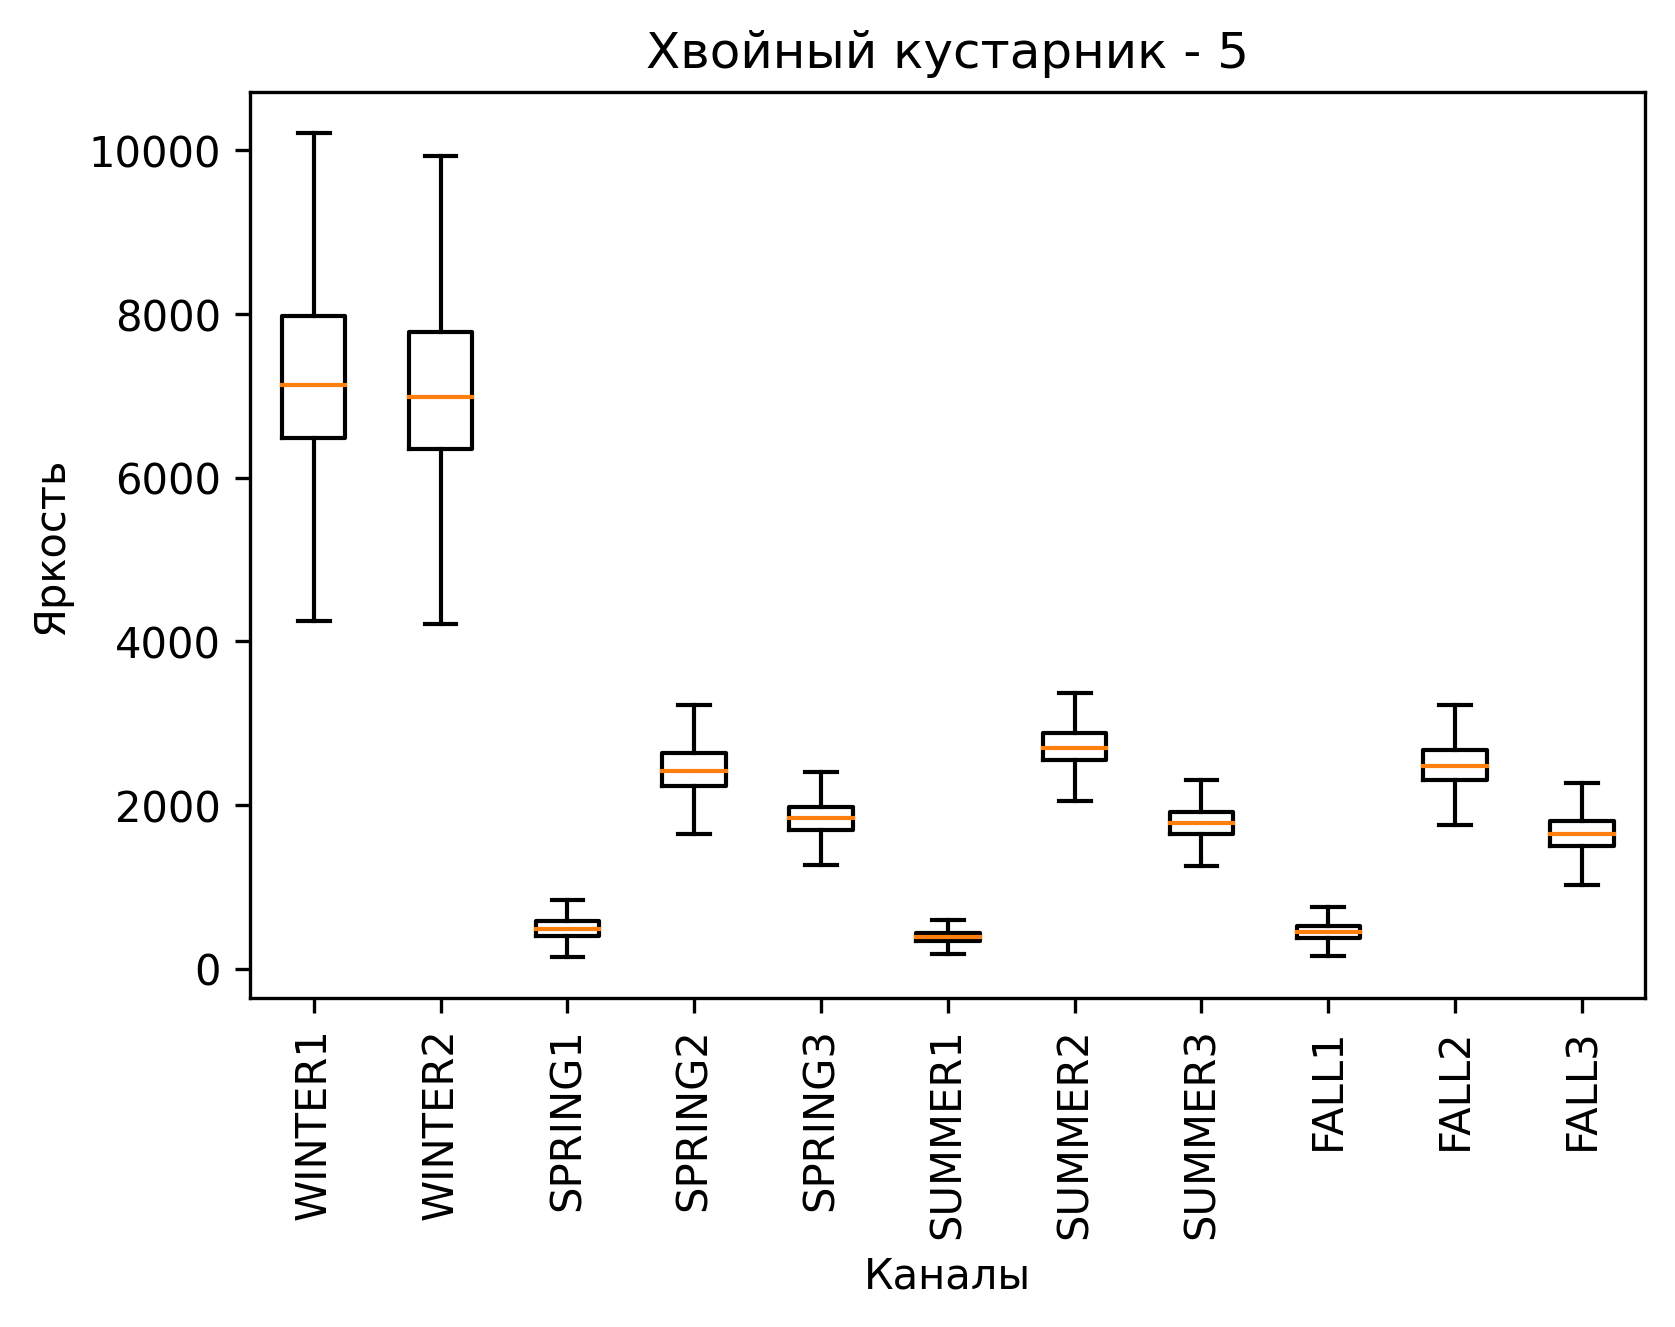

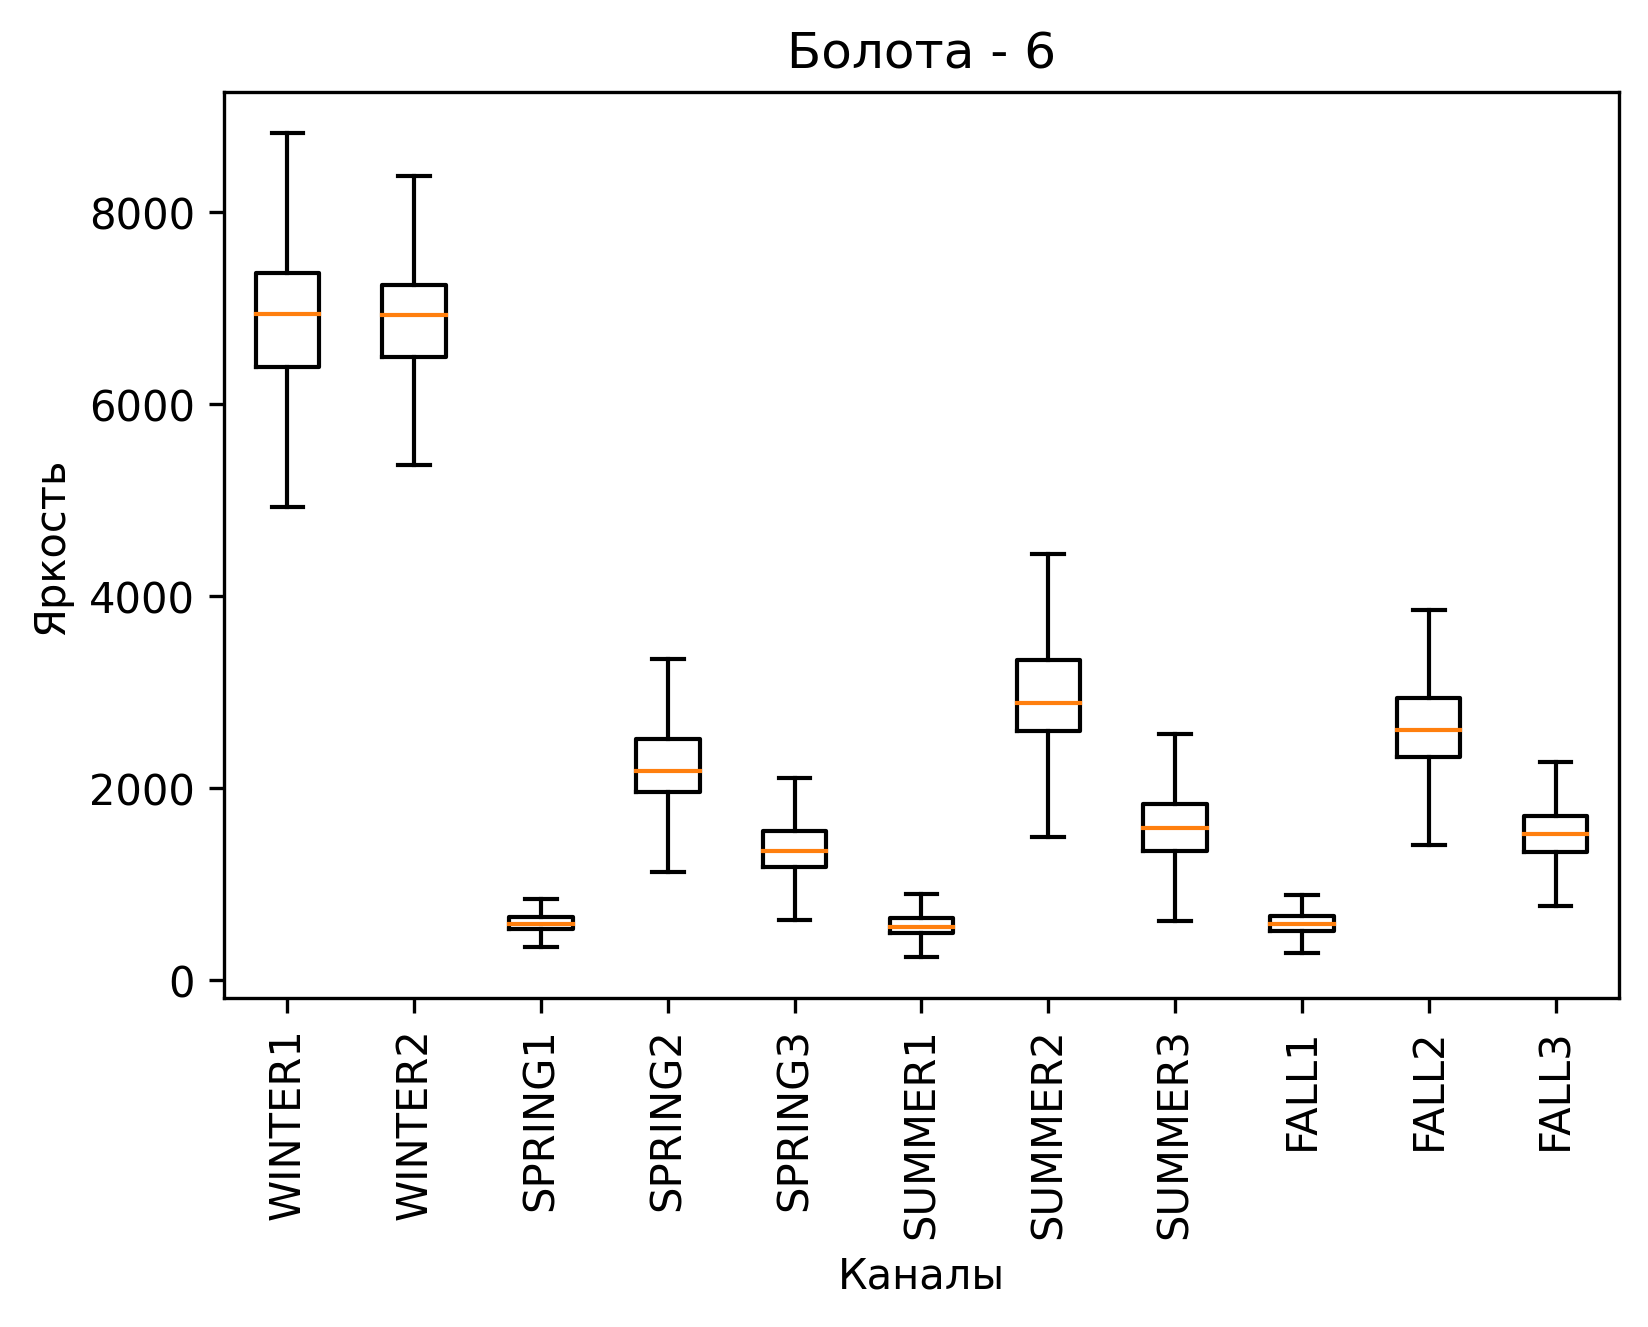

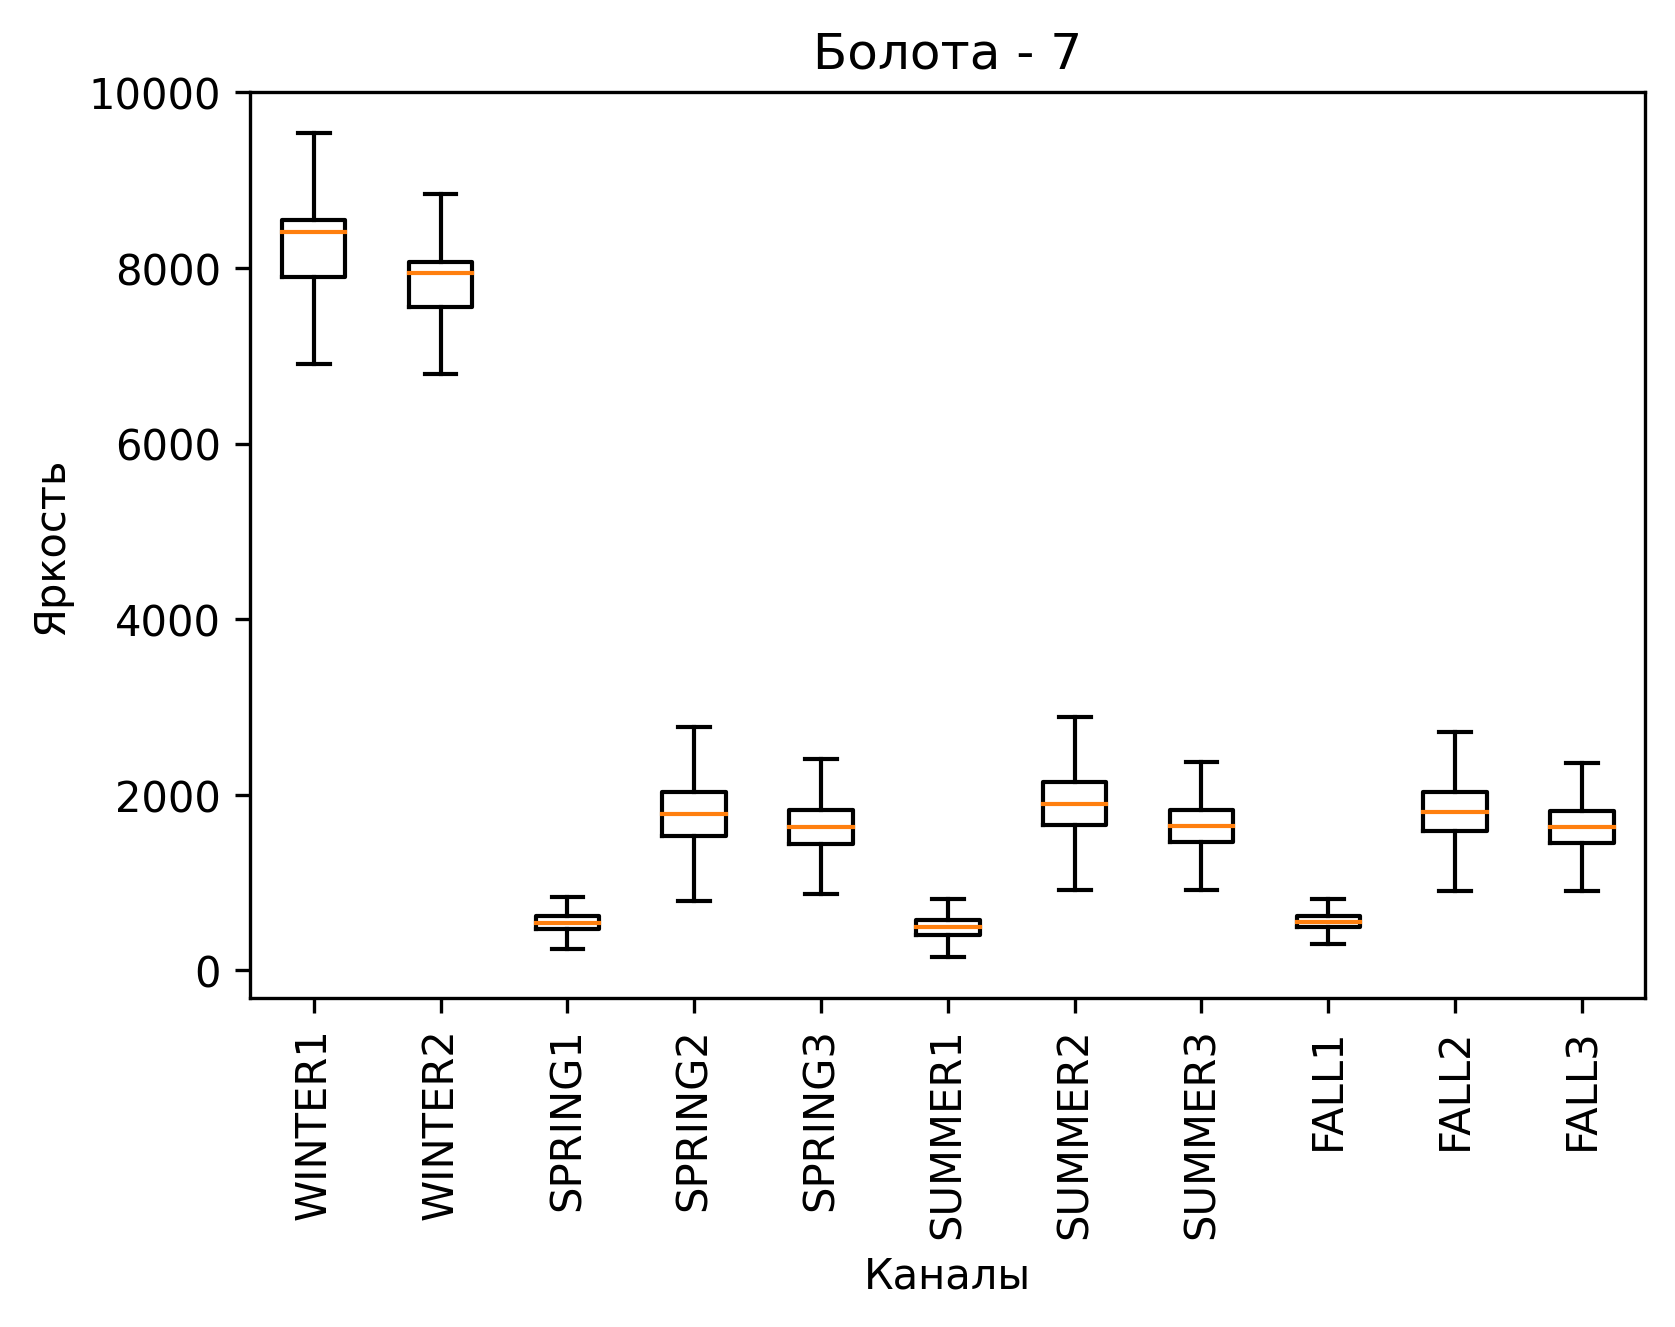

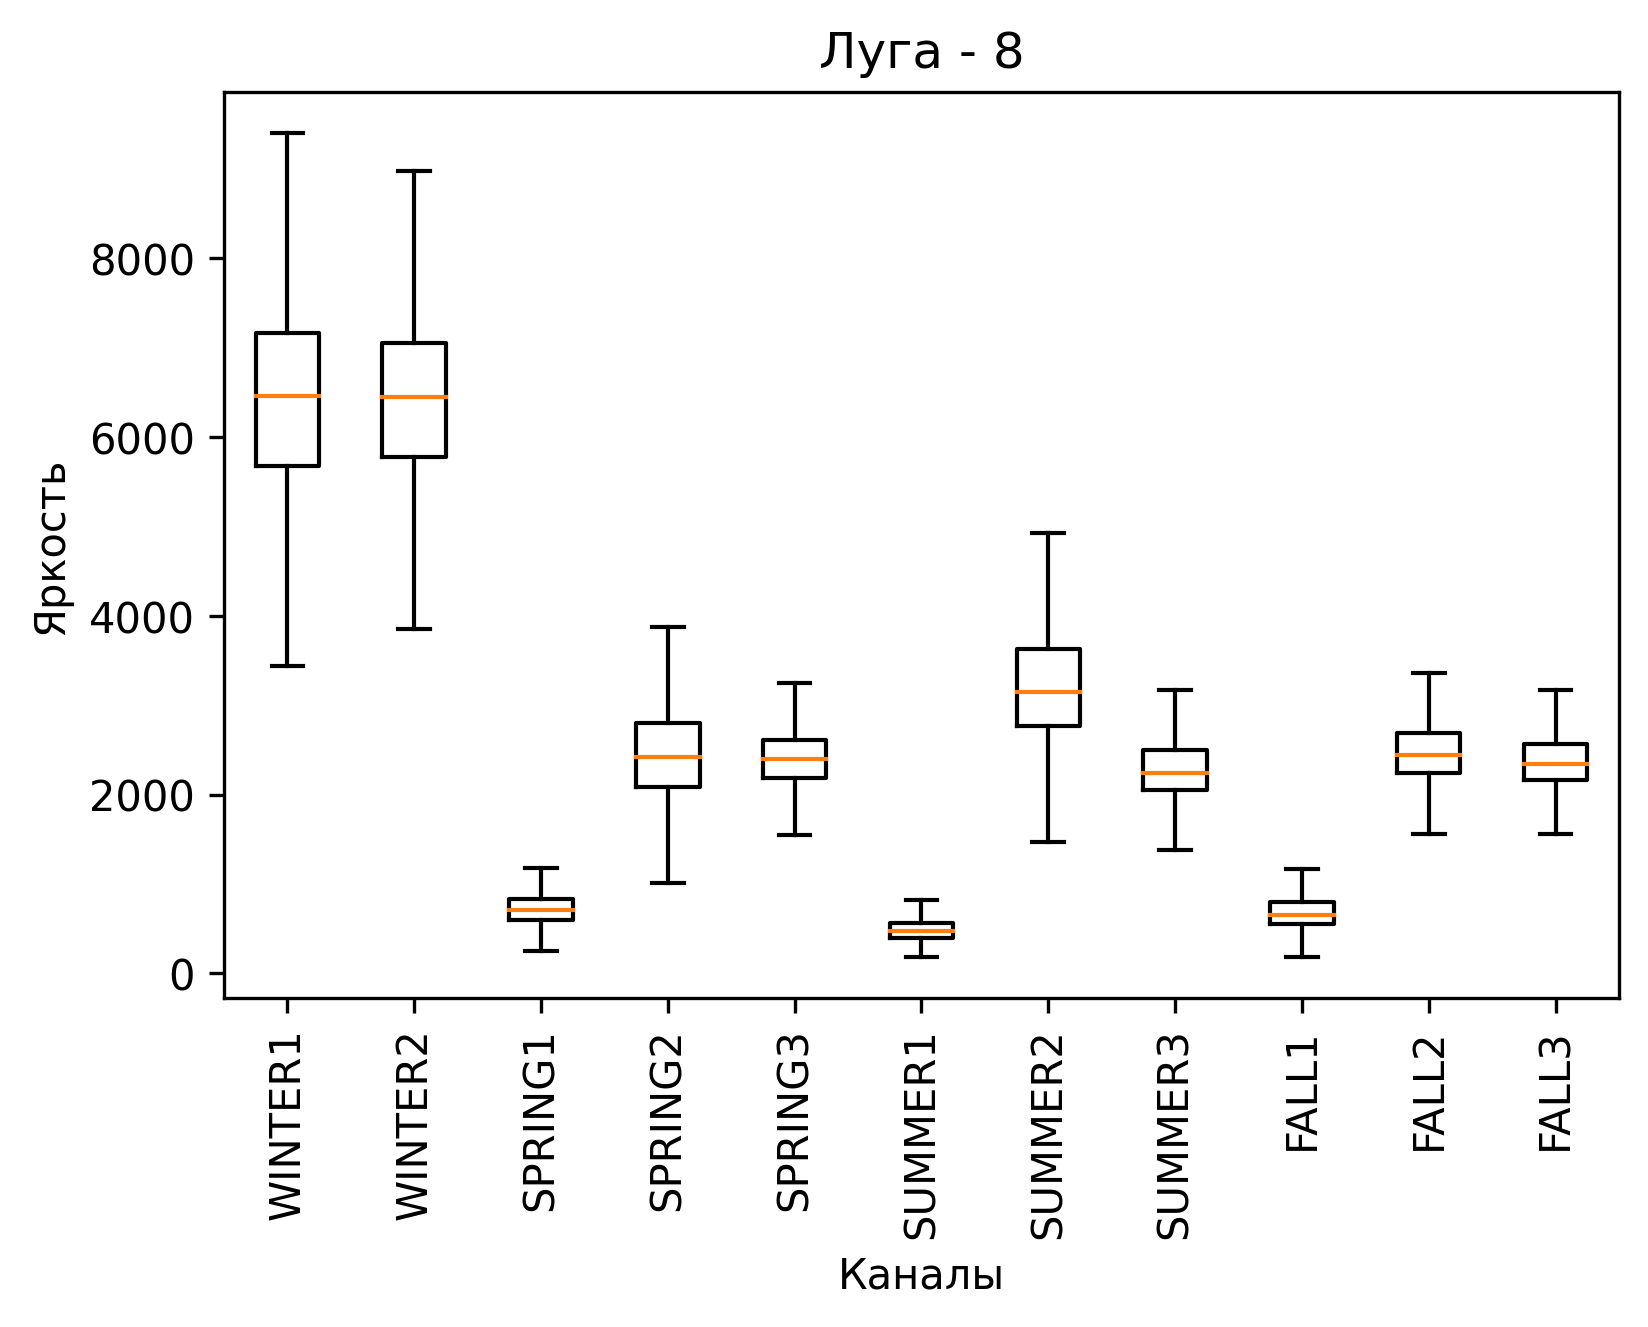

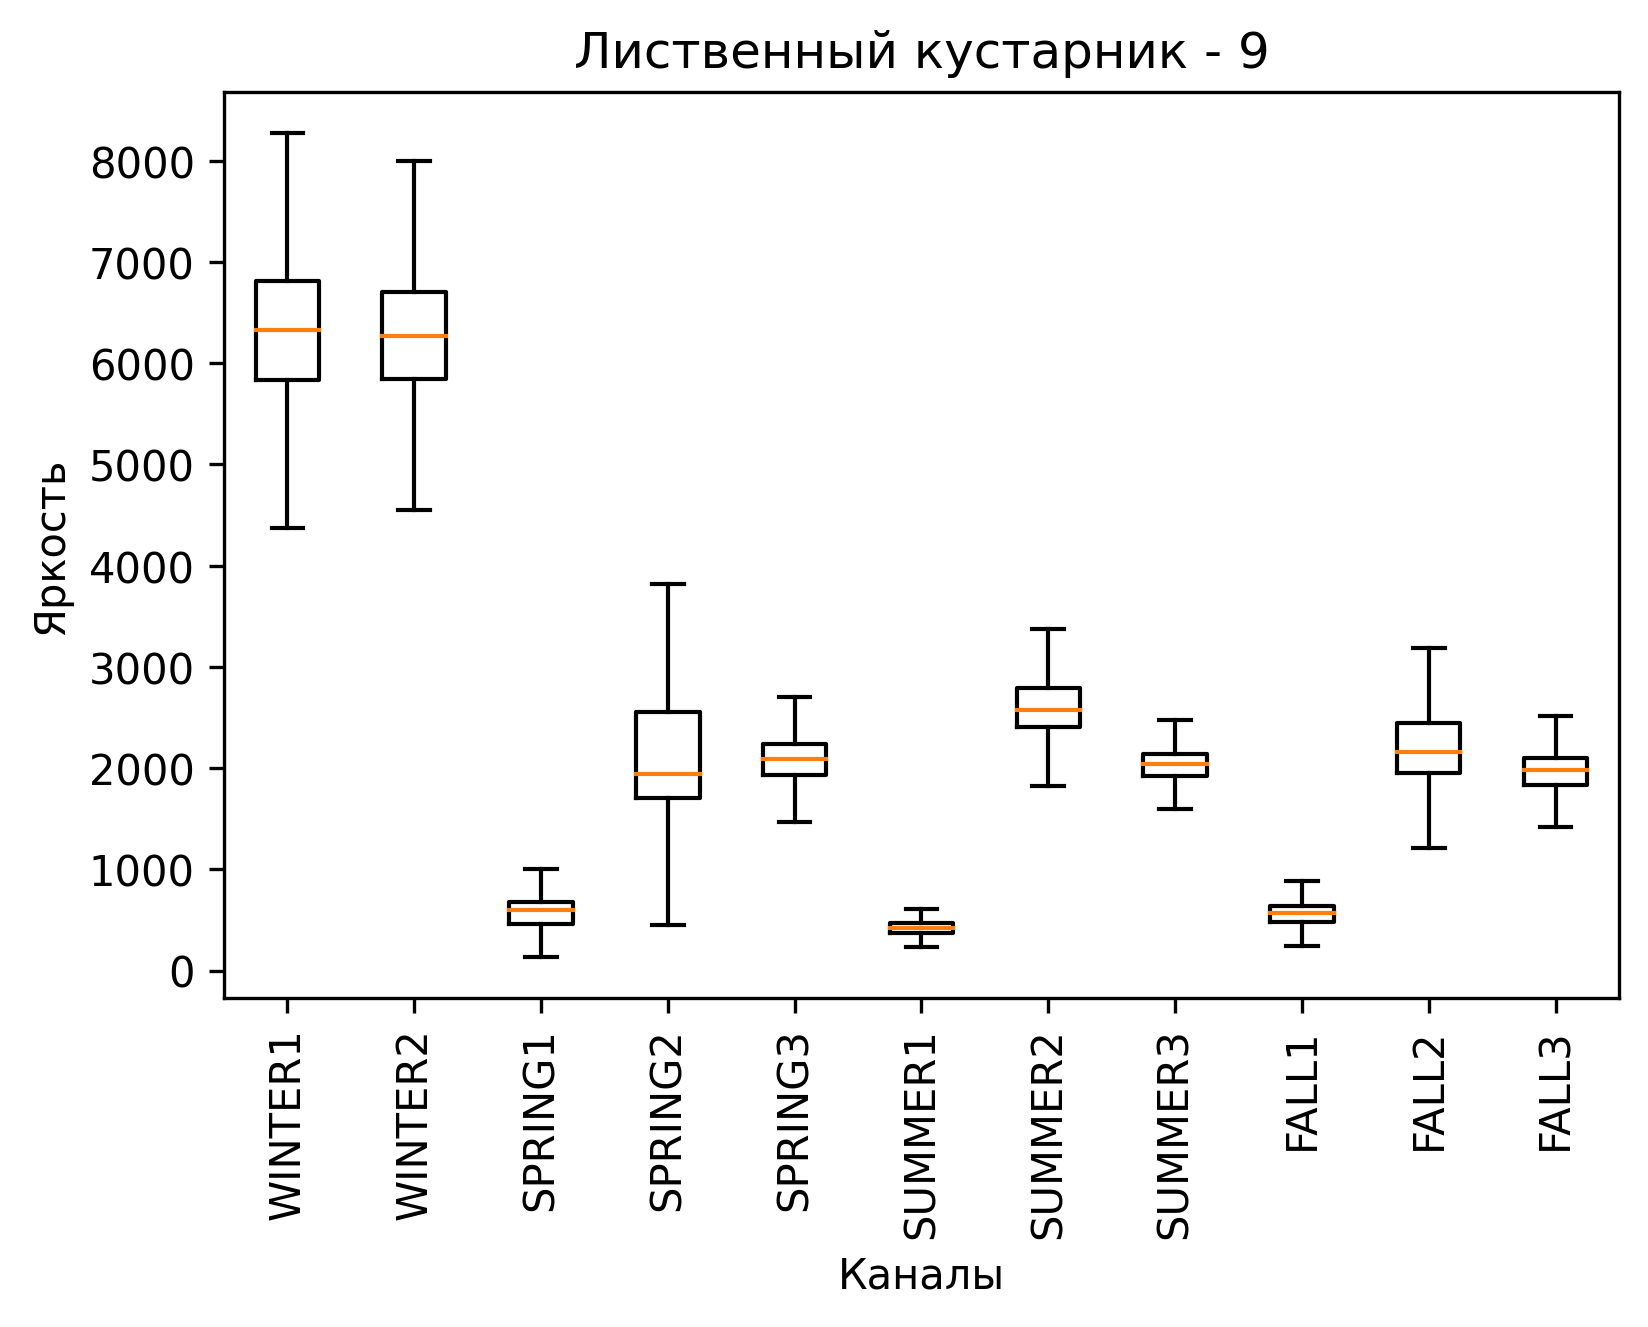

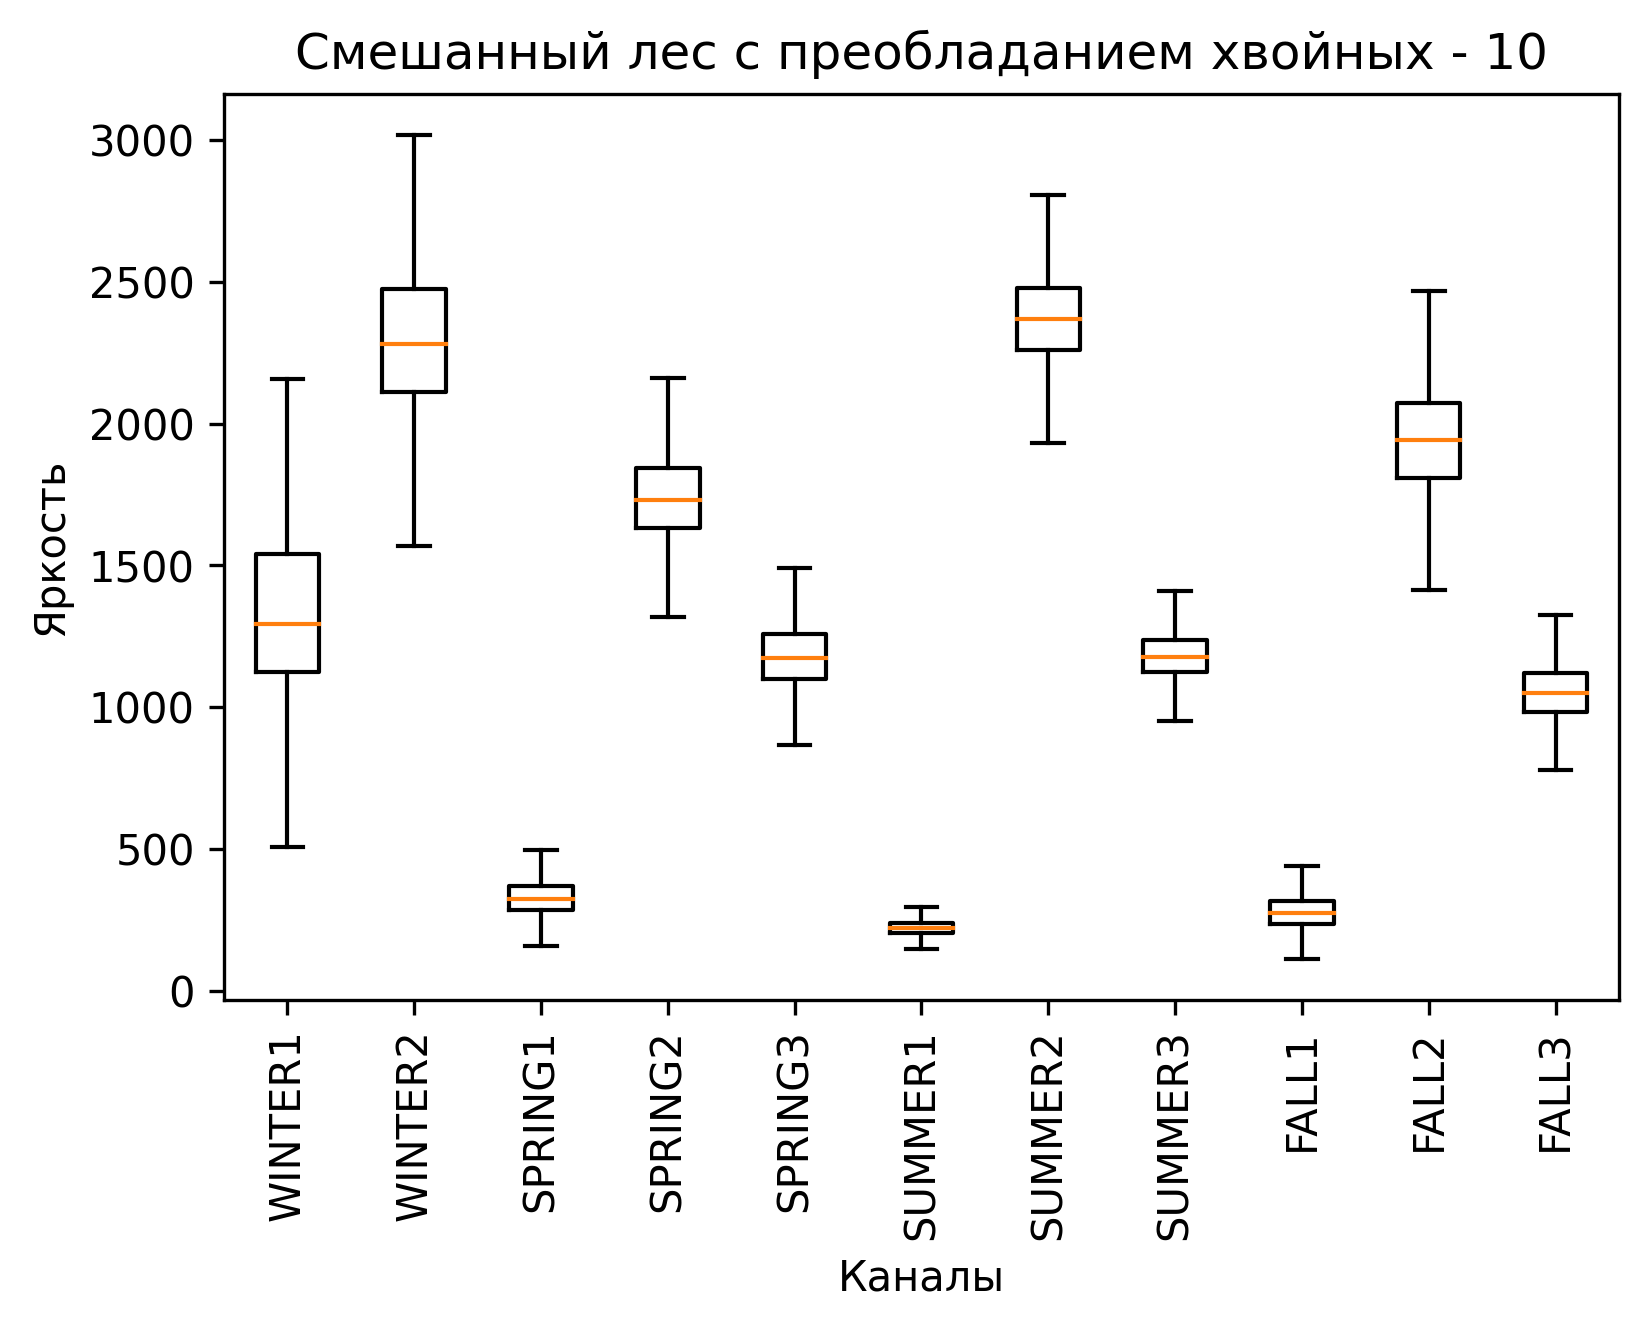

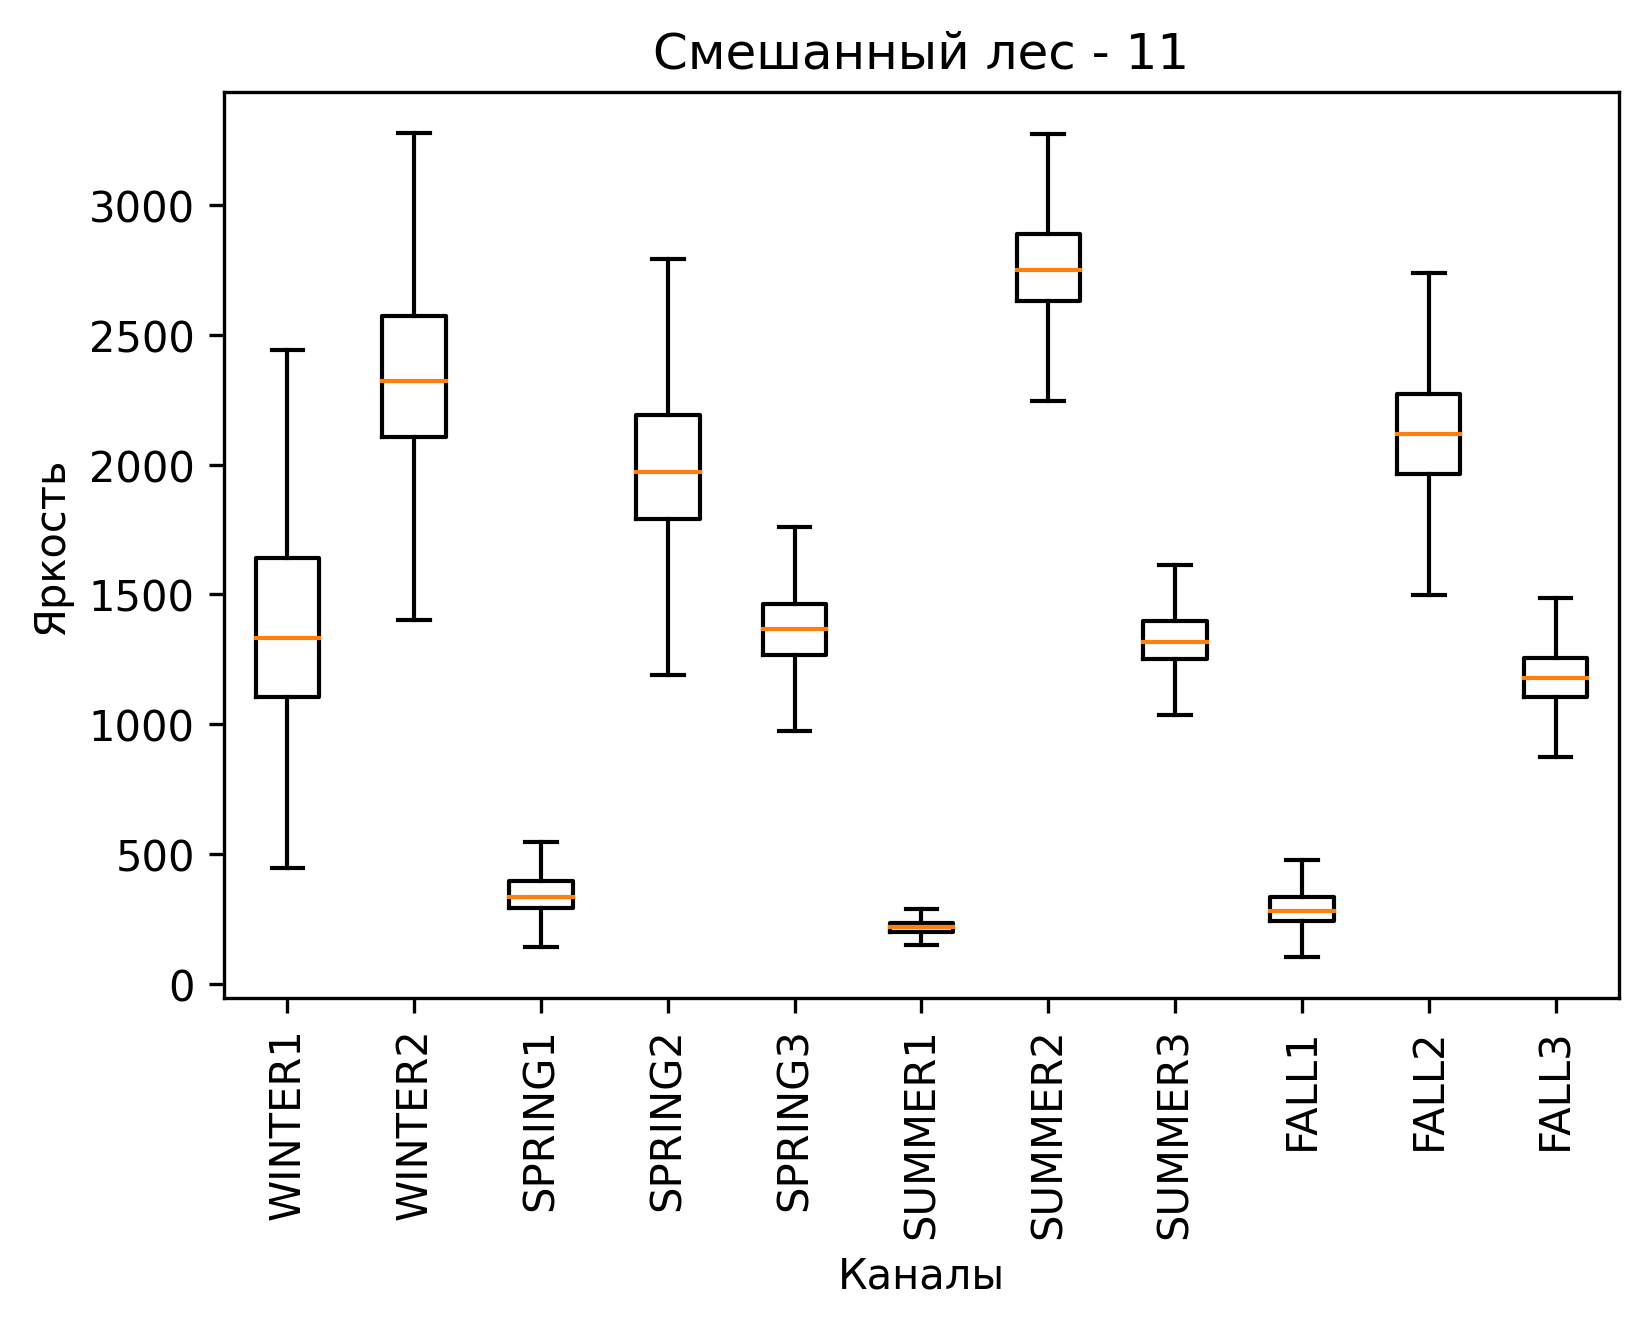

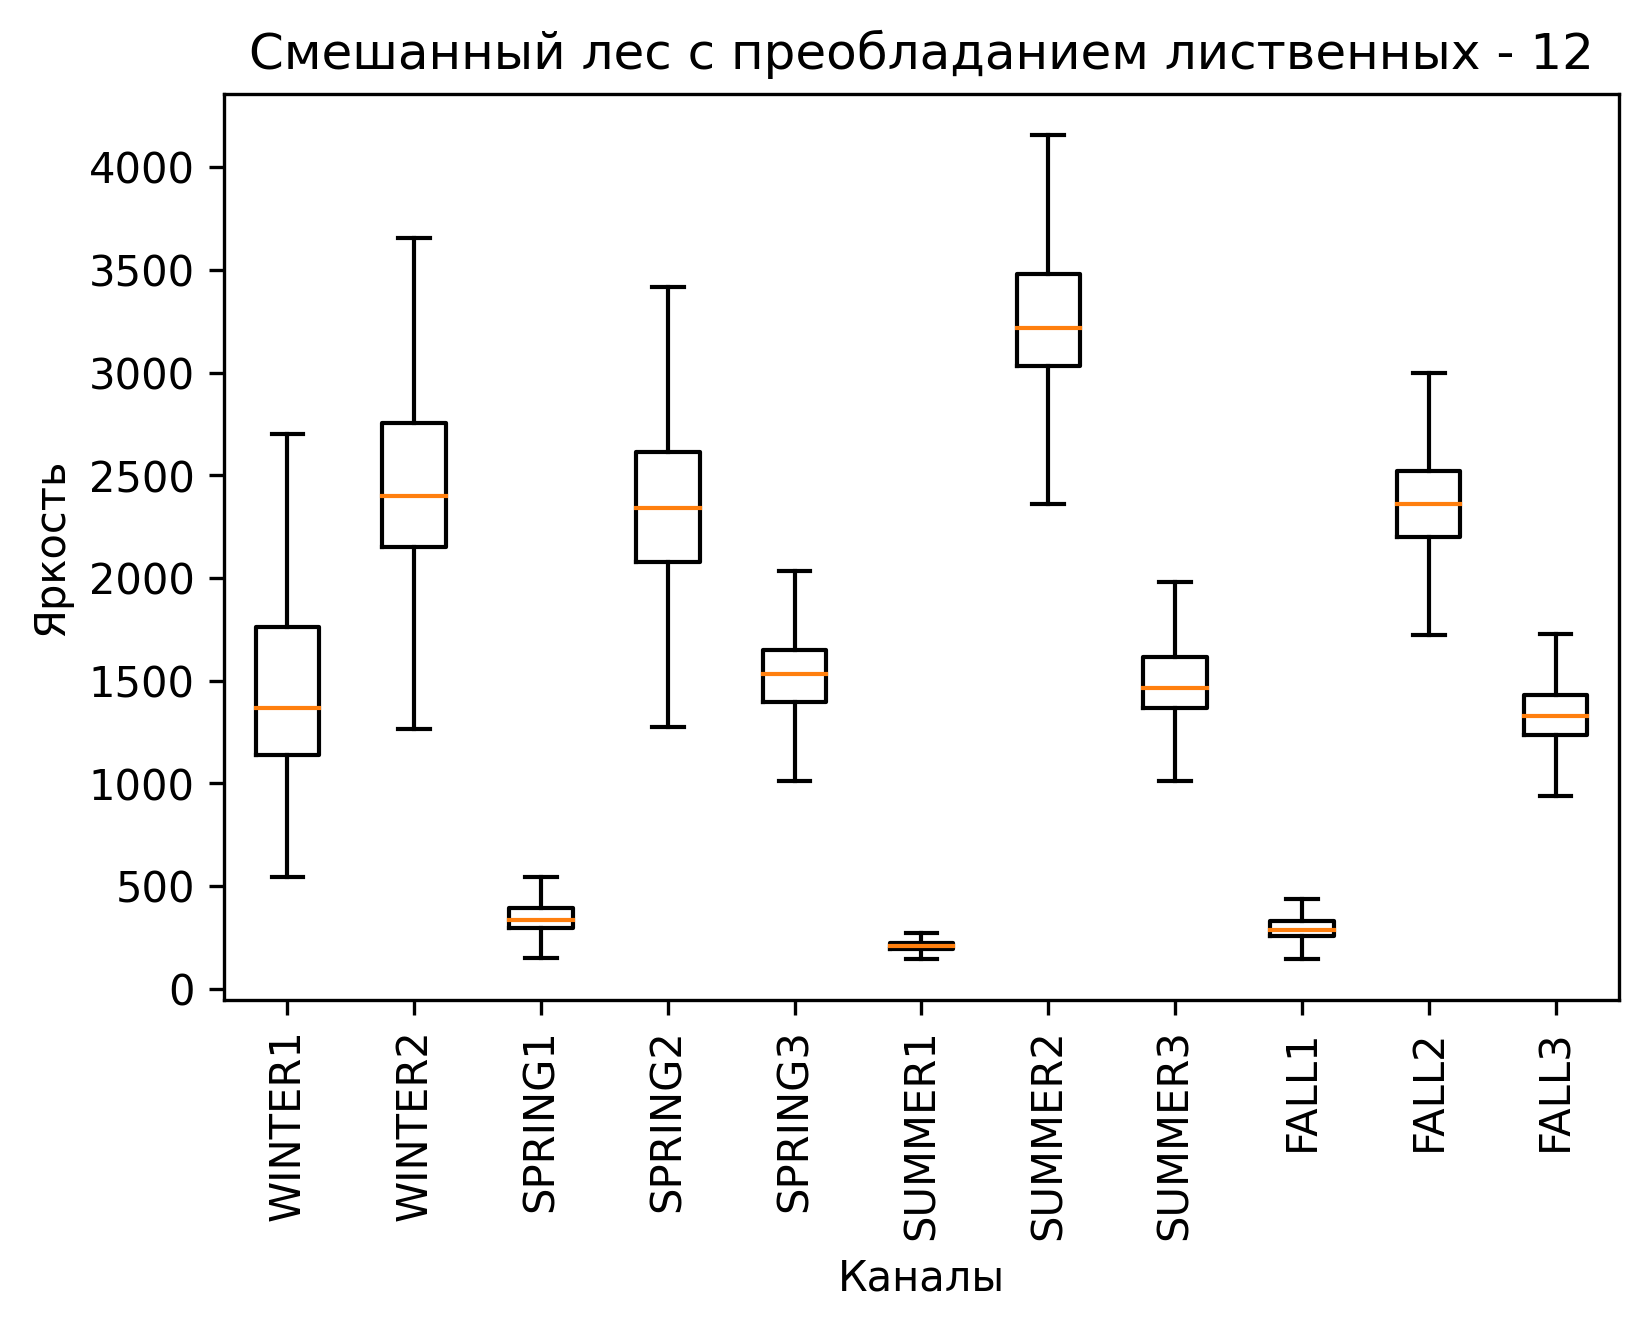

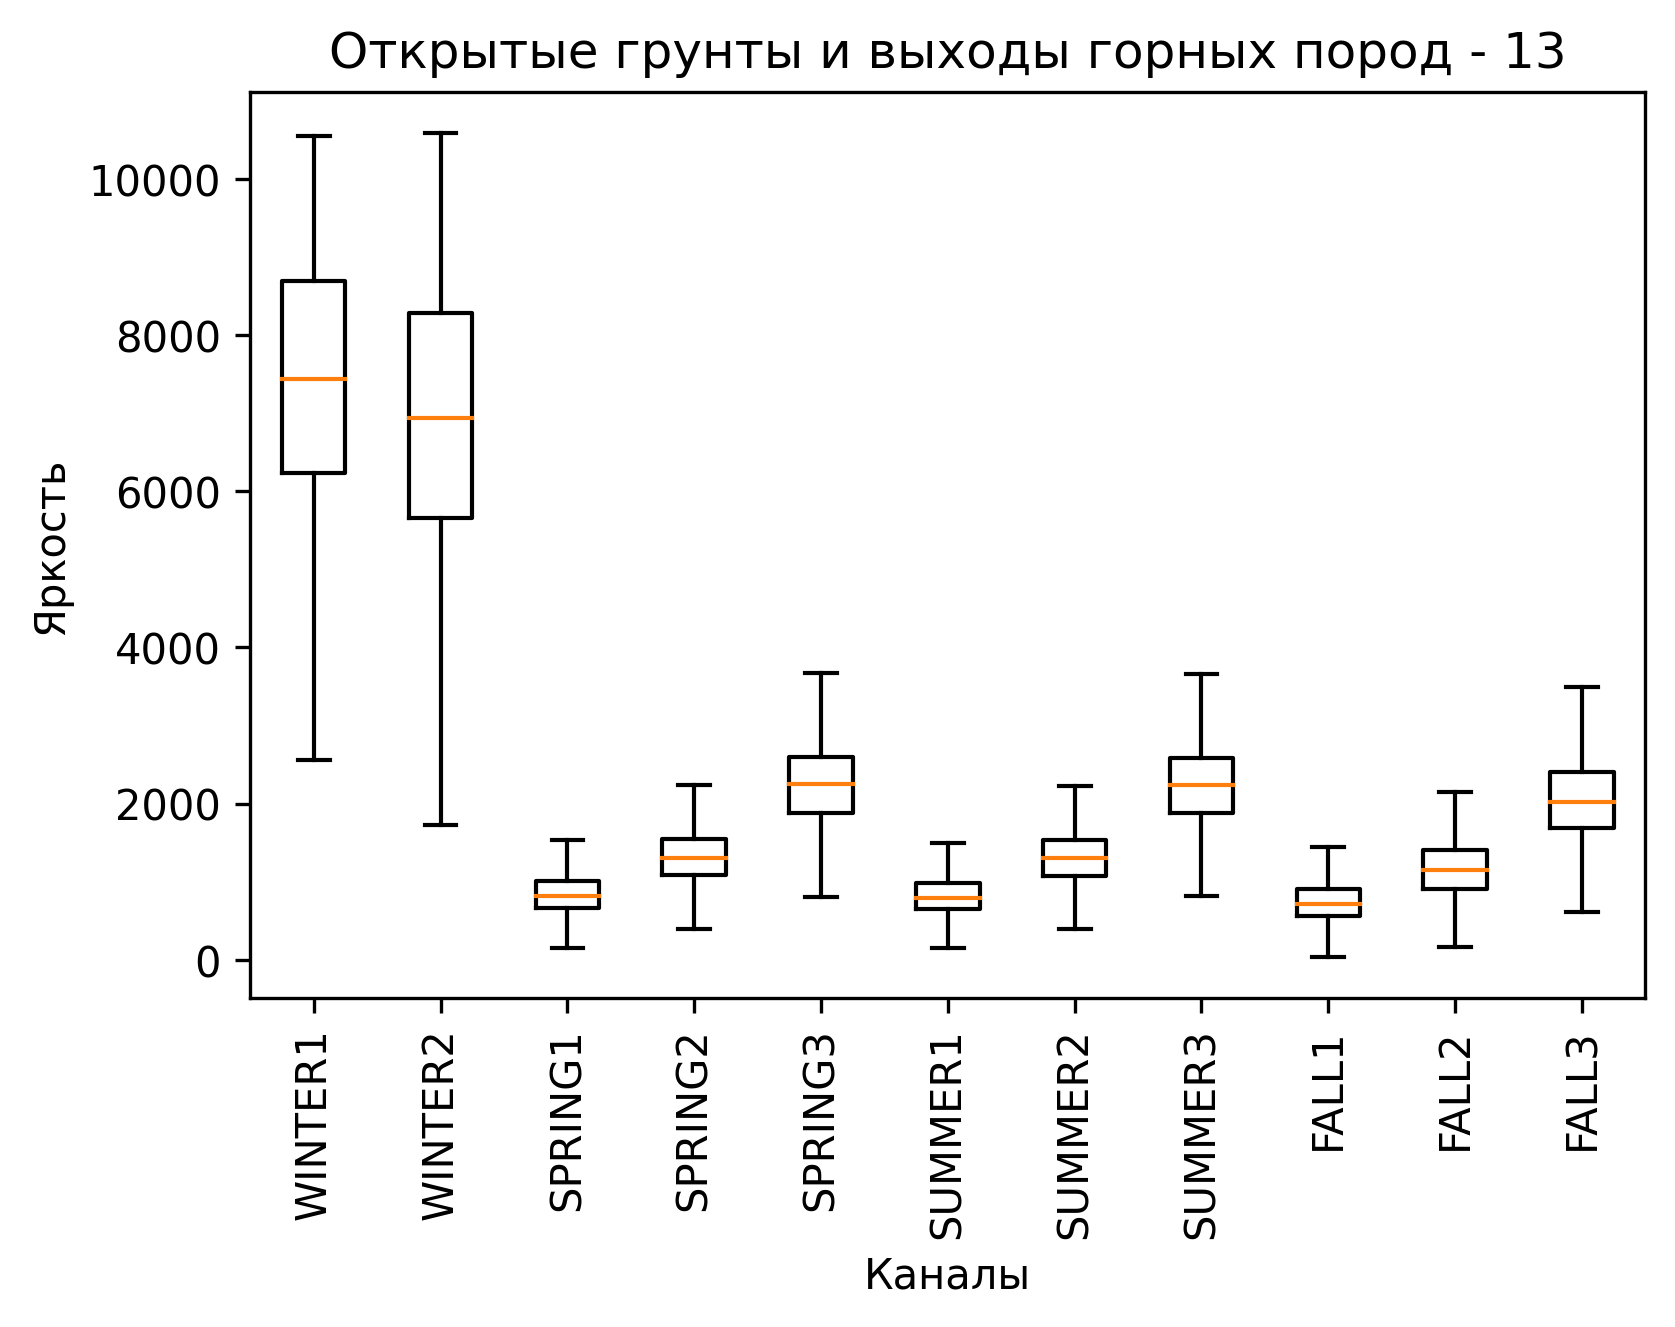

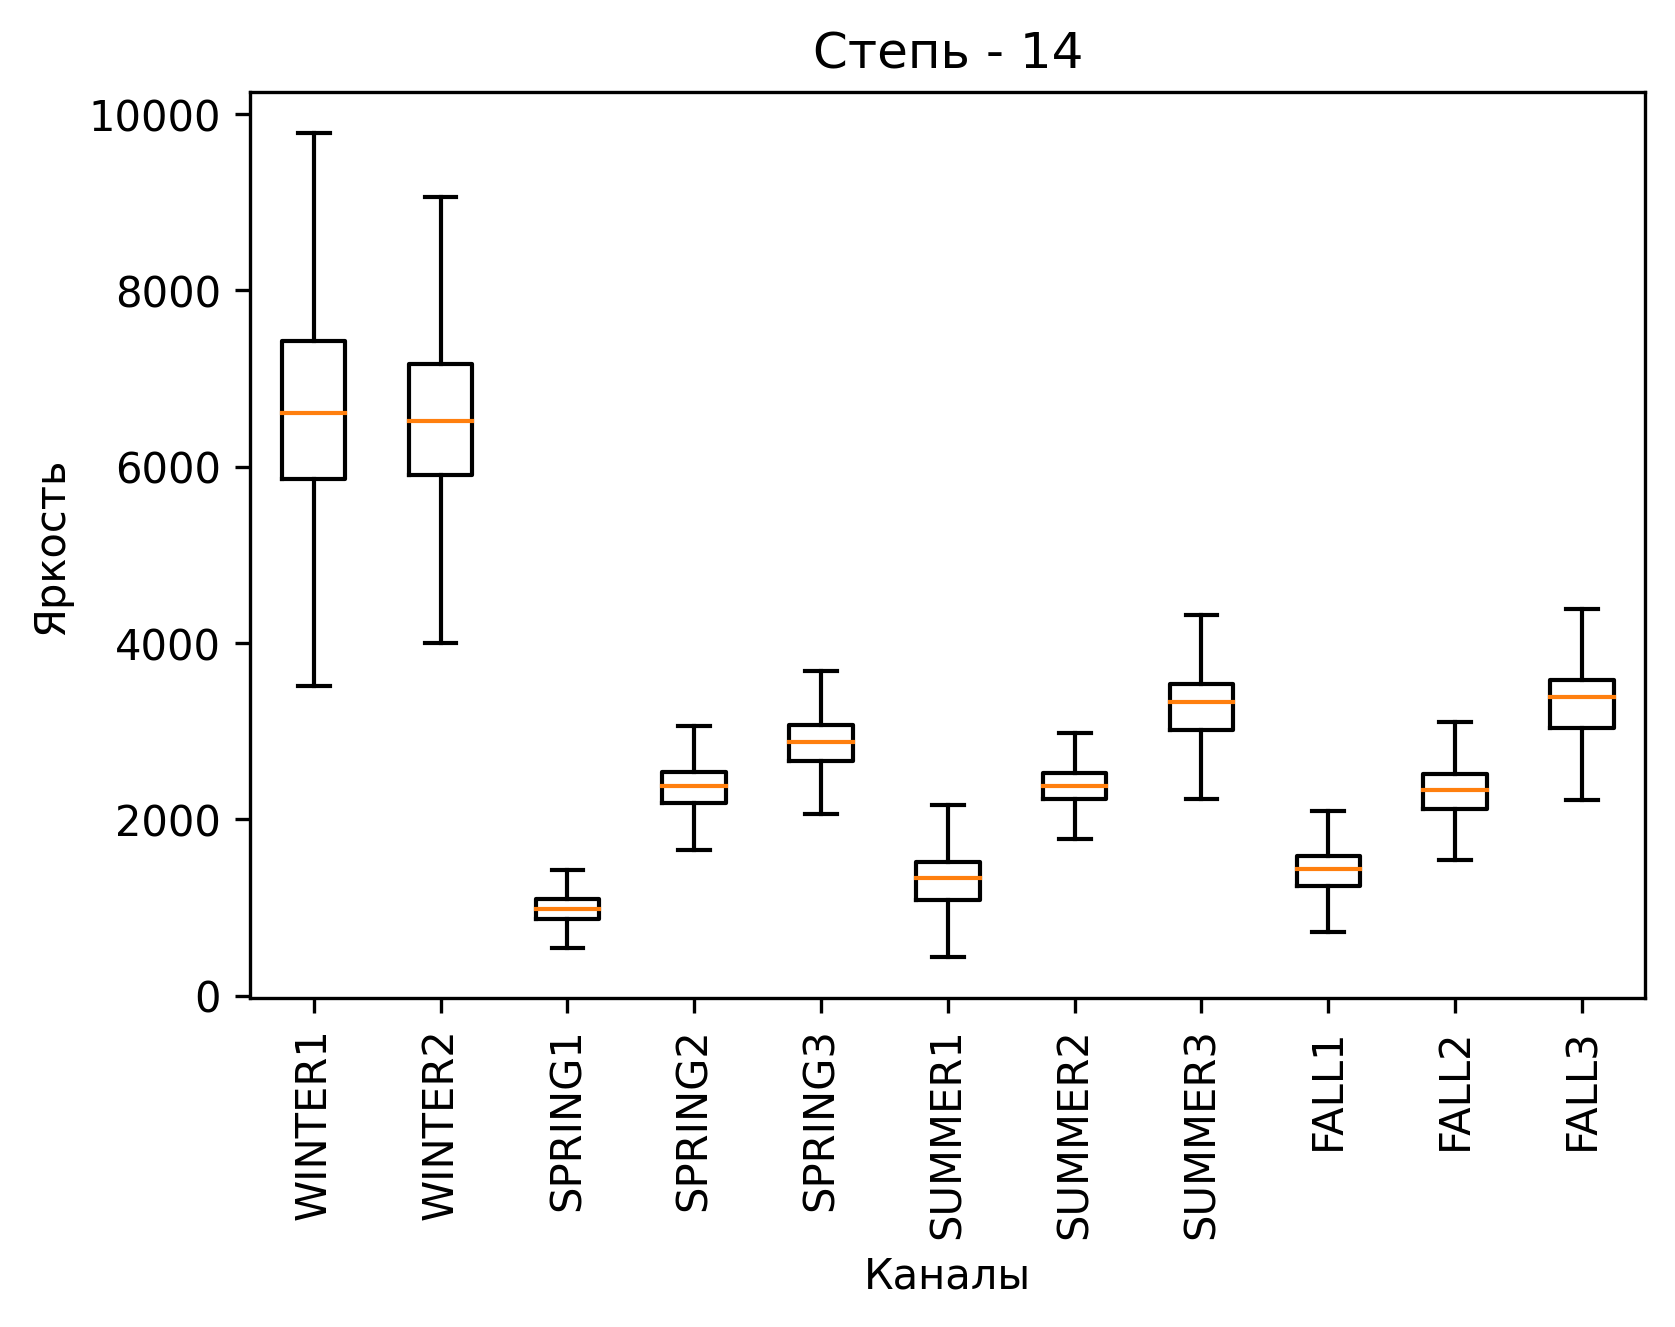

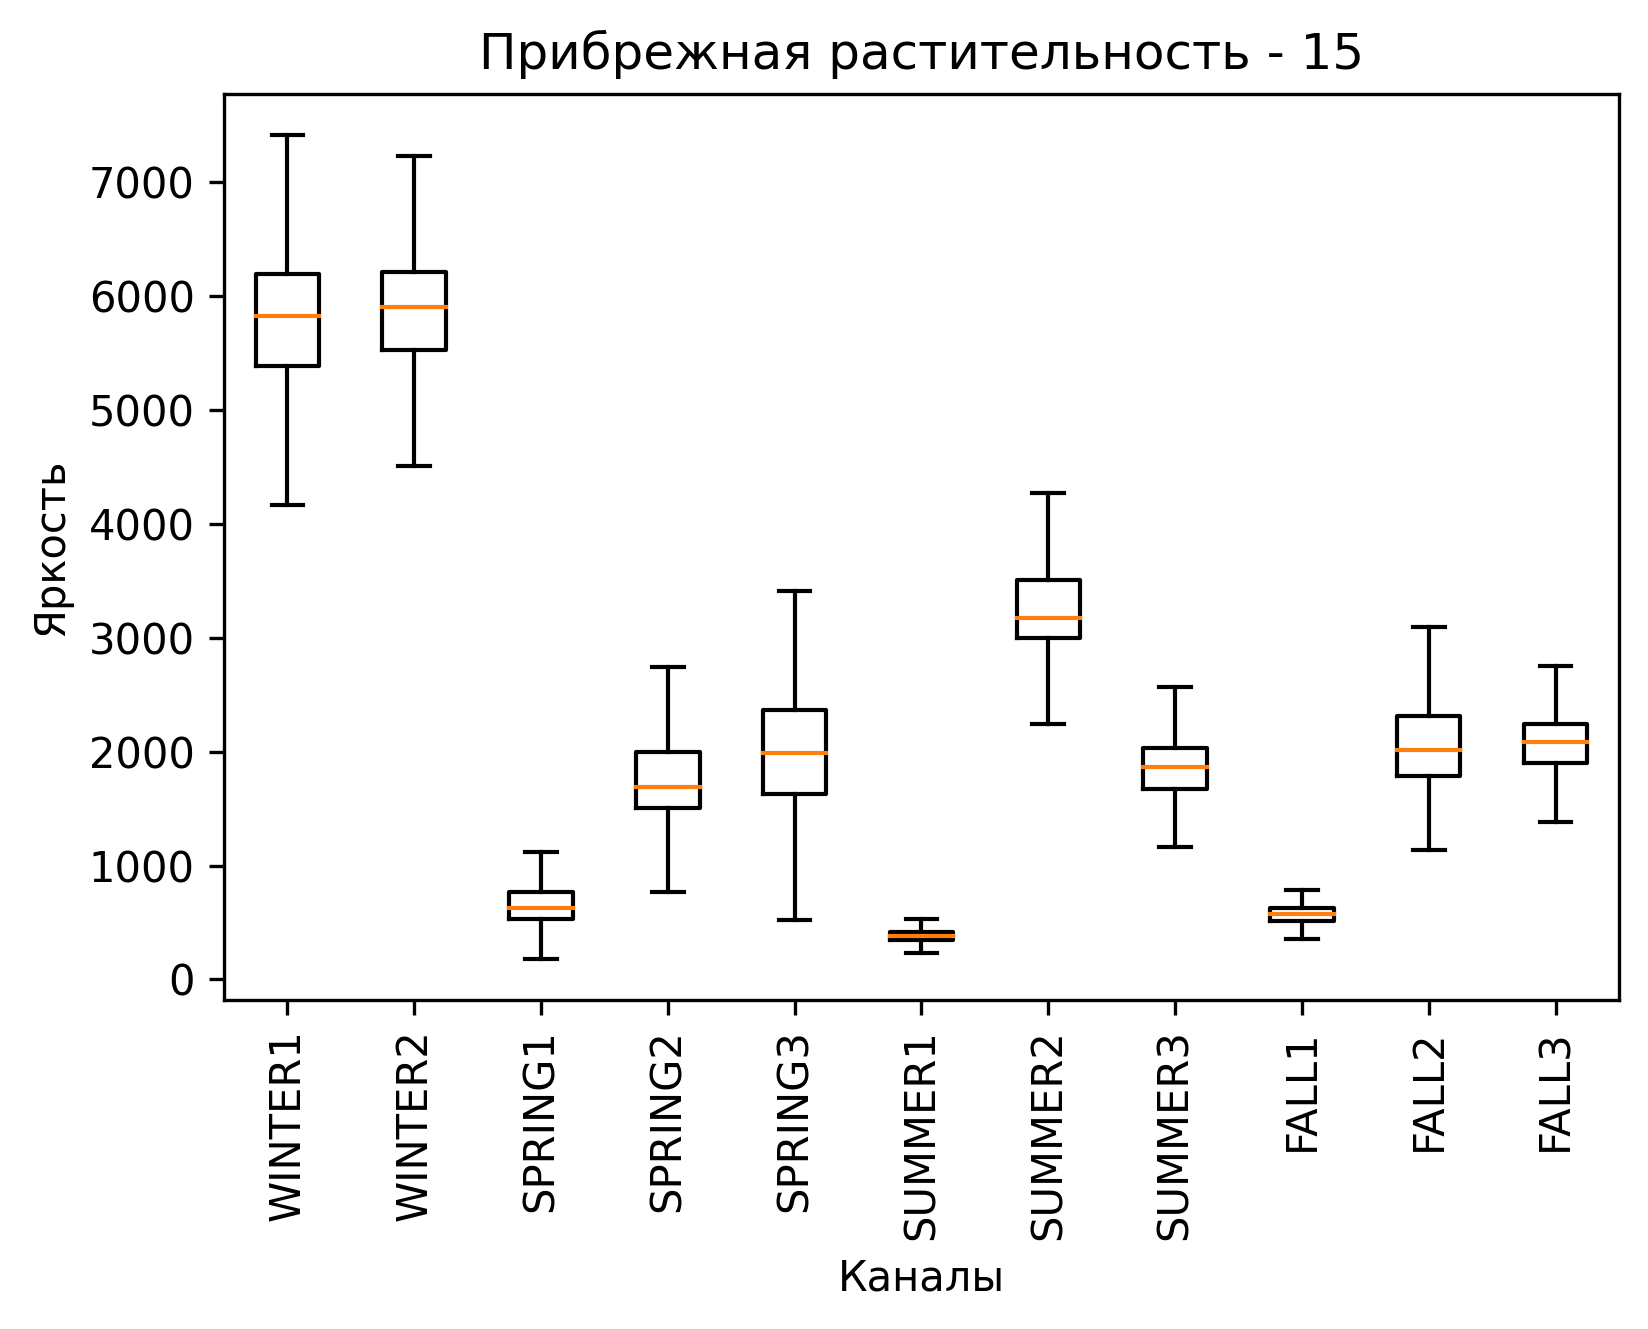

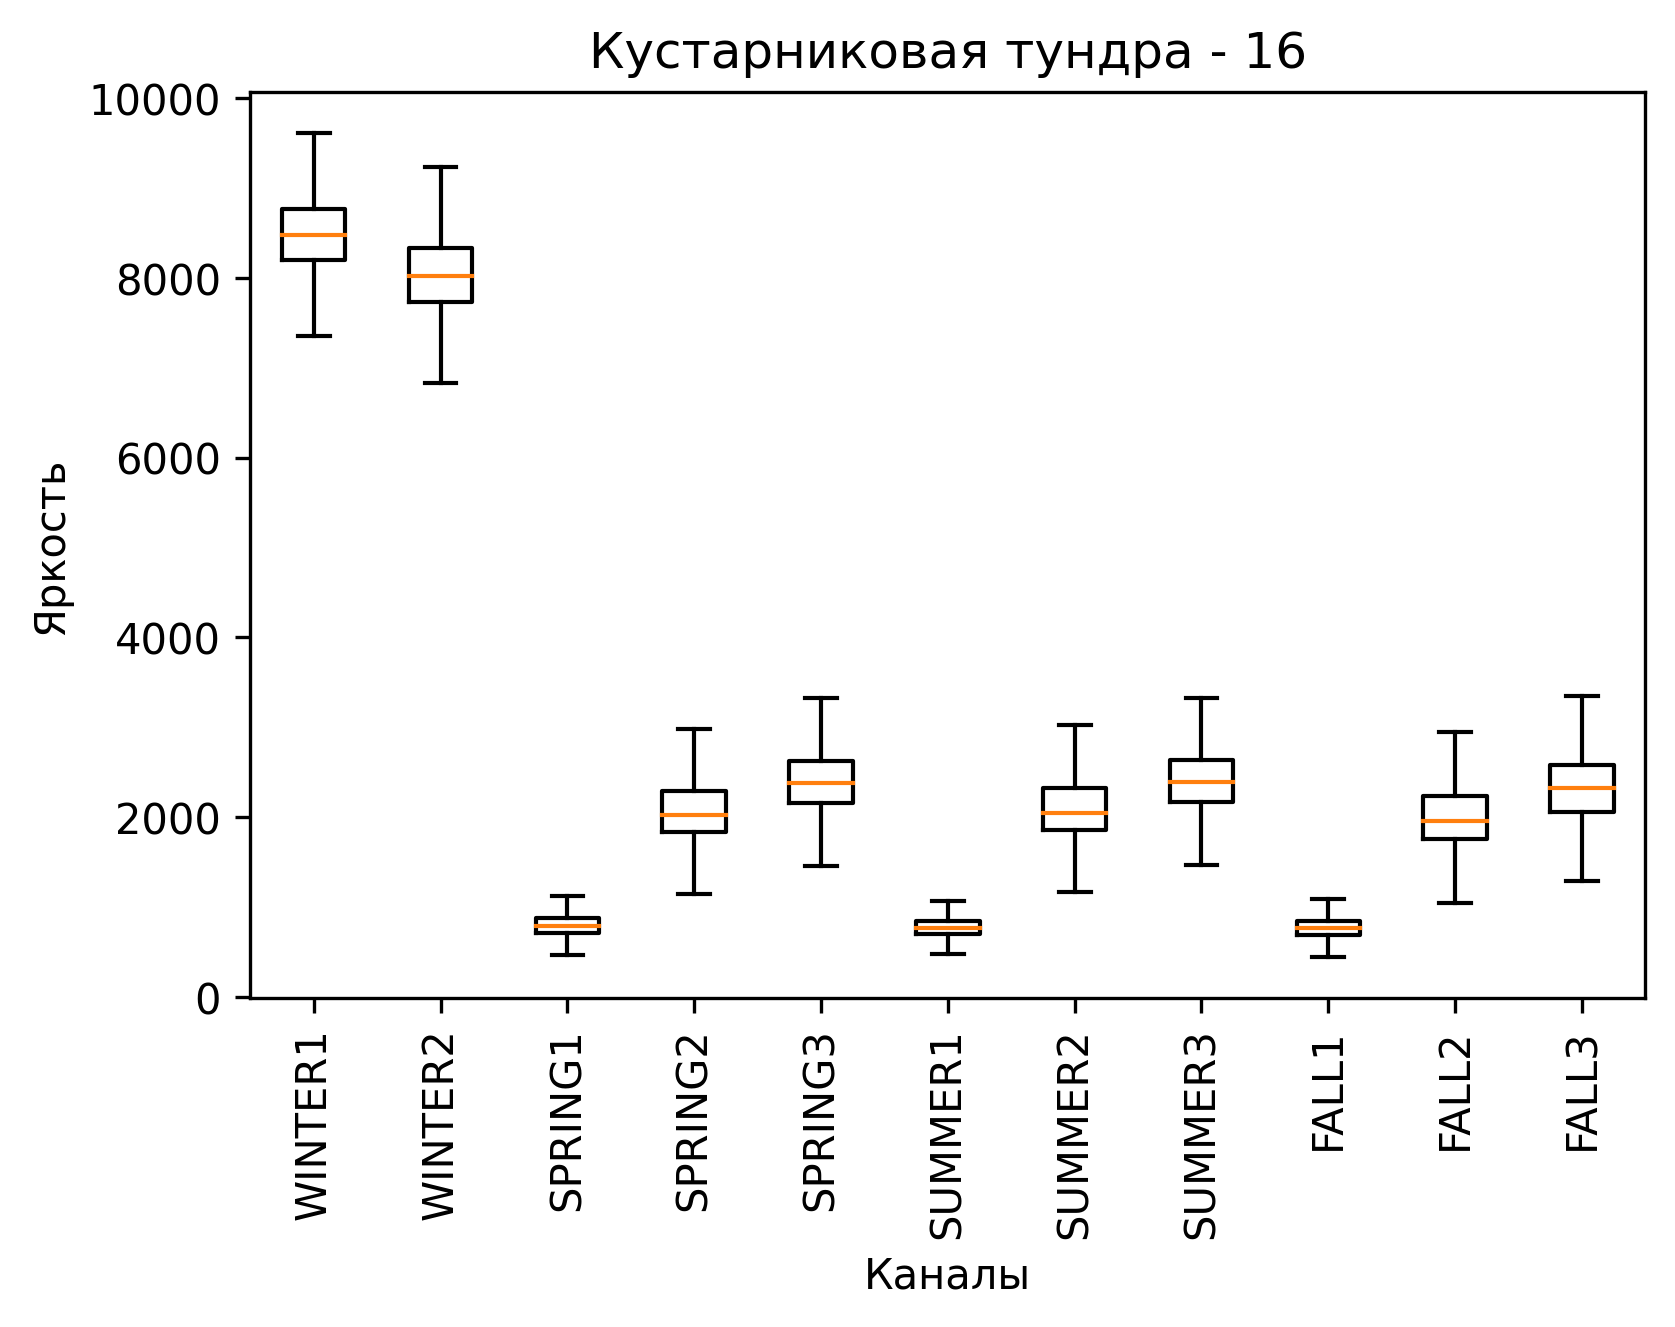

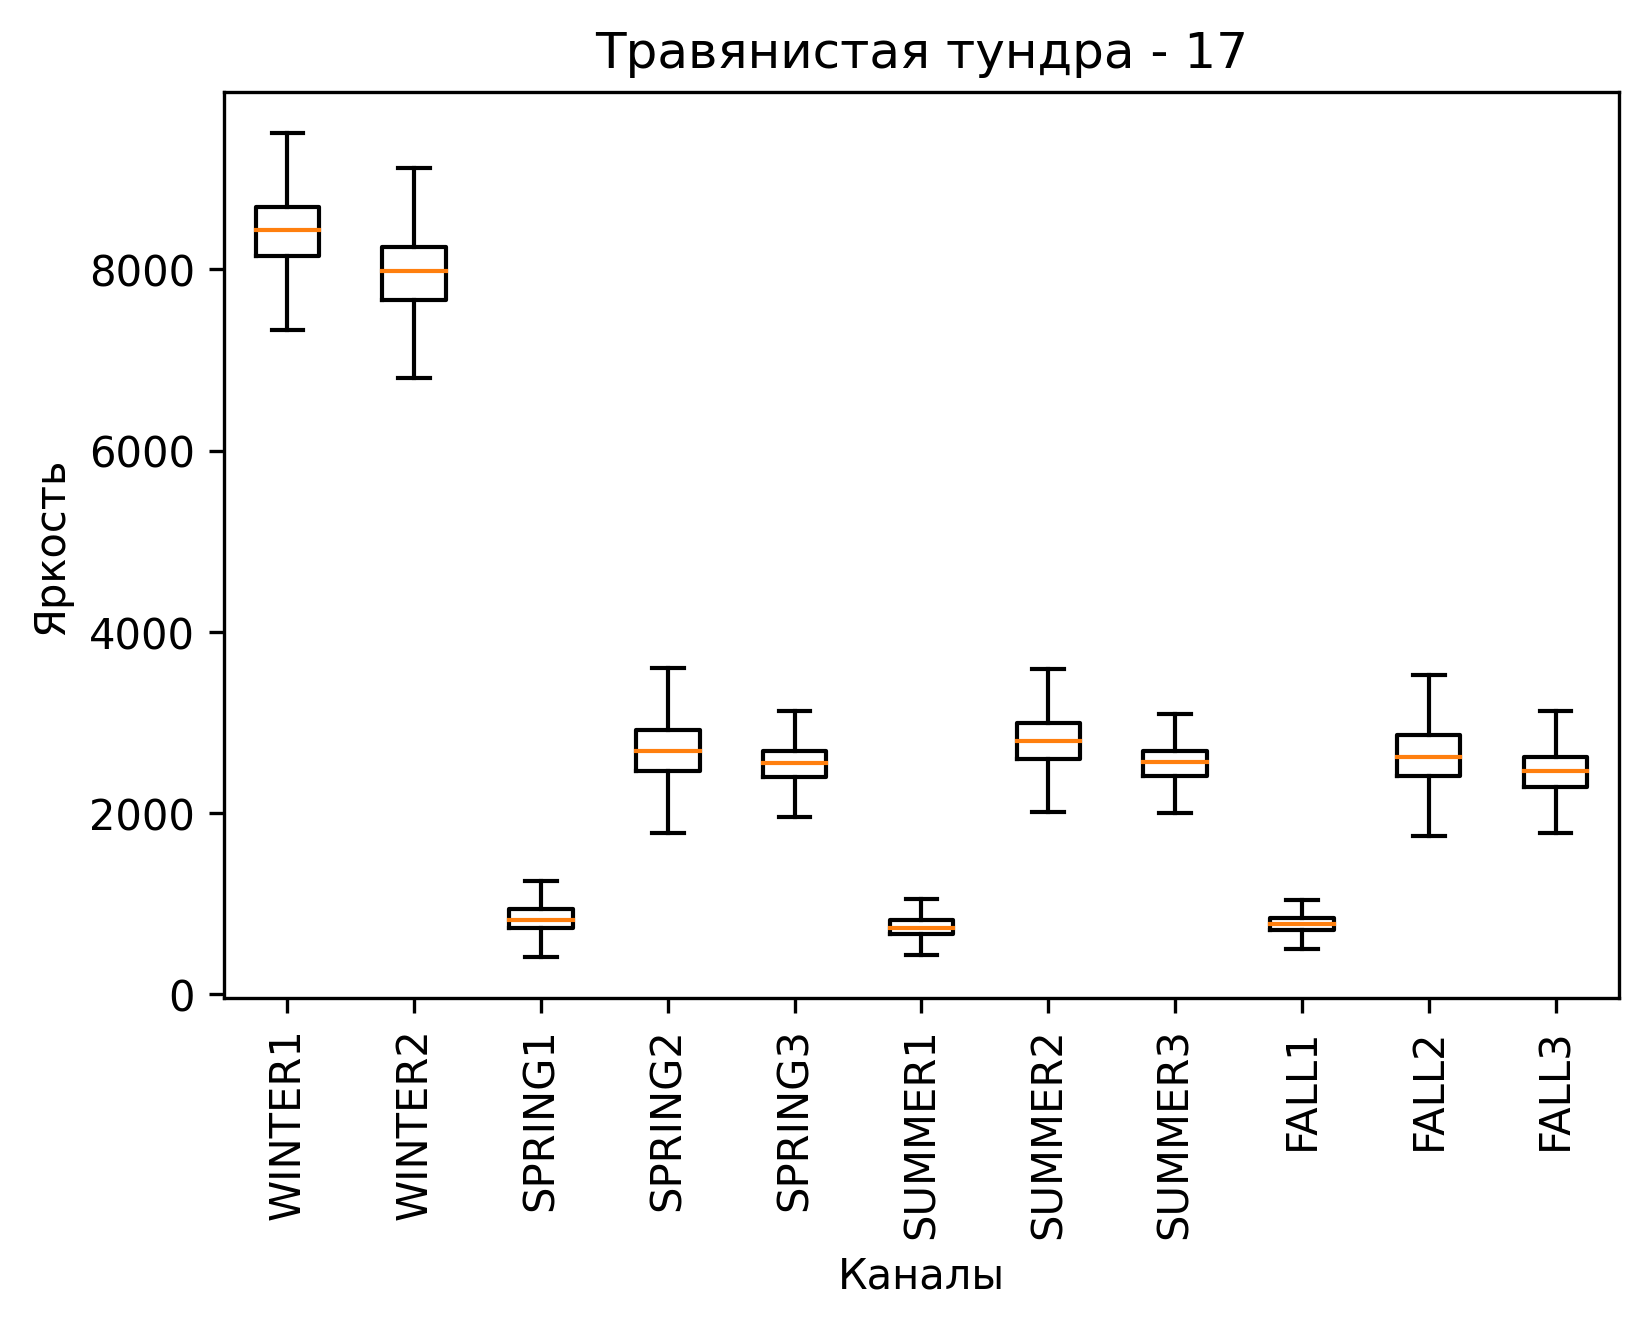

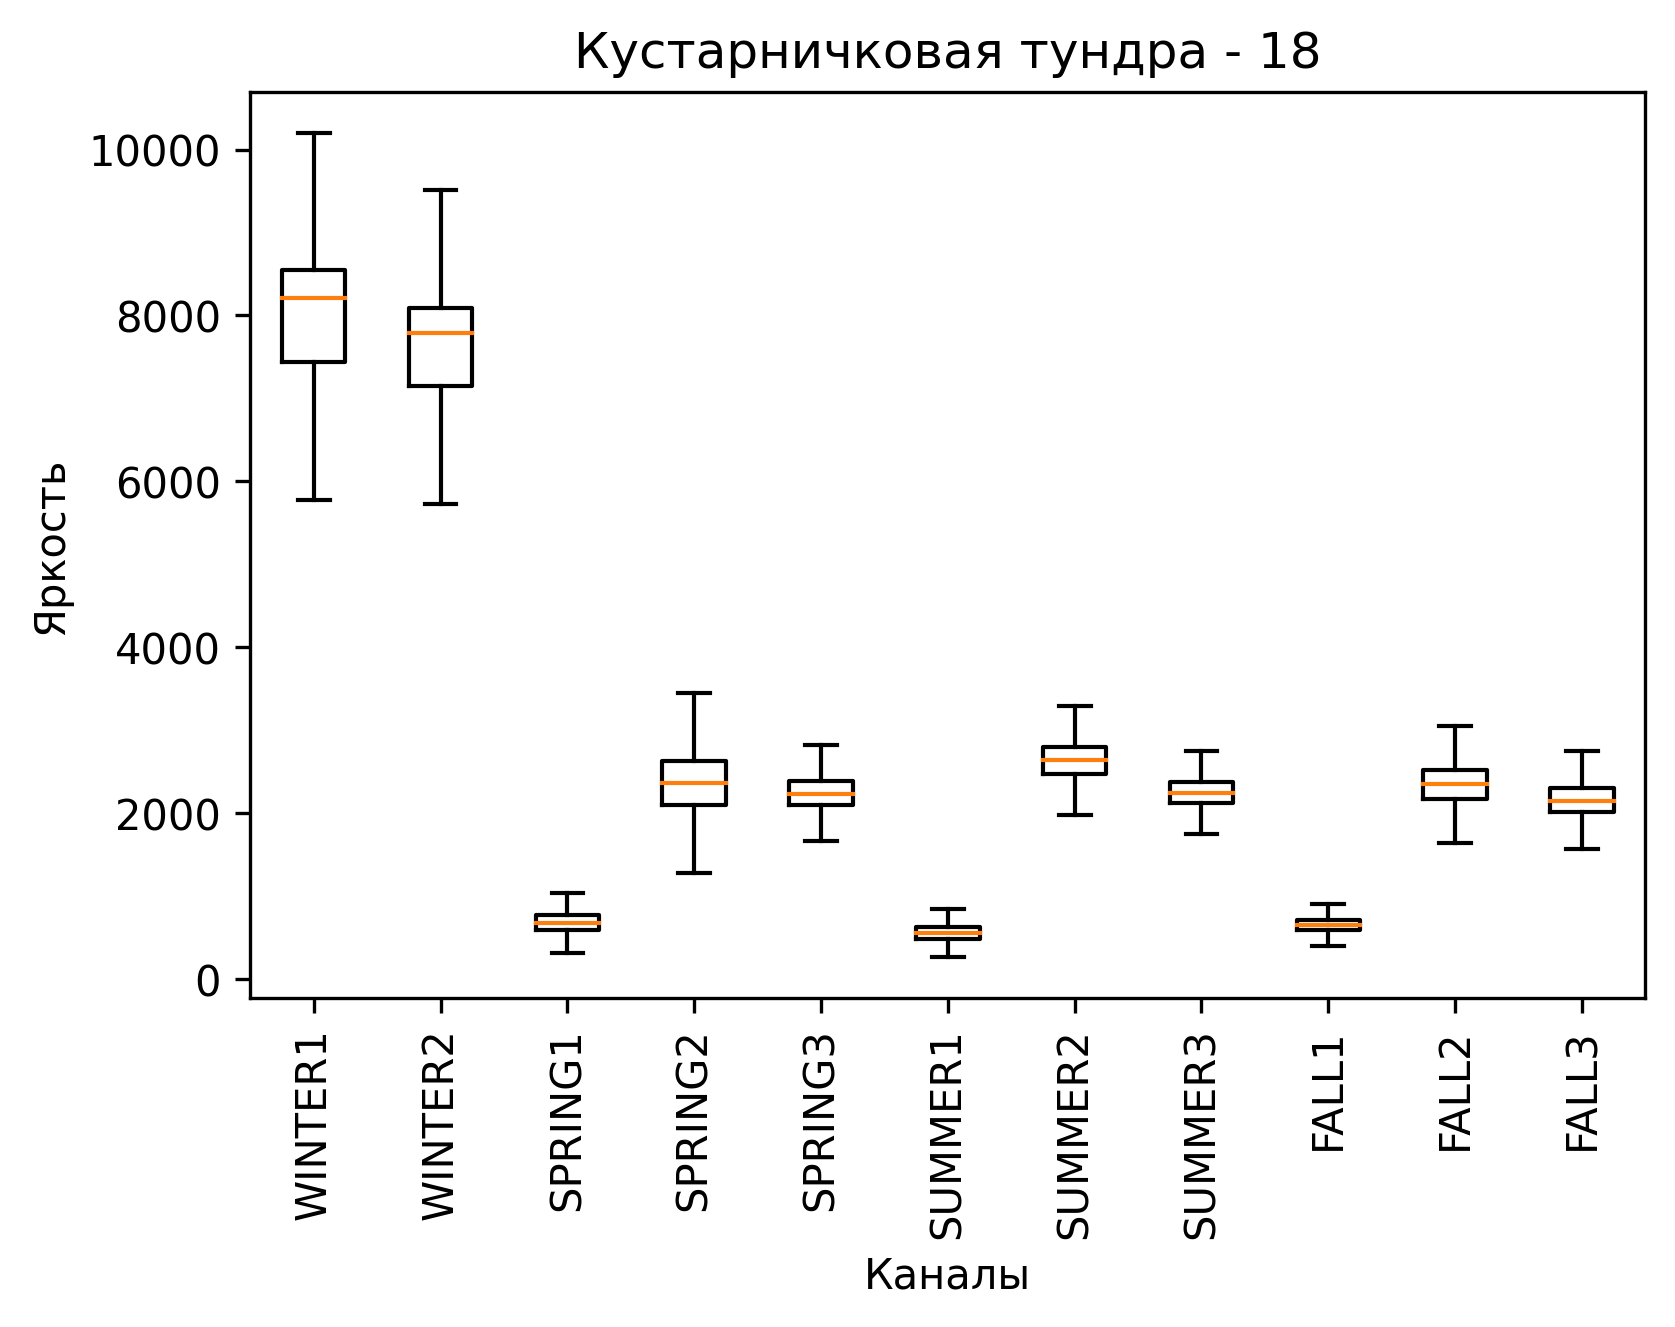

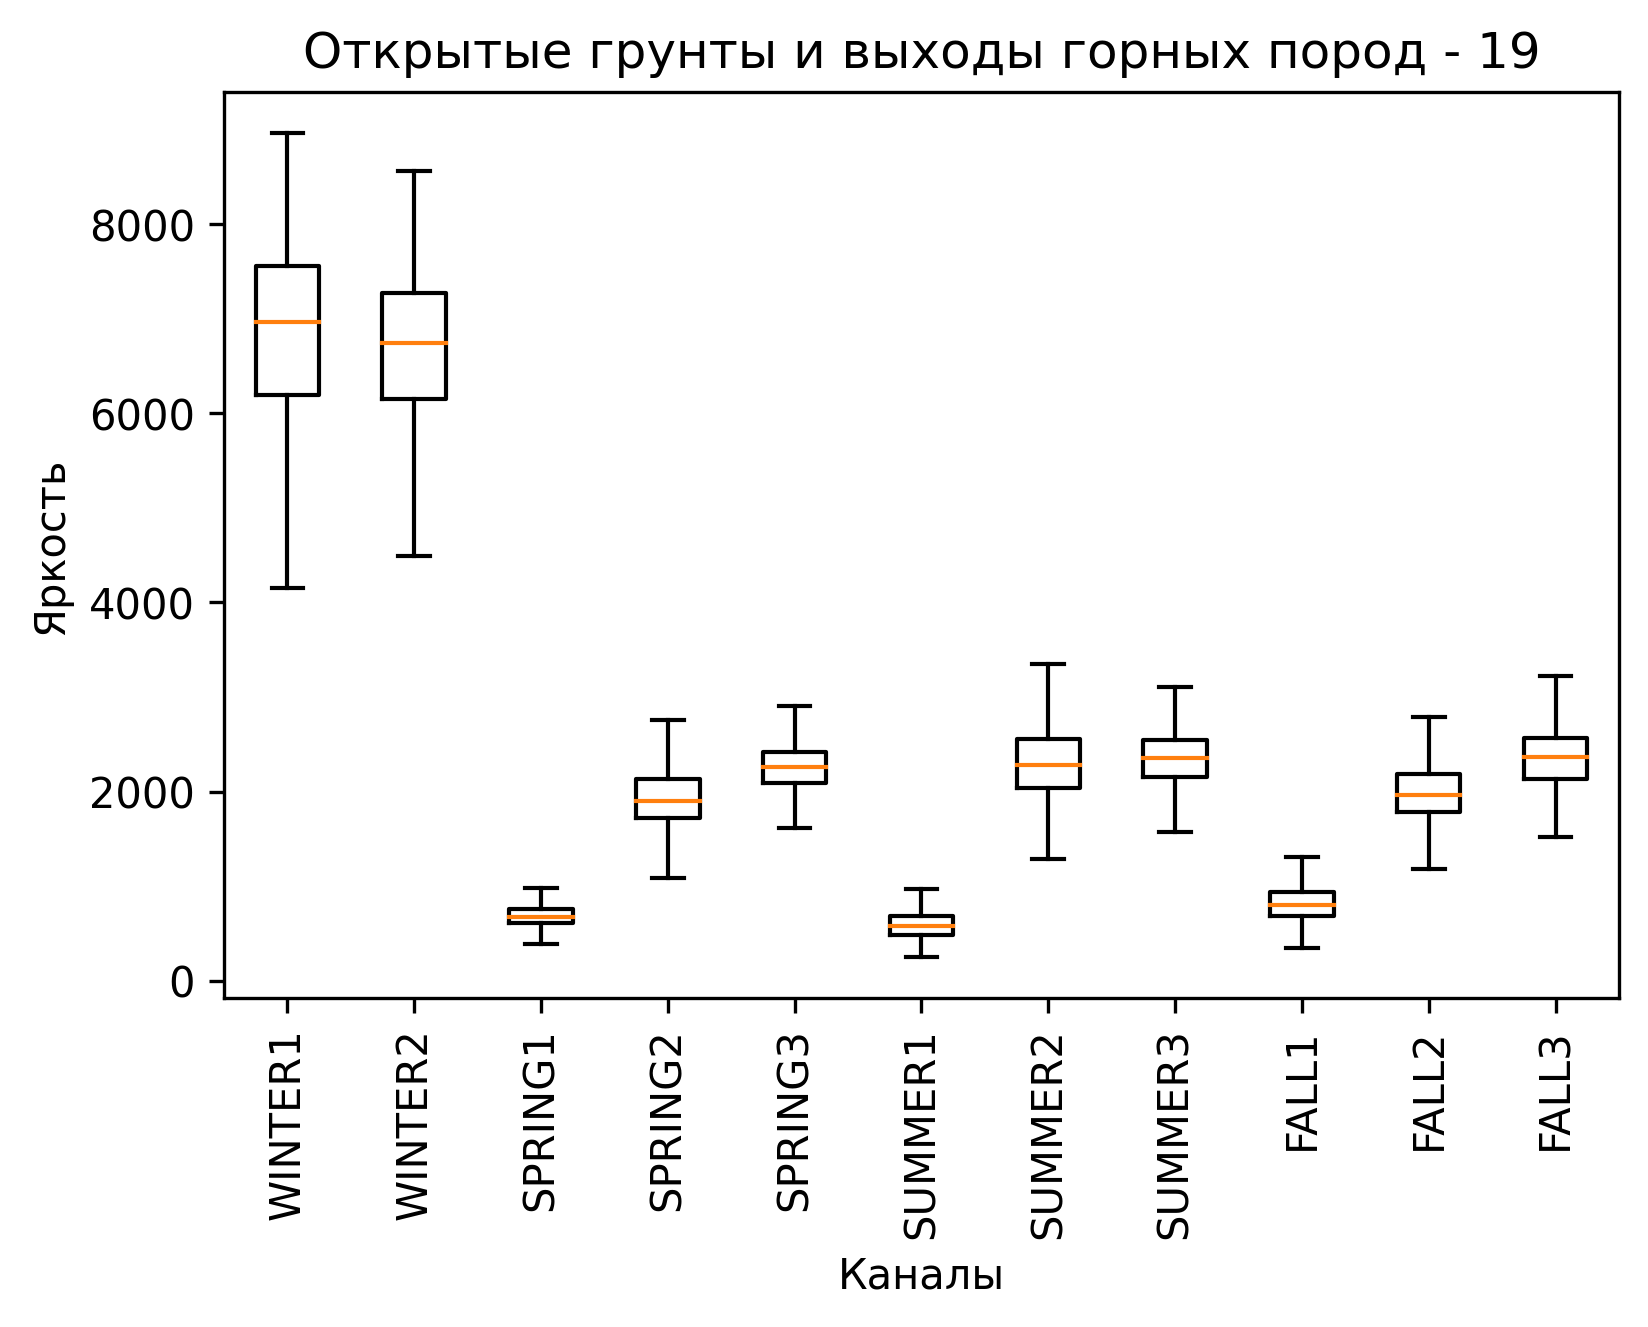

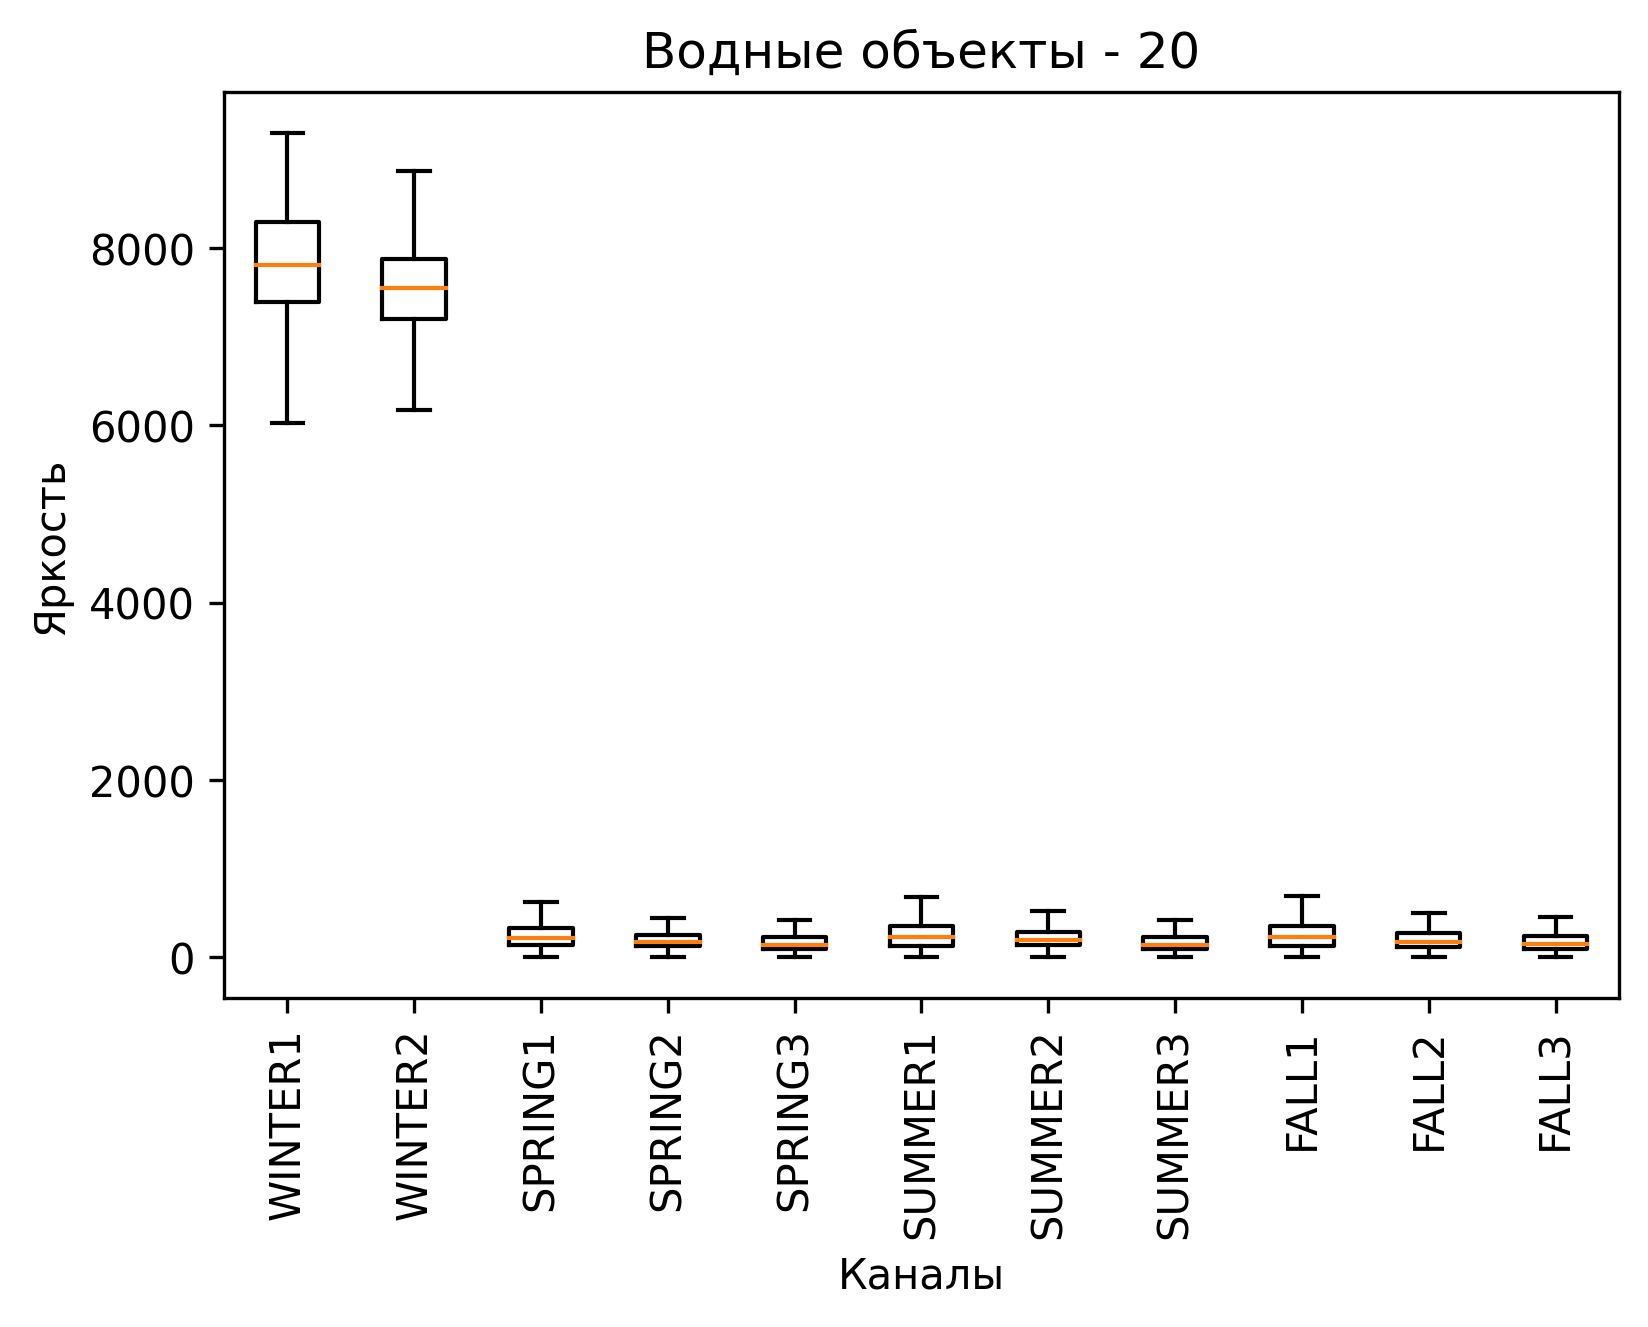

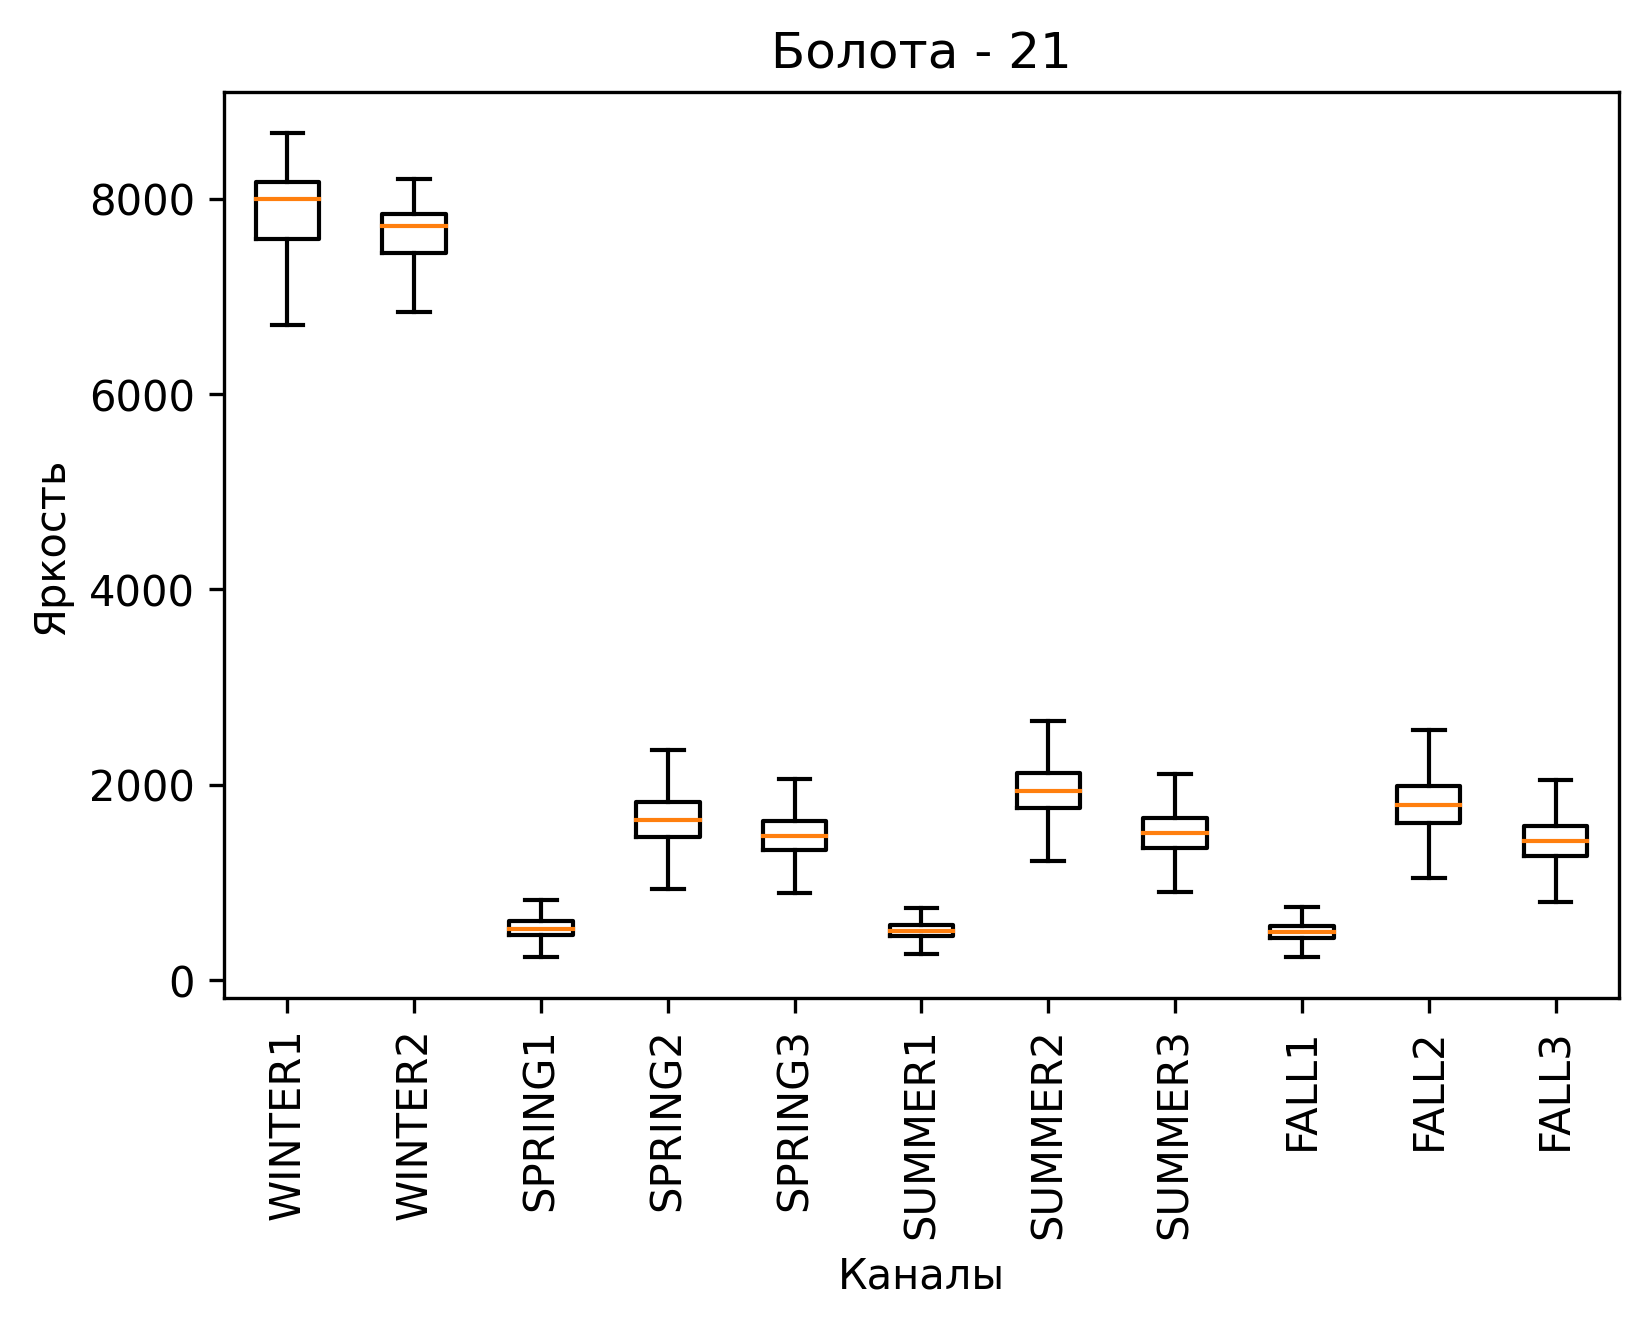

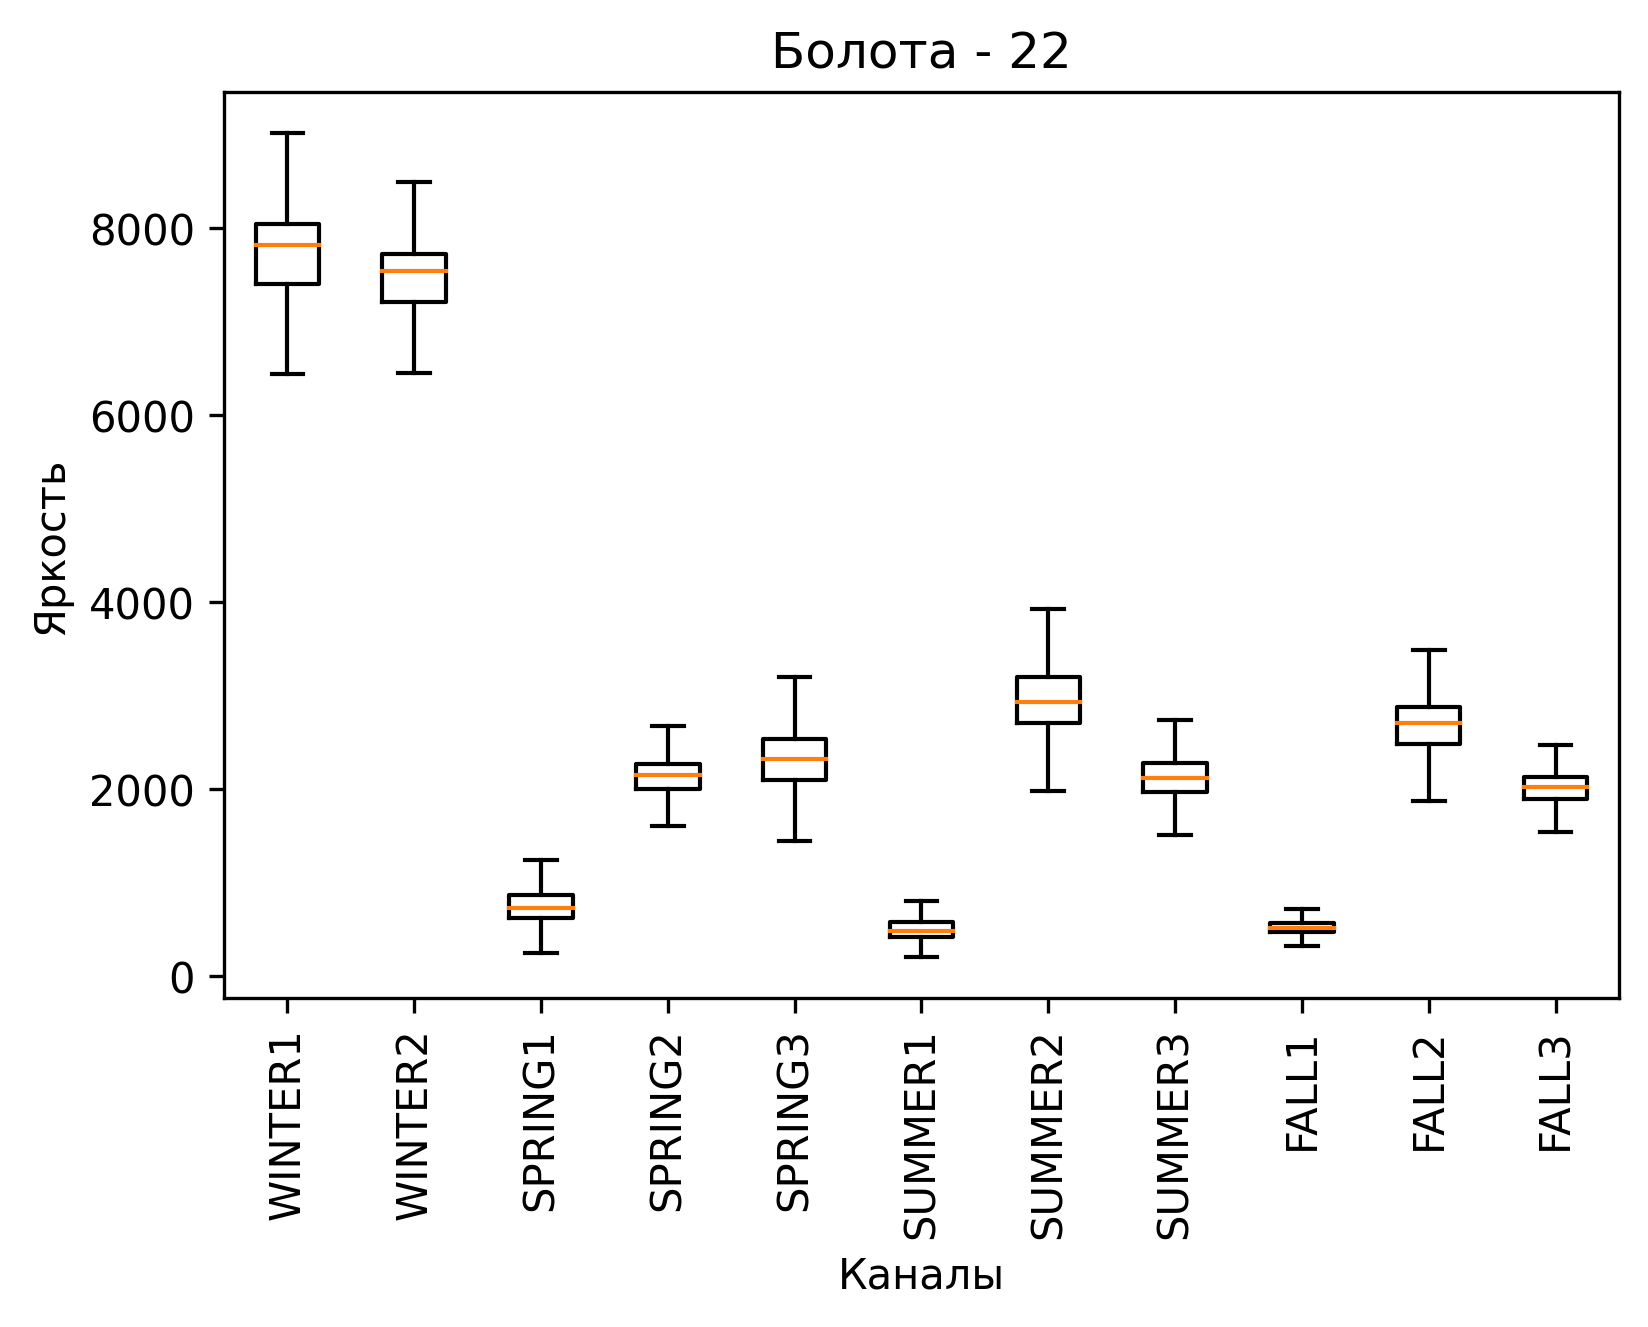

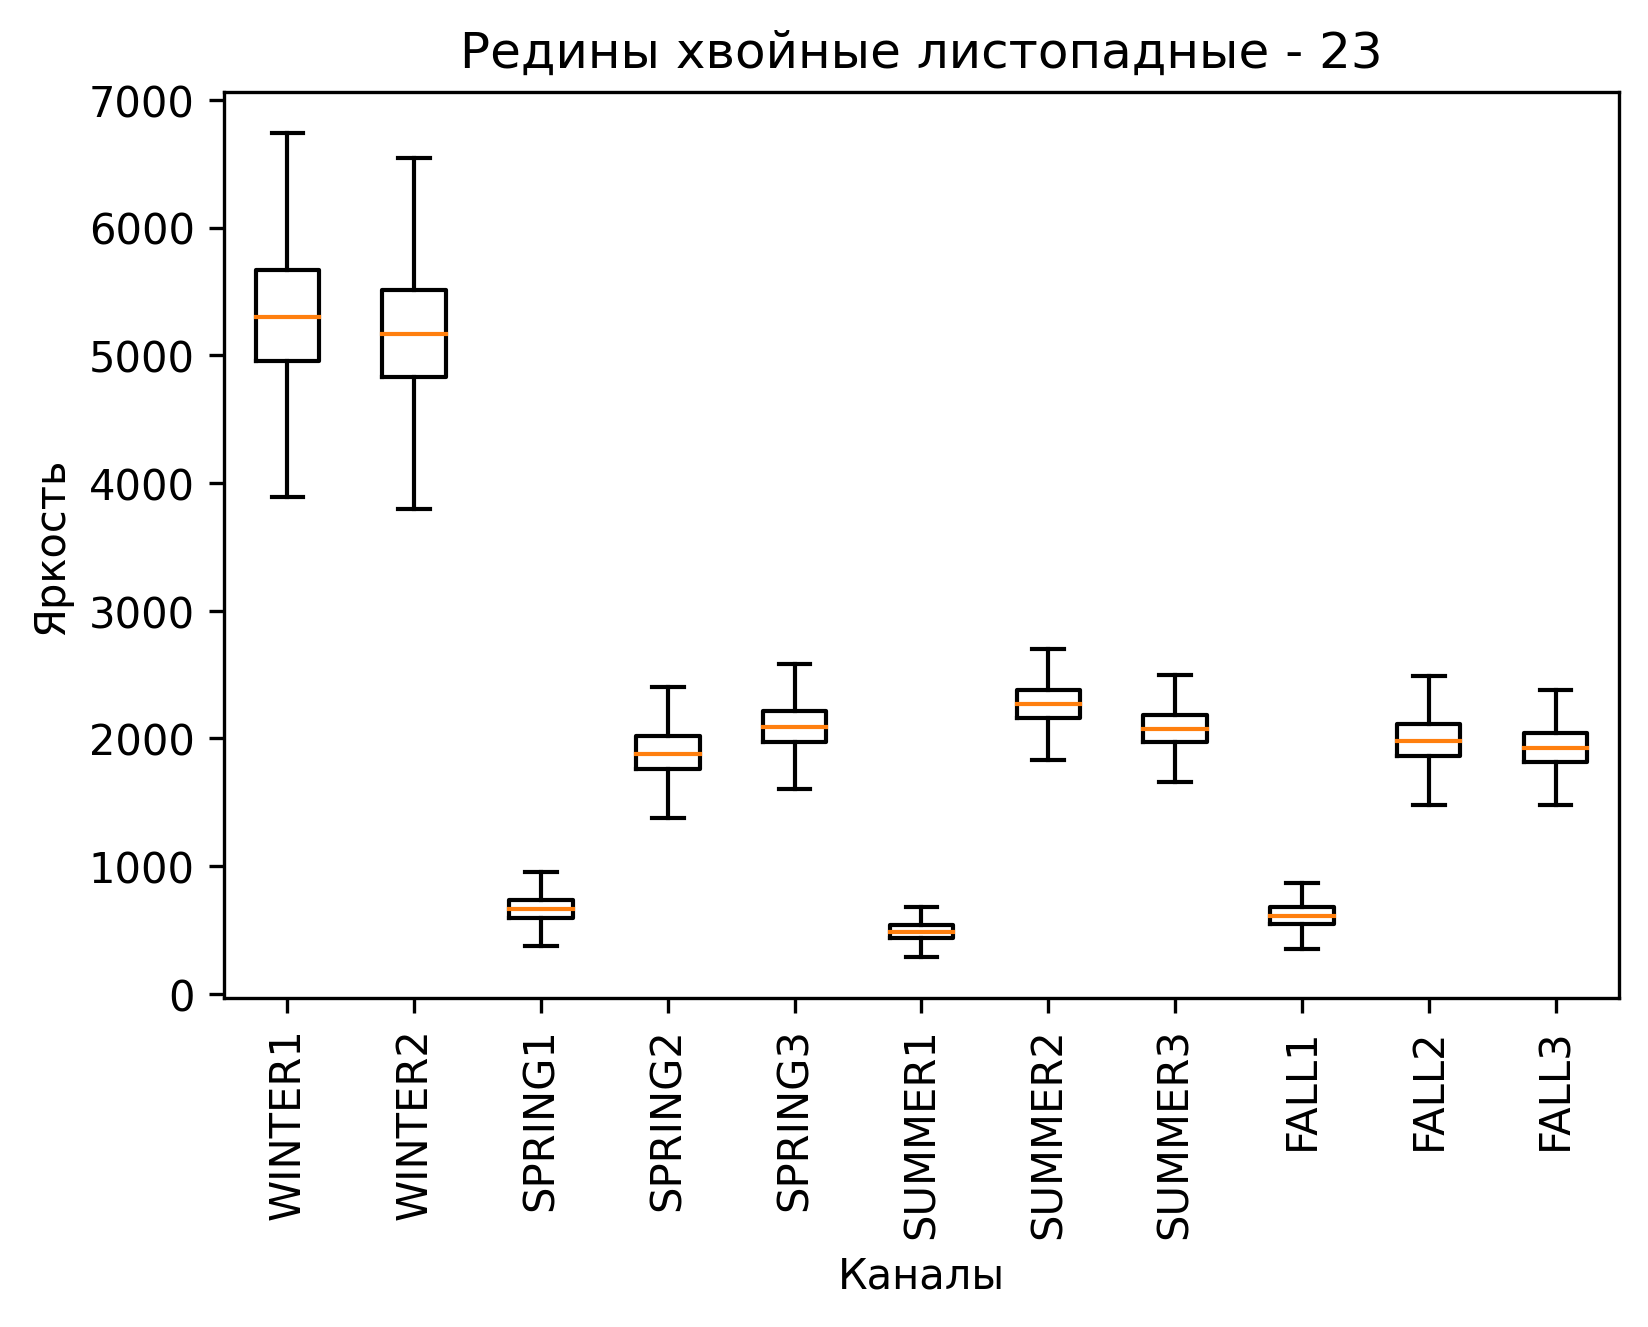

CPU times: total: 9min 25s
Wall time: 2h 6min 3s


In [63]:
%%time

# spread = np.random.rand(50) * 100
# center = np.ones(25) * 40
# flier_high = np.random.rand(10) * 100 + 100
# flier_low = np.random.rand(10) * -100
# data = np.concatenate((spread, center, flier_high, flier_low))

# data = [data, data, data[::2]]
for class_id in classes_legend:
    class_name = classes_legend[class_id]
    data = data_vaex[data_vaex["CLASS"] == class_id][brightness_column_names]
    fig, ax = plt.subplots(dpi=300)
    ax.boxplot(data, showfliers=False)
    ax.set_title(f'{class_name} - {class_id}')
    ax.set(xlabel='Каналы', ylabel='Яркость')
    plt.xticks(list(range(1, len(brightness_column_names) + 1)), brightness_column_names, rotation = 90)

    plt.show()

##### Объединение одинаковых классов

In [52]:
def get_class_first_id(class_id: int) -> int:
    """Returns first id of class.

    Parameters
    ----------
    class_id : int
        Id of class.

    Returns
    -------
    int
        First id of class.
    """
    ids_list = [classes_summary[class_name]['id'] for class_name in classes_summary]

    for ids in ids_list:
        if class_id in ids:
            return ids[0]

In [65]:
%%time

data_vaex["CLASS_ID"] = data_vaex.apply(get_class_first_id, arguments=[data_vaex["CLASS"]])

train_data_vaex["CLASS_ID"] = train_data_vaex.apply(get_class_first_id, arguments=[train_data_vaex["CLASS"]])

CPU times: total: 0 ns
Wall time: 8.98 ms


##### Визуализация

In [122]:
coordinates_column_names = data_vaex.column_names[1:3]
brightness_column_names = data_vaex.column_names[3:14]
brightness_column_names_representation = [
    'Зима, RED',
    'Зима, NIR',
    'Весна, RED',
    'Весна, NIR',
    'Весна, SWIR',
    'Лето, RED',
    'Лето, NIR',
    'Лето, SWIR',
    'Осень, RED',
    'Осень, NIR',
    'Осень, SWIR'
]

In [123]:
def render_class_boxplot(class_name: str) -> None:
    class_id = classes_summary[class_name]['id'][0]
    data = data_vaex[data_vaex["CLASS_ID"] == class_id][brightness_column_names]
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    ax.set_title(f'{class_name}')
    ax.set(xlabel='Каналы', ylabel='Яркость')
    ax.boxplot(data, showfliers=False)
    plt.xticks(list(range(1, len(brightness_column_names) + 1)), brightness_column_names_representation, rotation = 90)
    plt.savefig(f"text/images/class_{class_id}_boxplot.png", bbox_inches="tight", pad_inches=0)
    plt.show()

def render_class_map(class_name: str) -> None:
    class_id = classes_summary[class_name]['id'][0]
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    plt.gca().invert_yaxis()
    ax.xaxis.tick_top()
    ax.set(xlabel='X', ylabel='Y')
    ax.xaxis.set_label_position('top')
    plt.title(class_name)
    
    other_classes = data_vaex[['X', 'Y', 'CLASS_ID']][data_vaex['CLASS_ID'] != class_id]
    plt.scatter(other_classes['X'].evaluate(), other_classes['Y'].evaluate(), c="silver", s=0.3)

    selected_class = data_vaex[['X', 'Y', 'CLASS_ID']][data_vaex['CLASS_ID'] == class_id]
    plt.scatter(selected_class['X'].evaluate(), selected_class['Y'].evaluate(), c="blue", s=0.3)
    plt.savefig(f"text/images/class_{class_id}_map.png", bbox_inches="tight", pad_inches=0)
    plt.show()

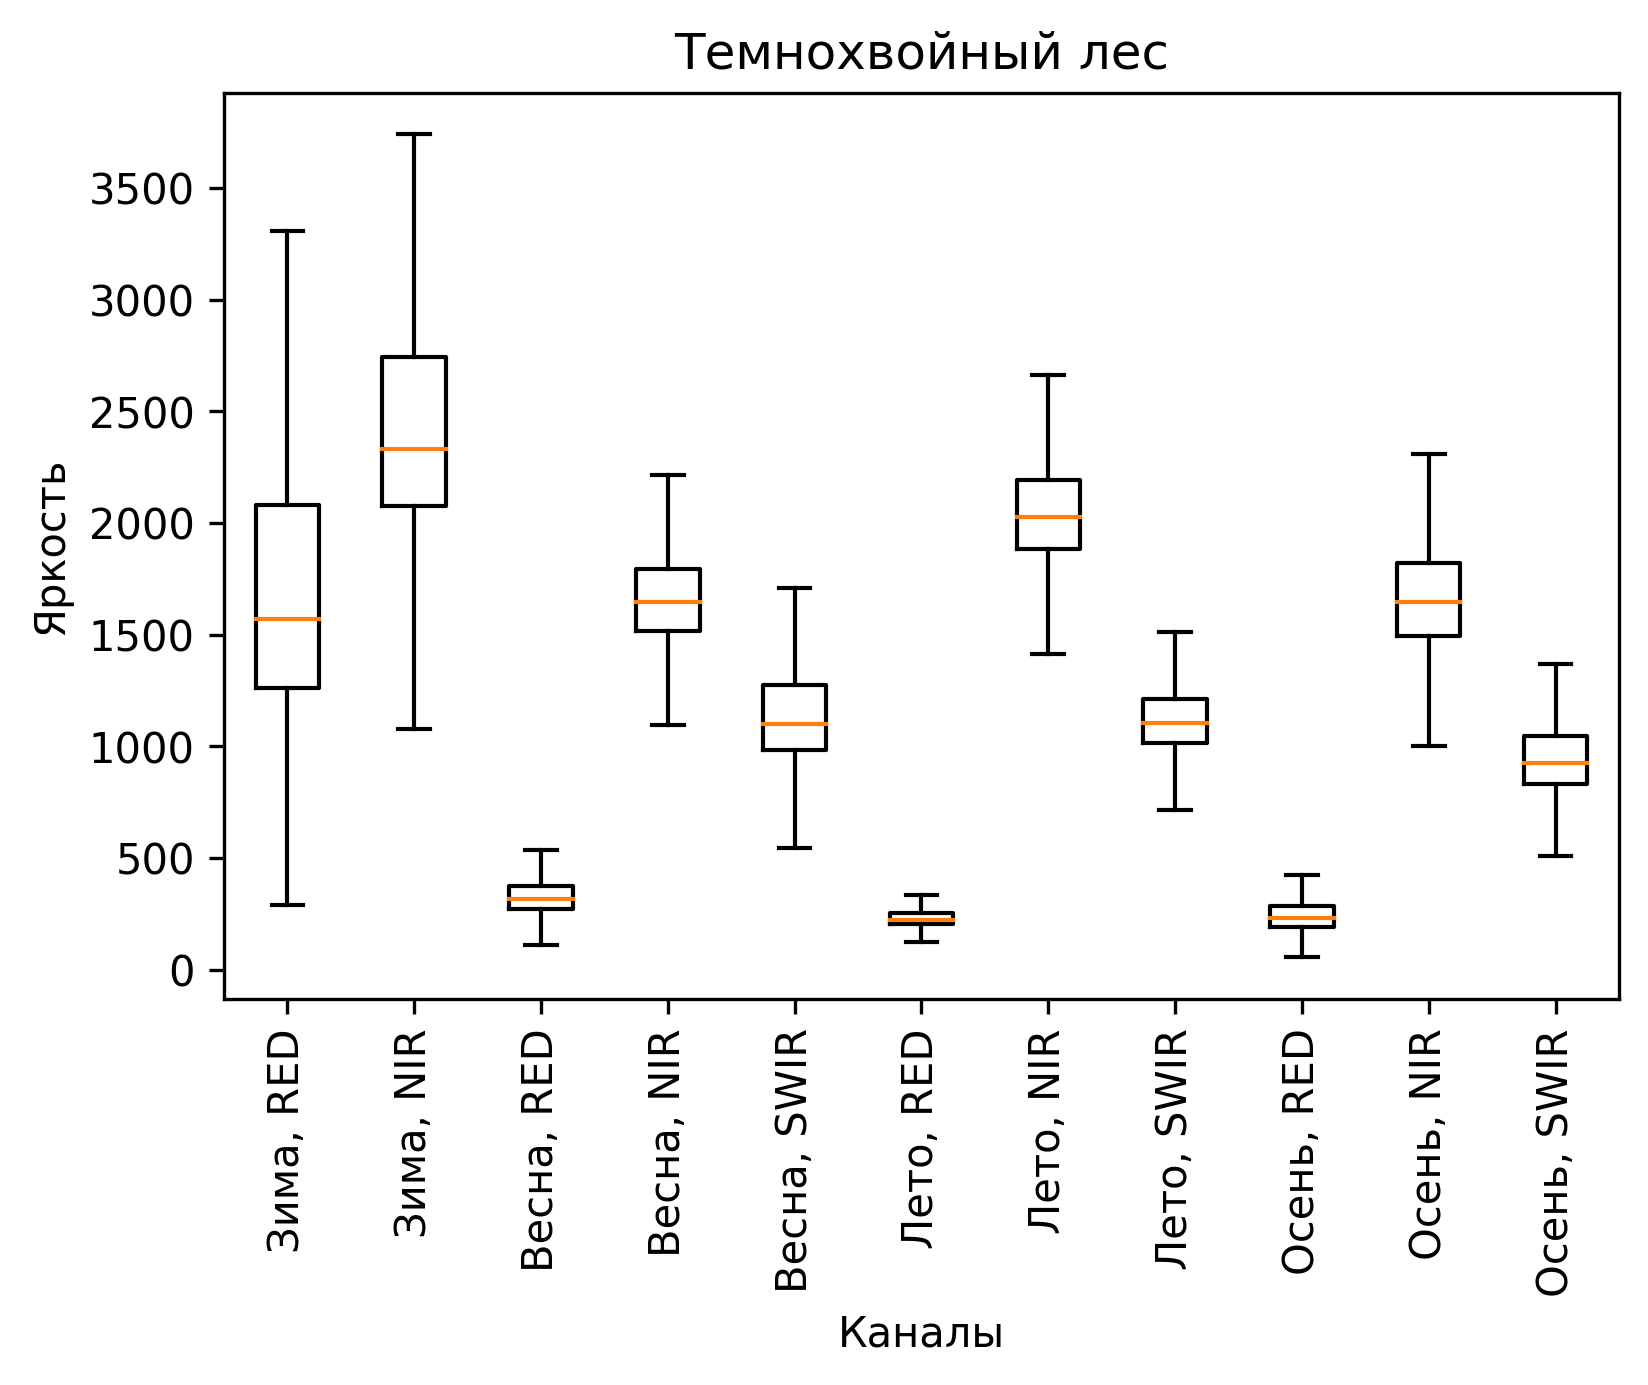

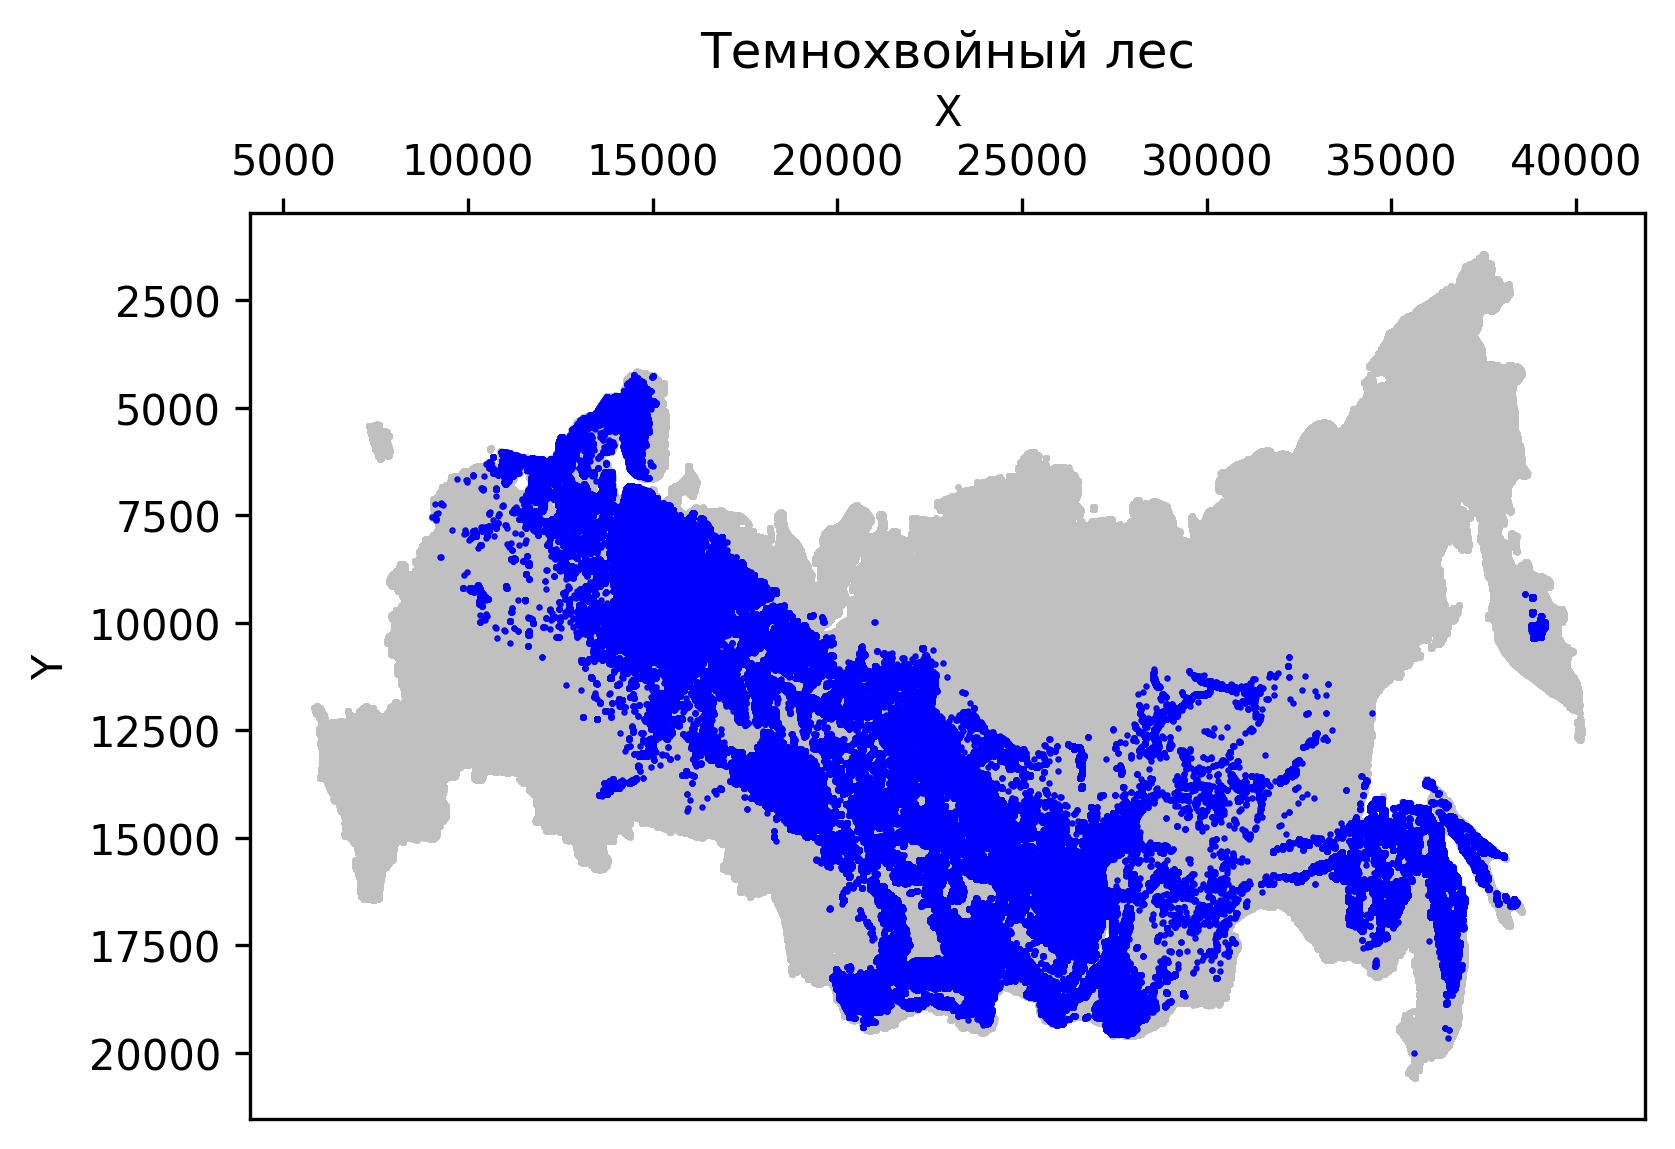

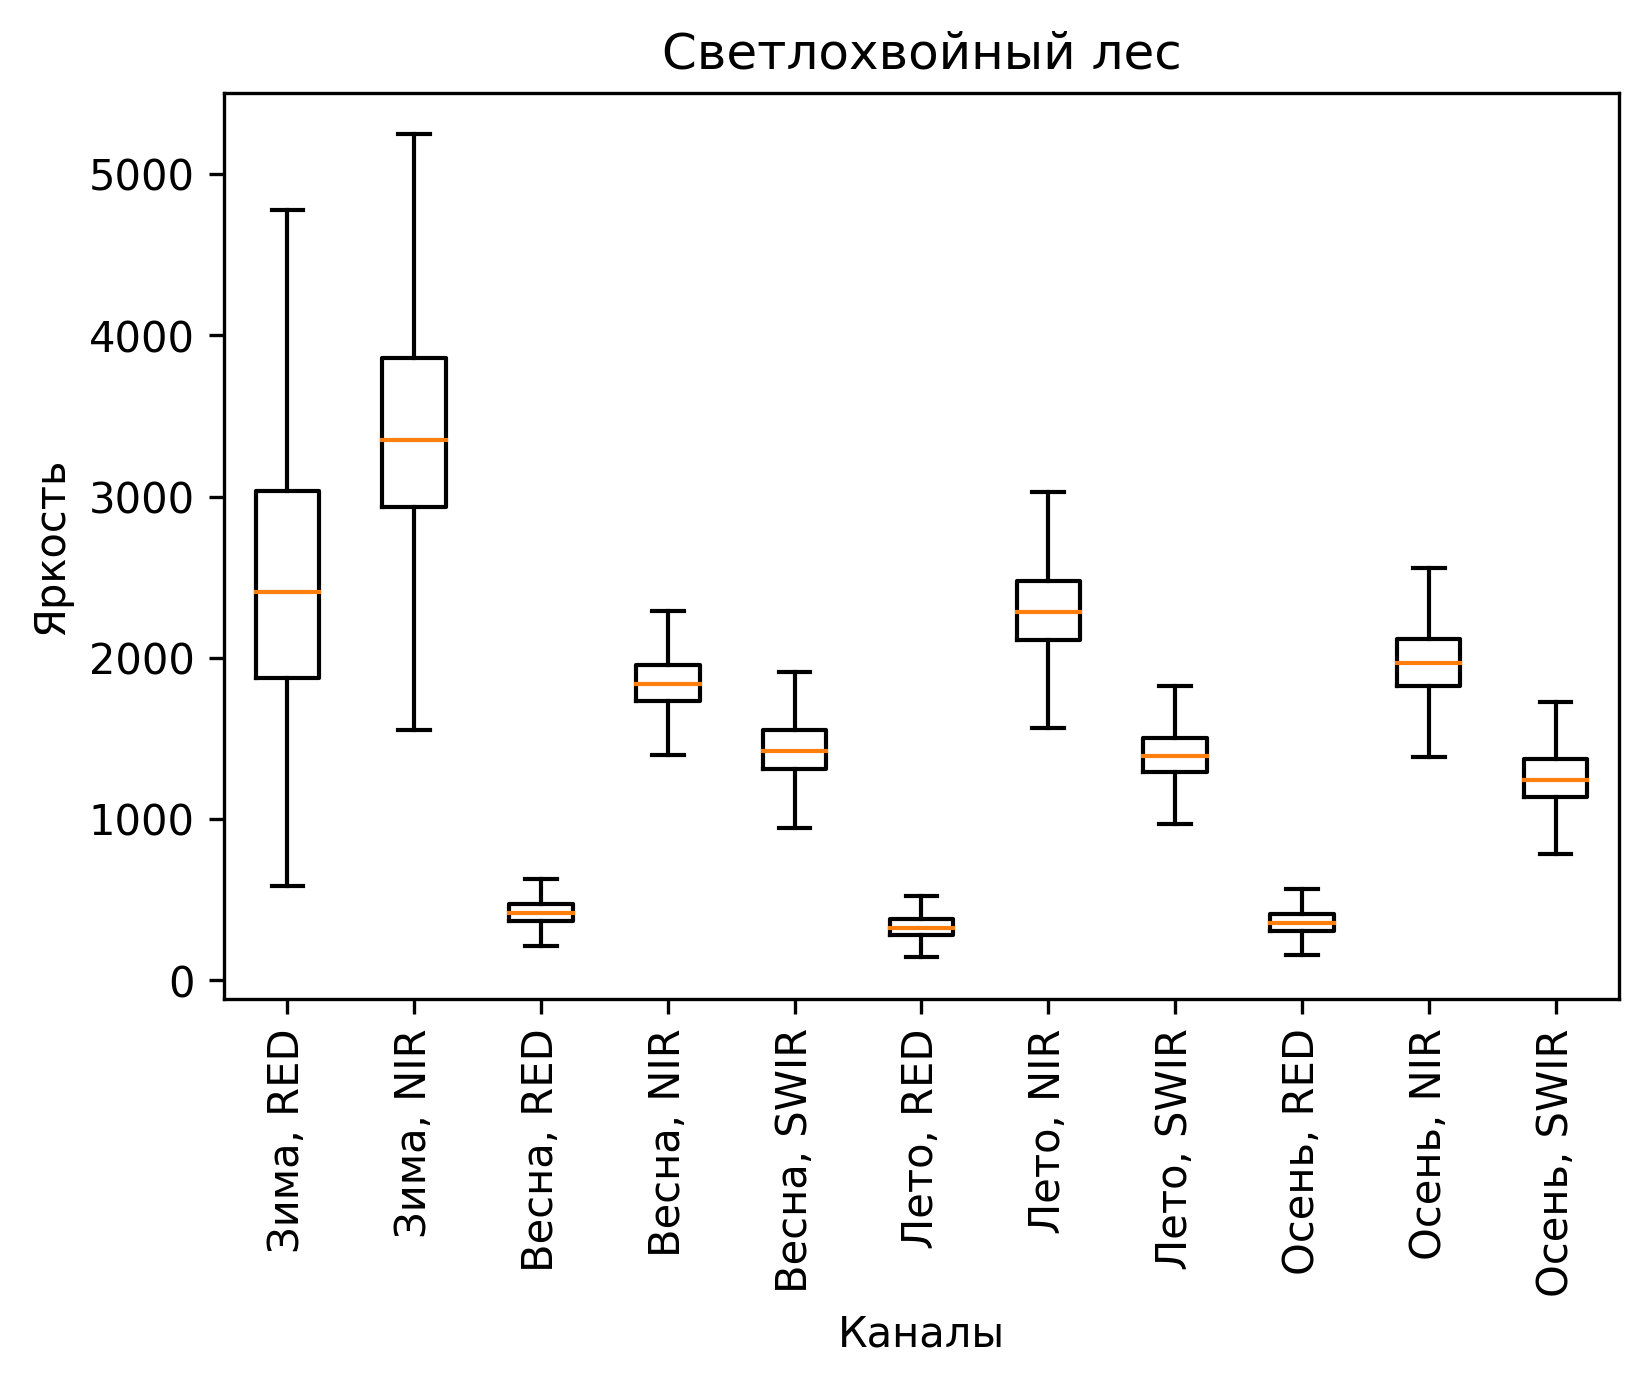

MemoryError: Unable to allocate 1.04 GiB for an array with shape (69528785, 2) and data type float64

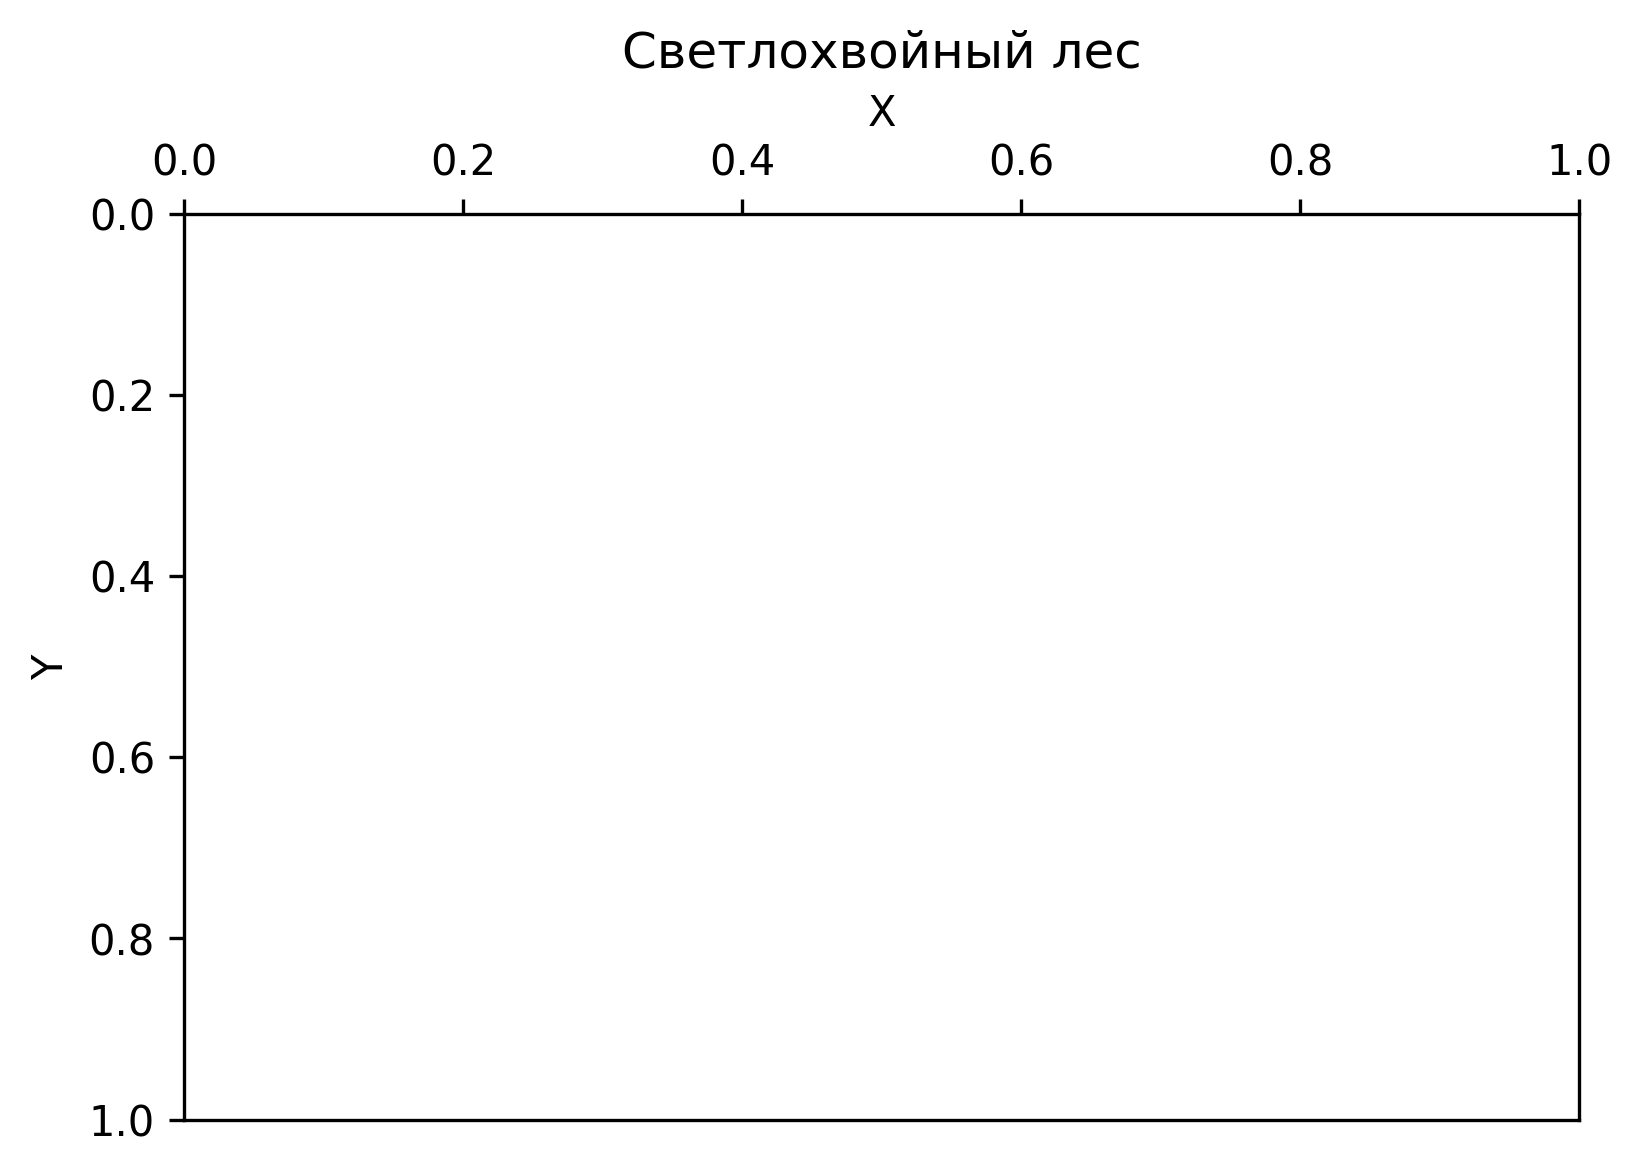

In [130]:
%%time

for class_name in classes_names[:7]:
    render_class_boxplot(class_name)
    render_class_map(class_name)

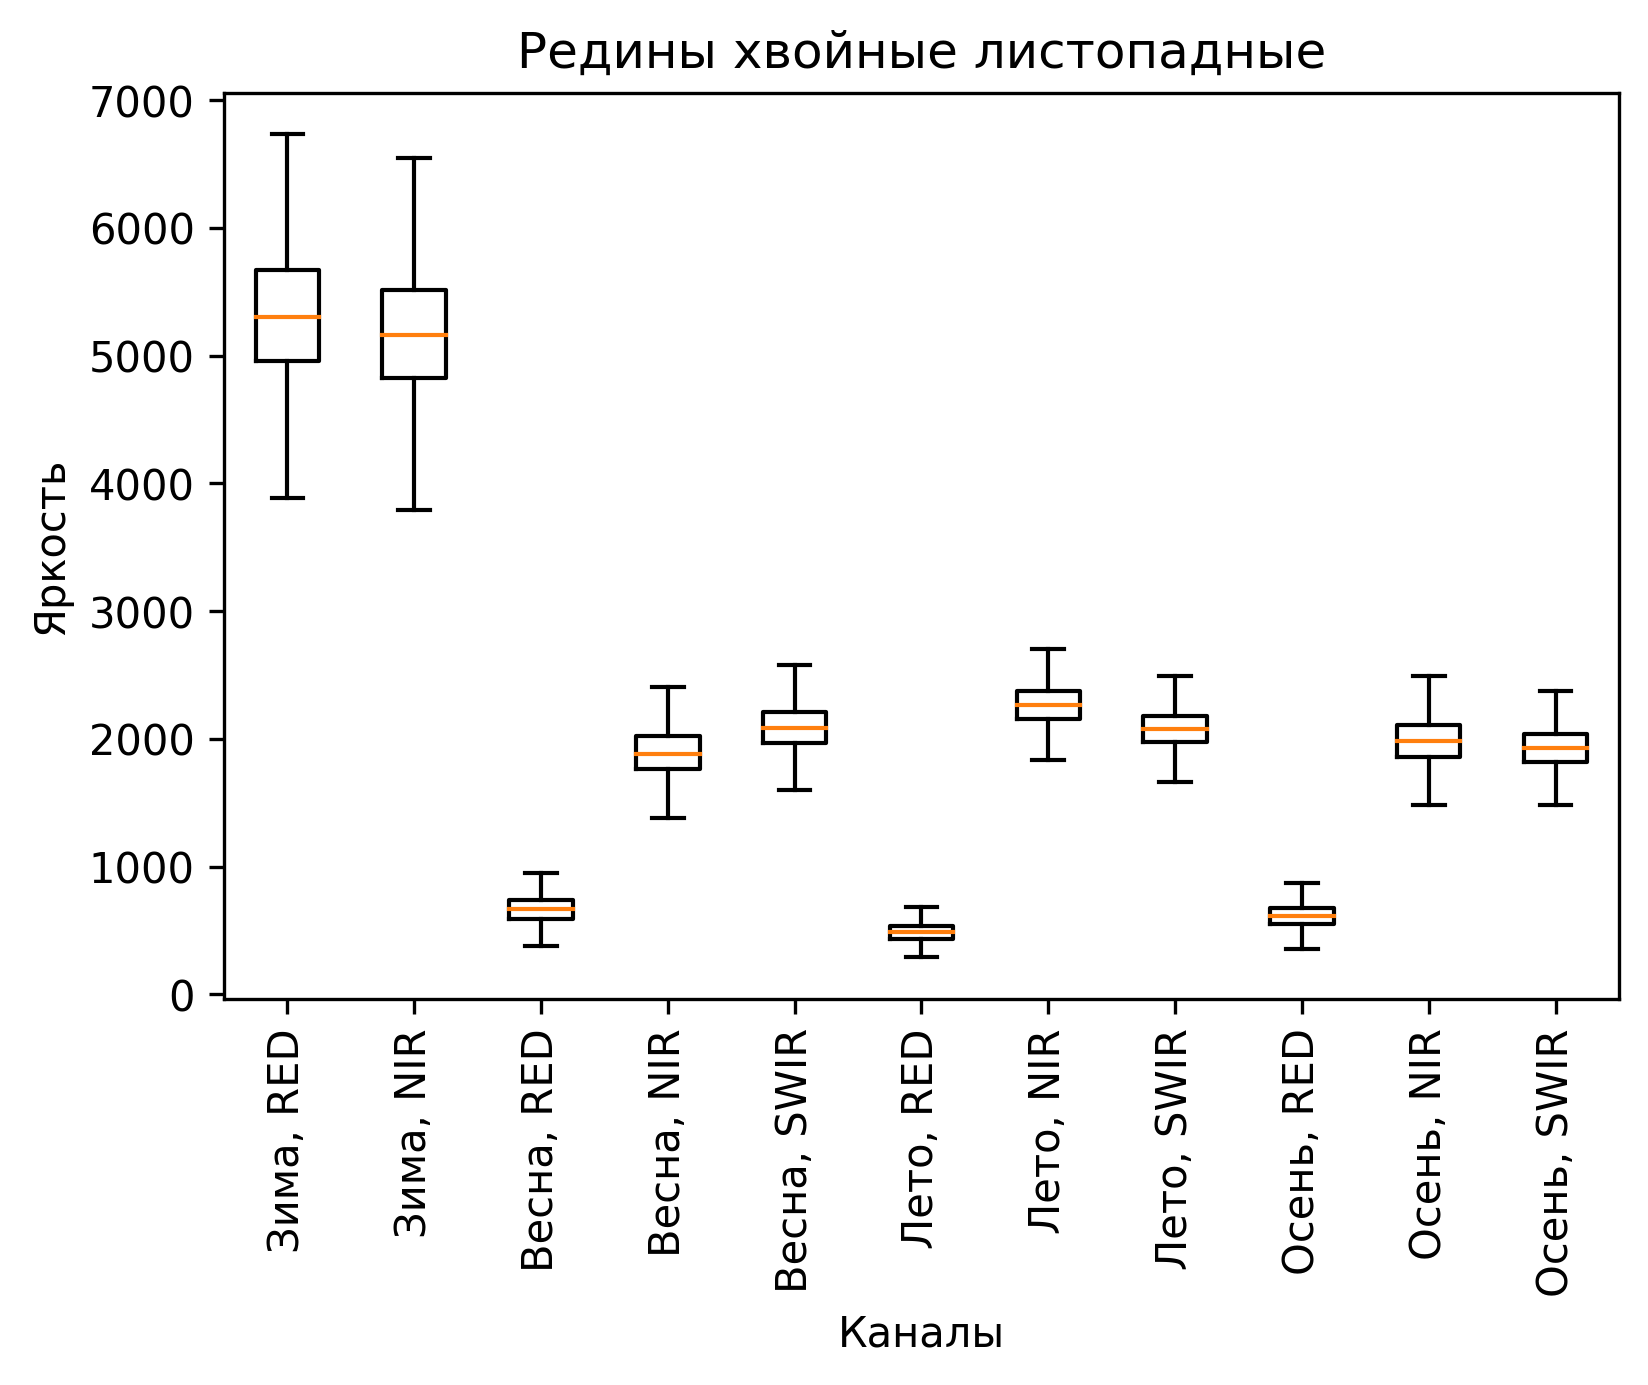

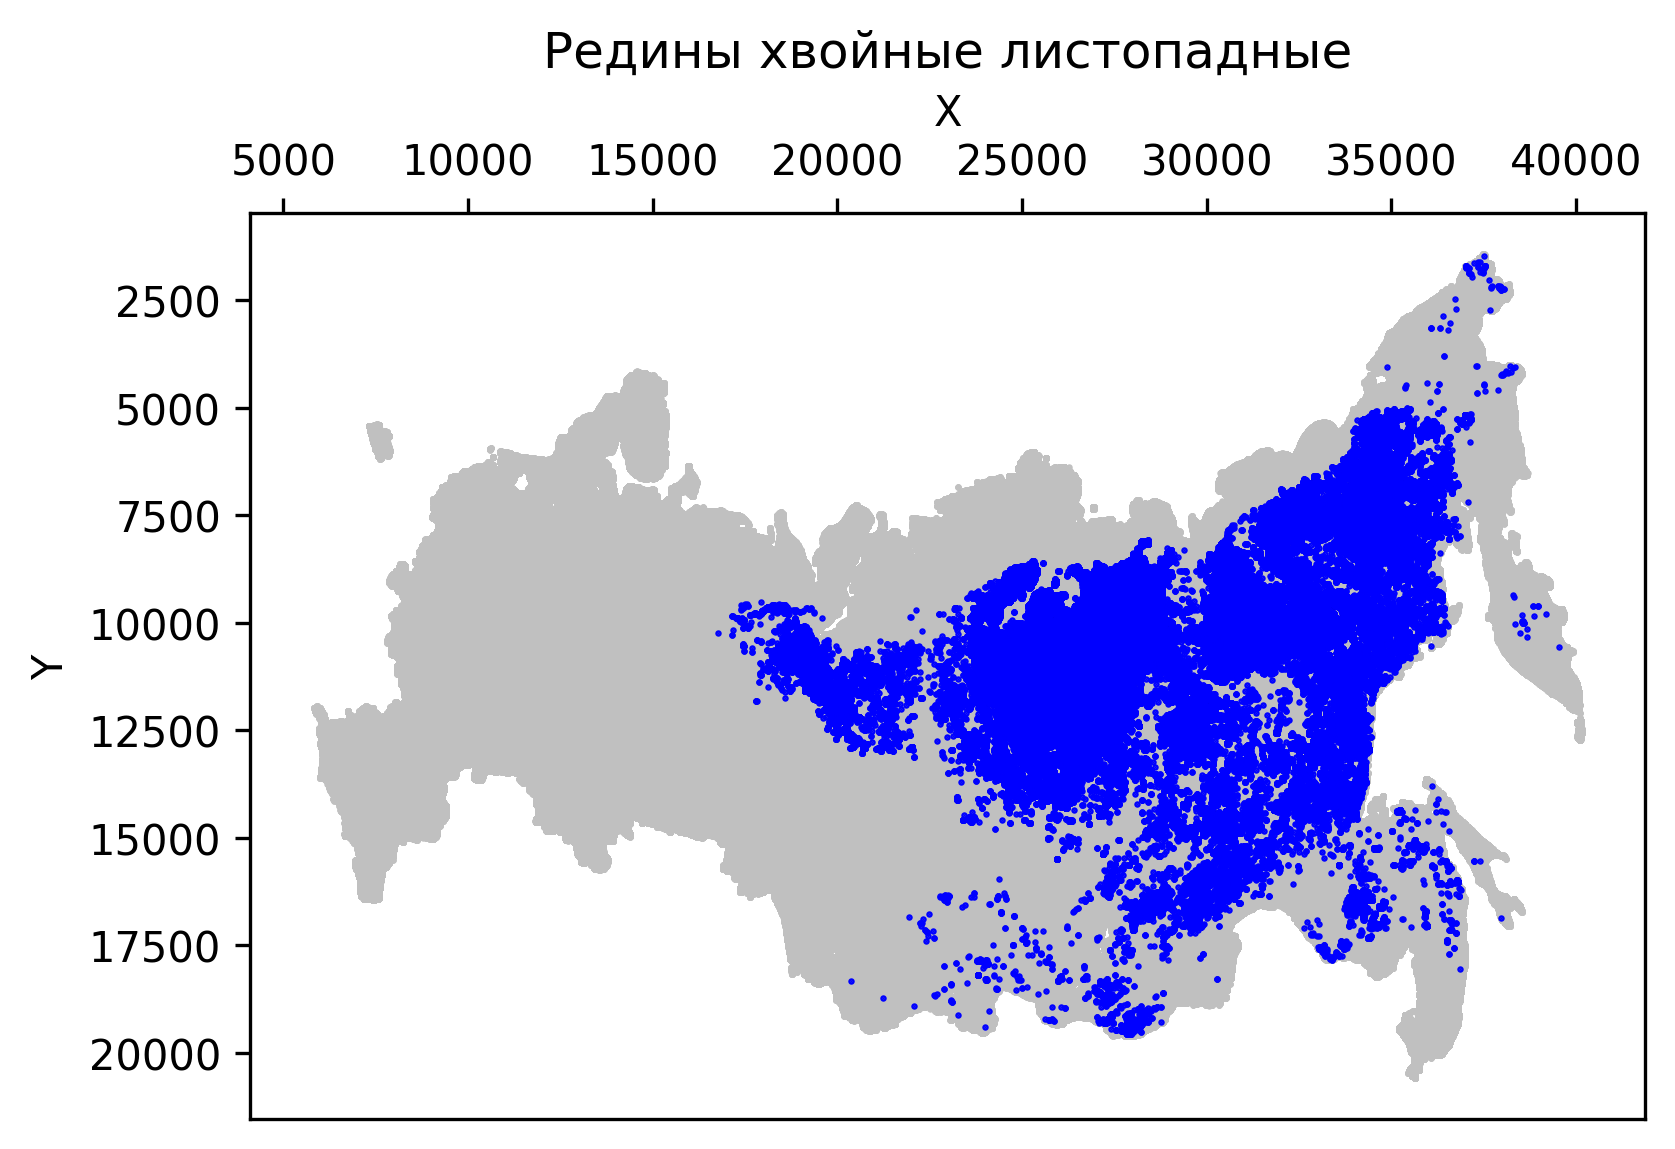

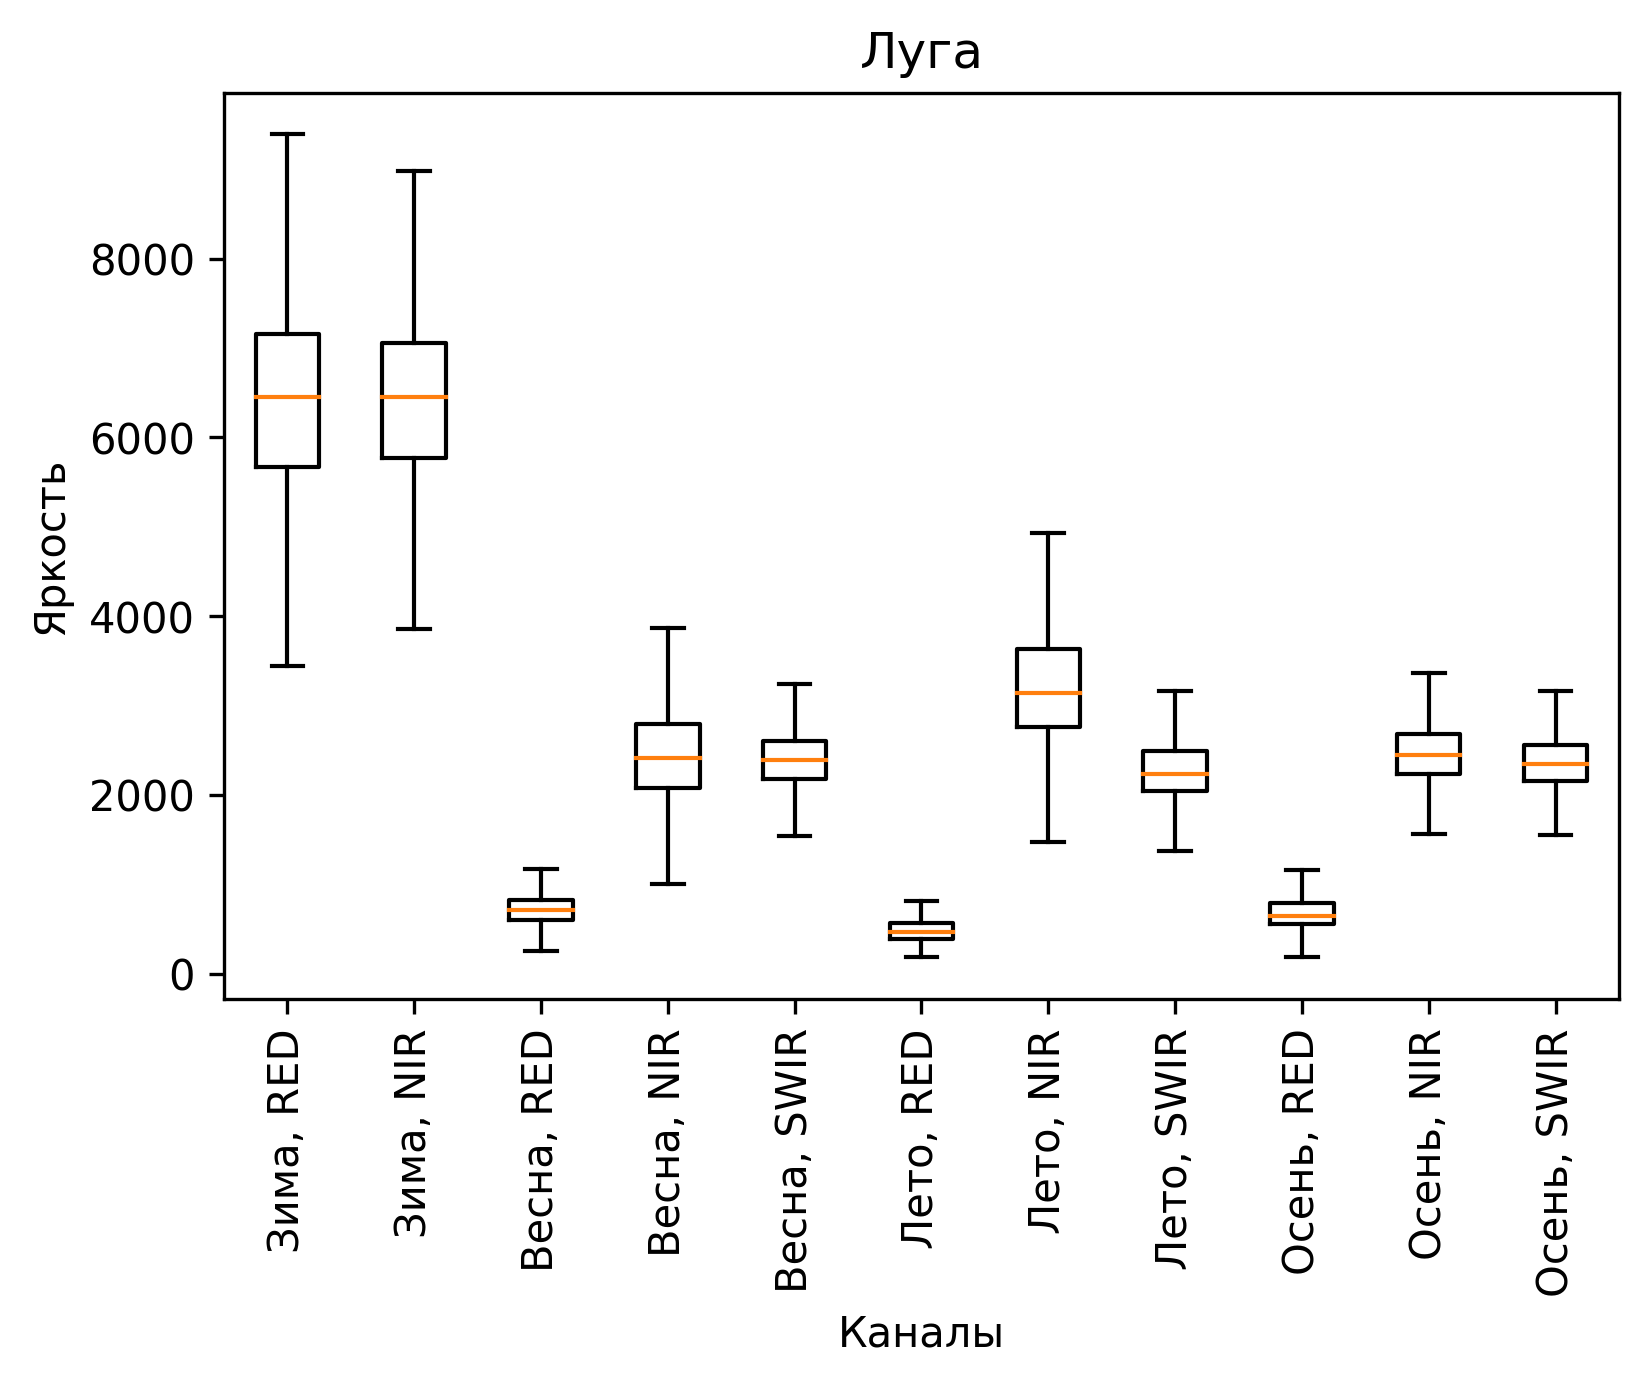

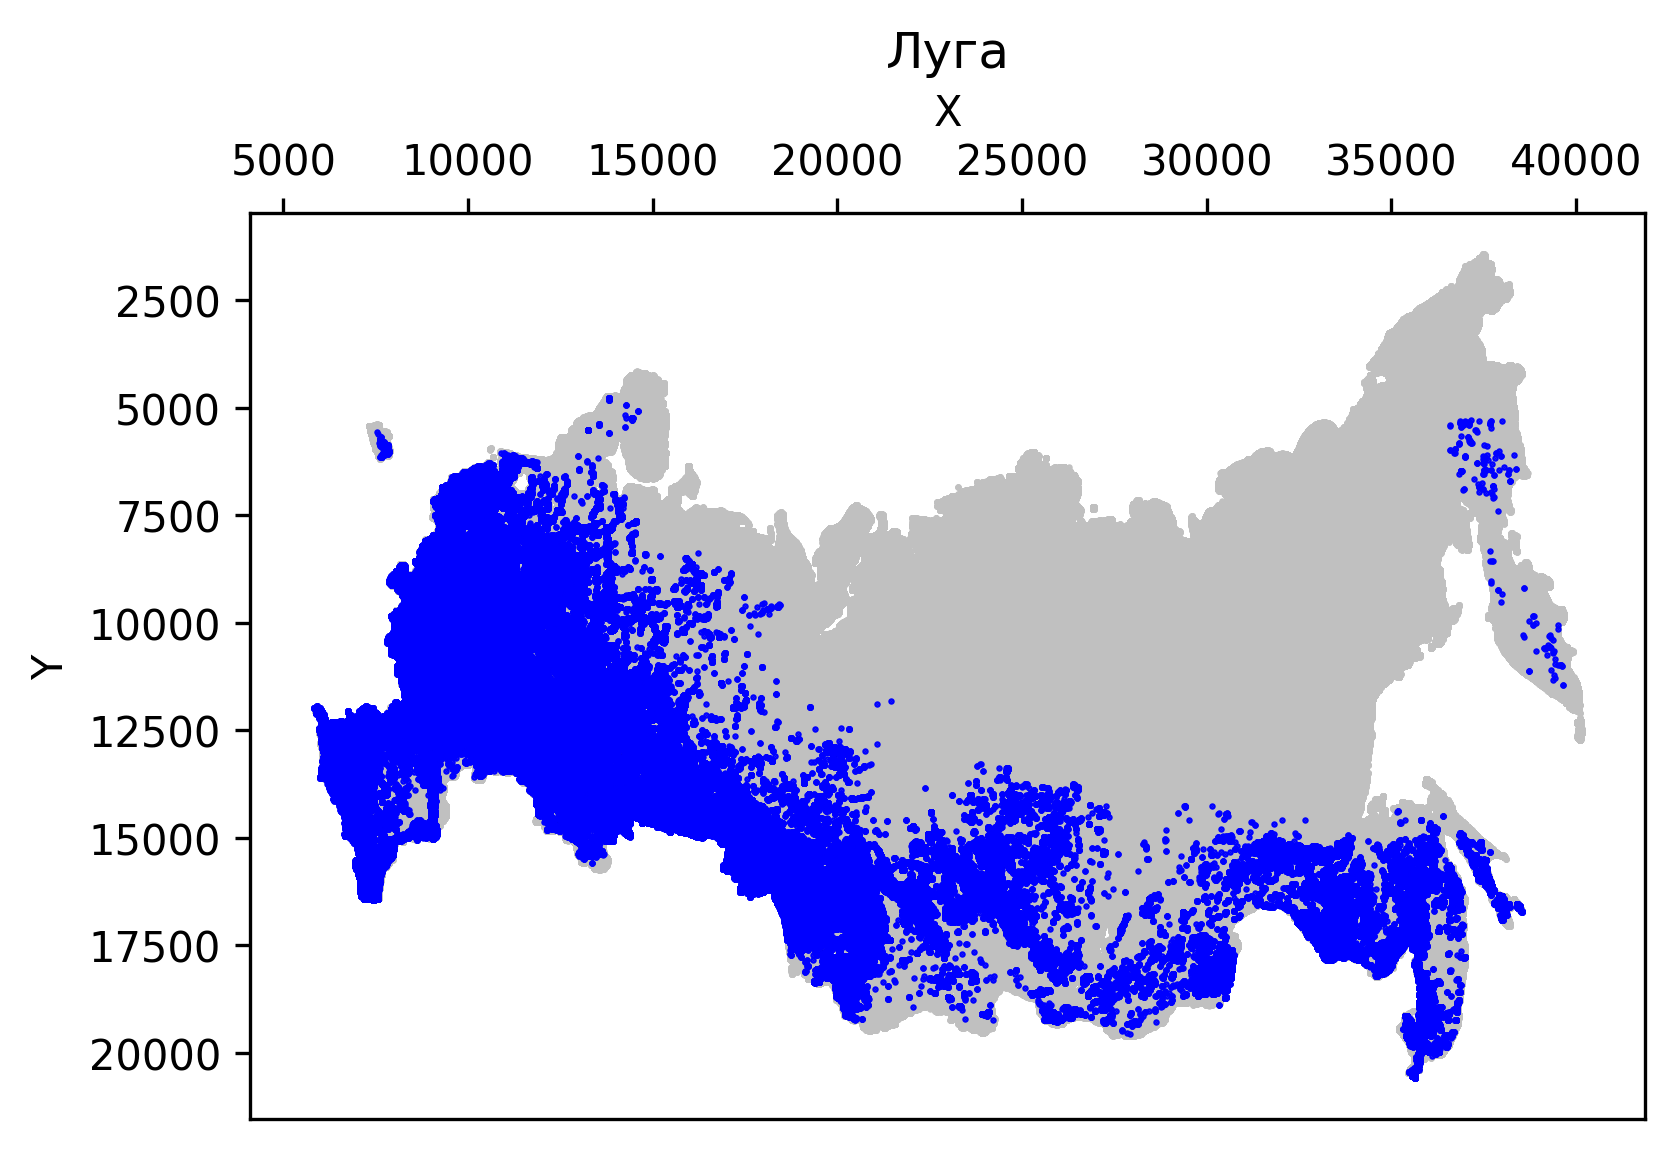

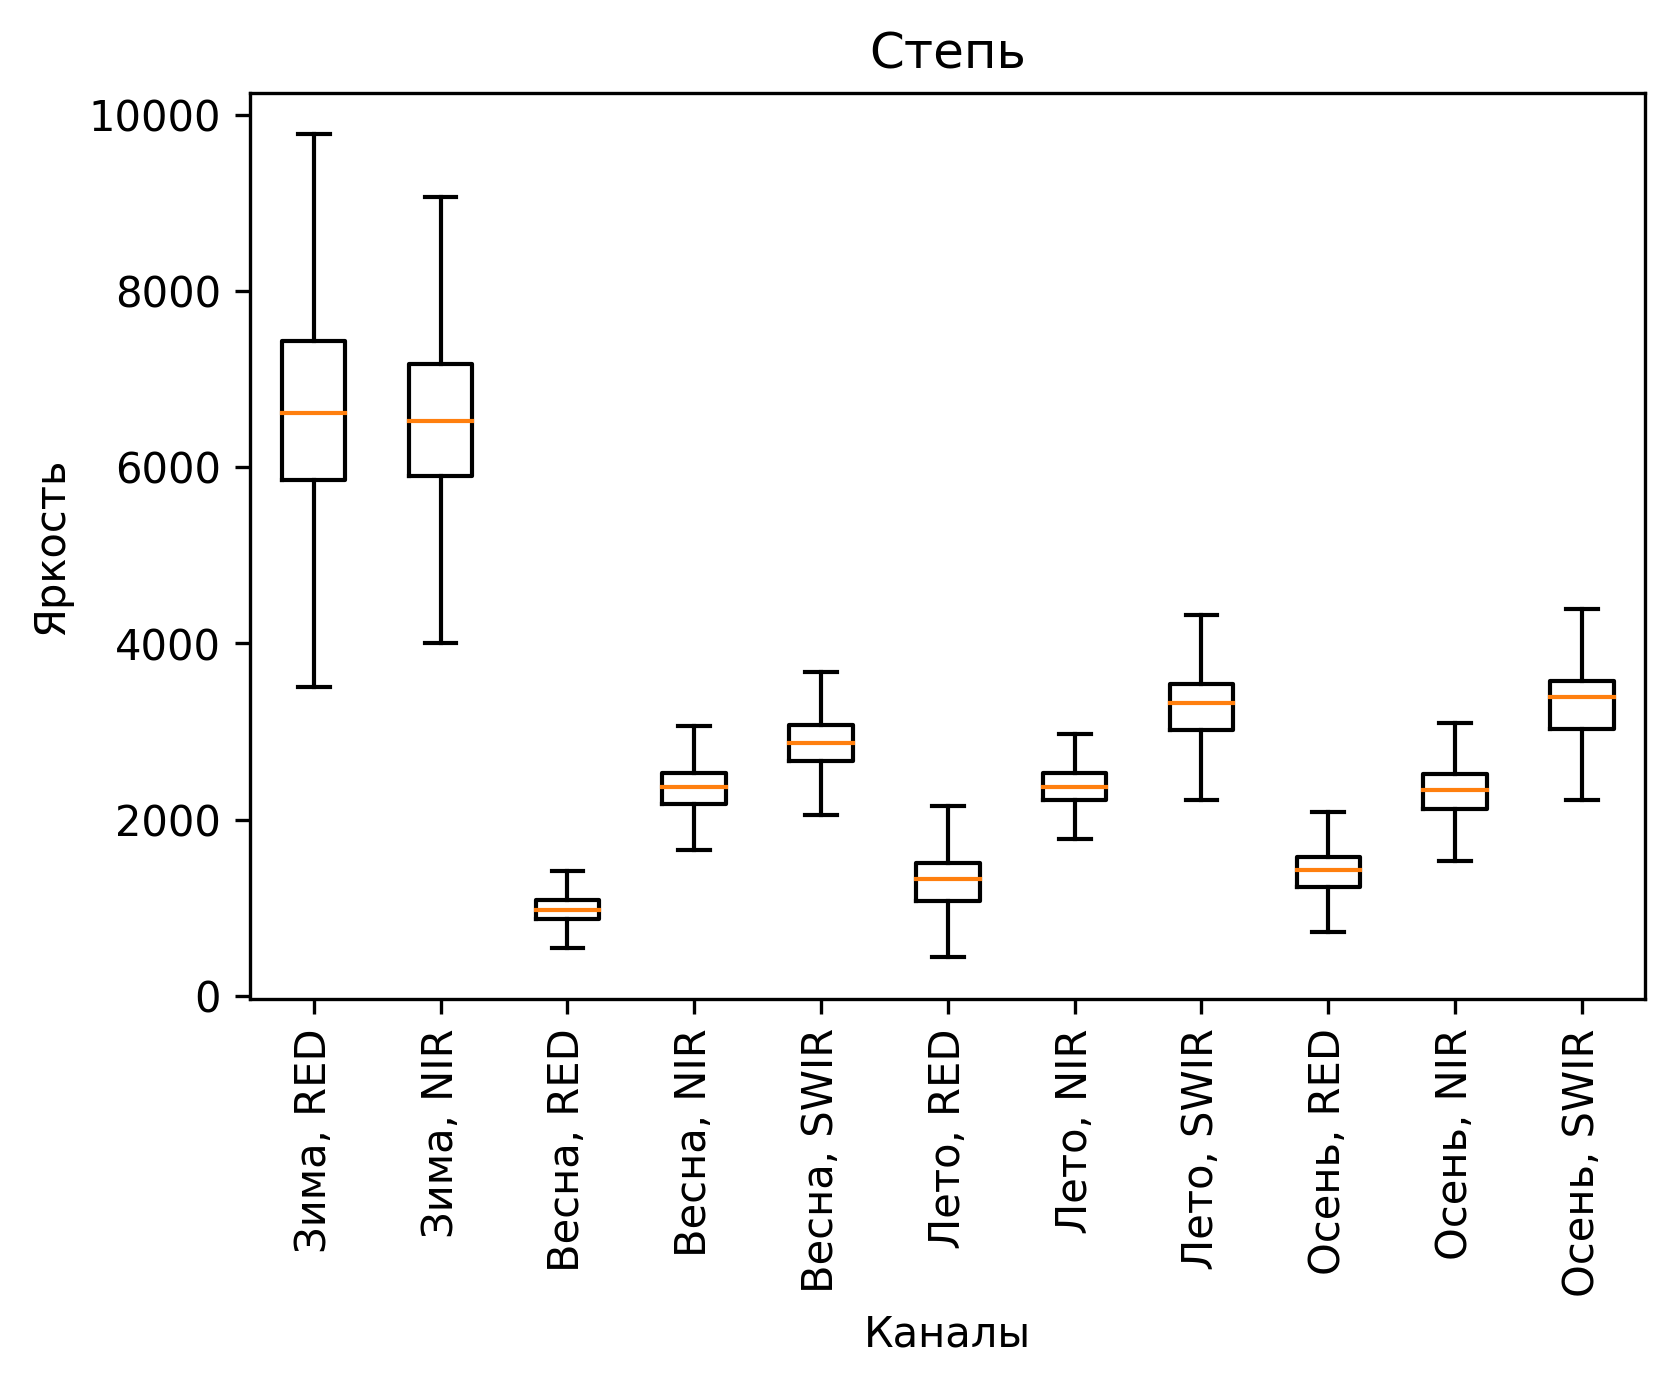

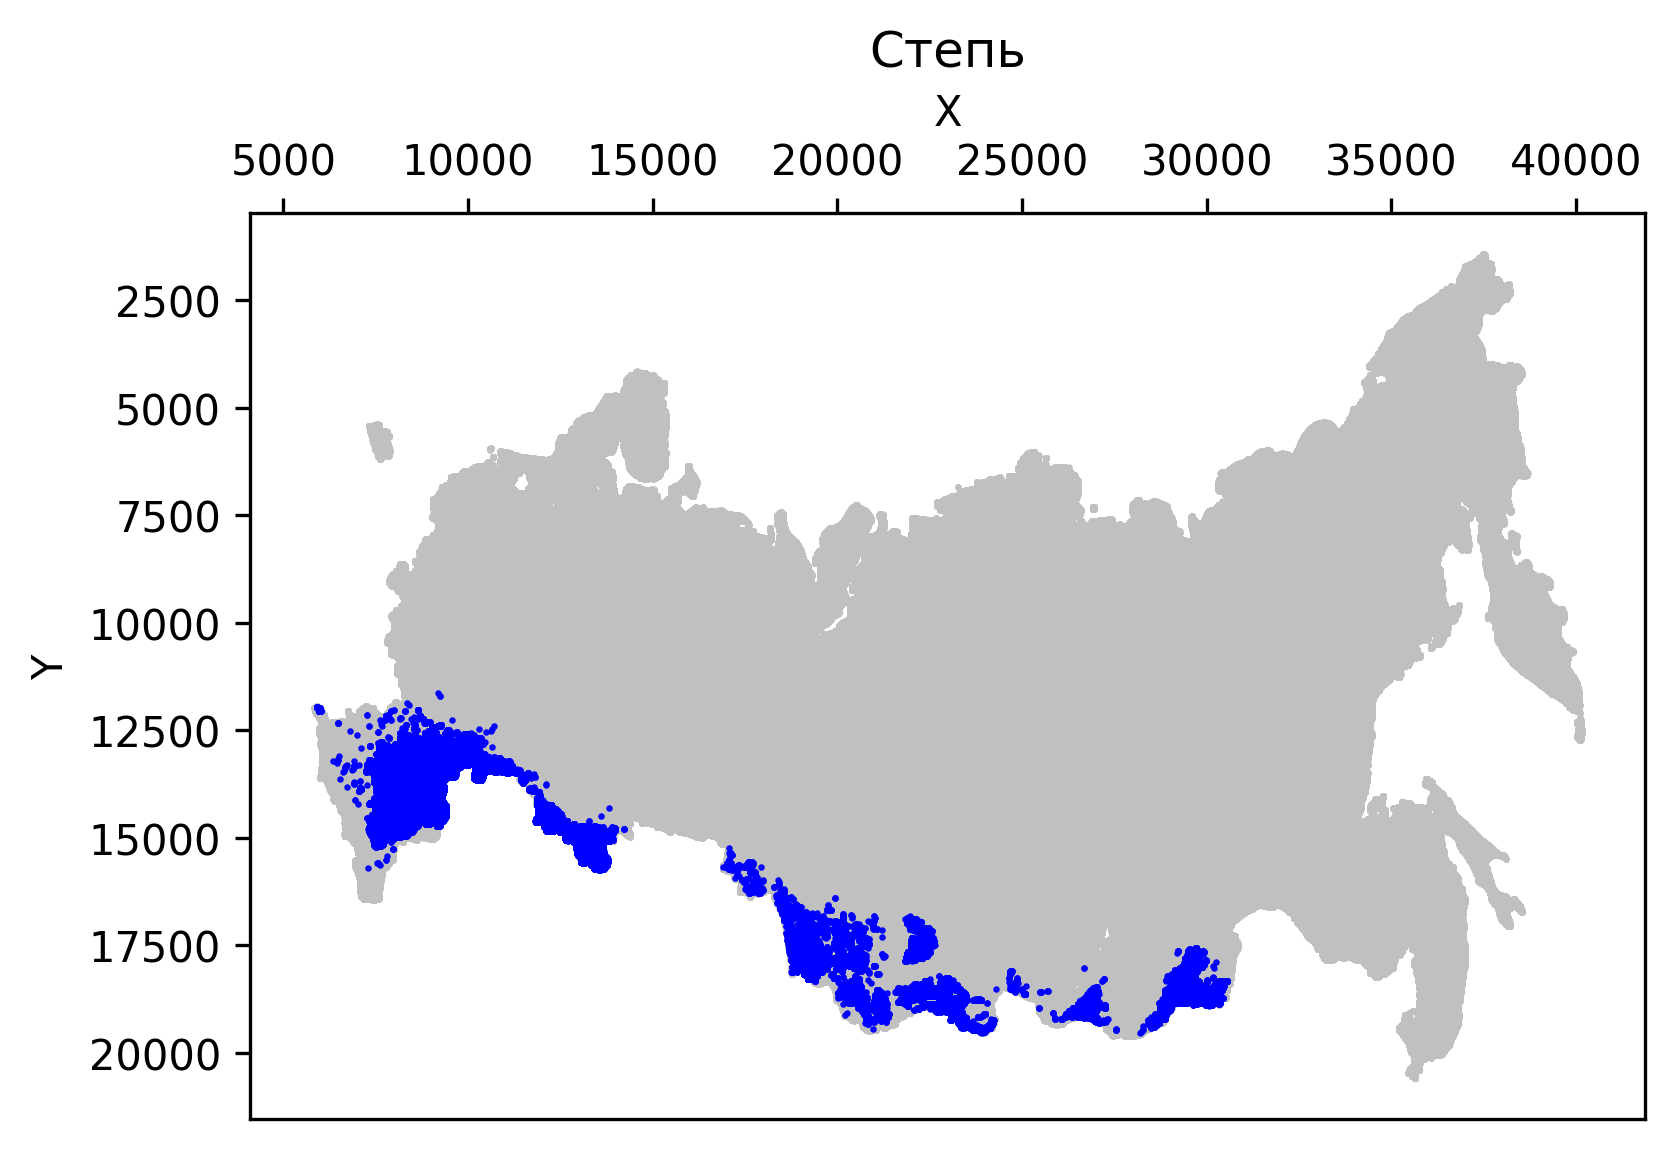

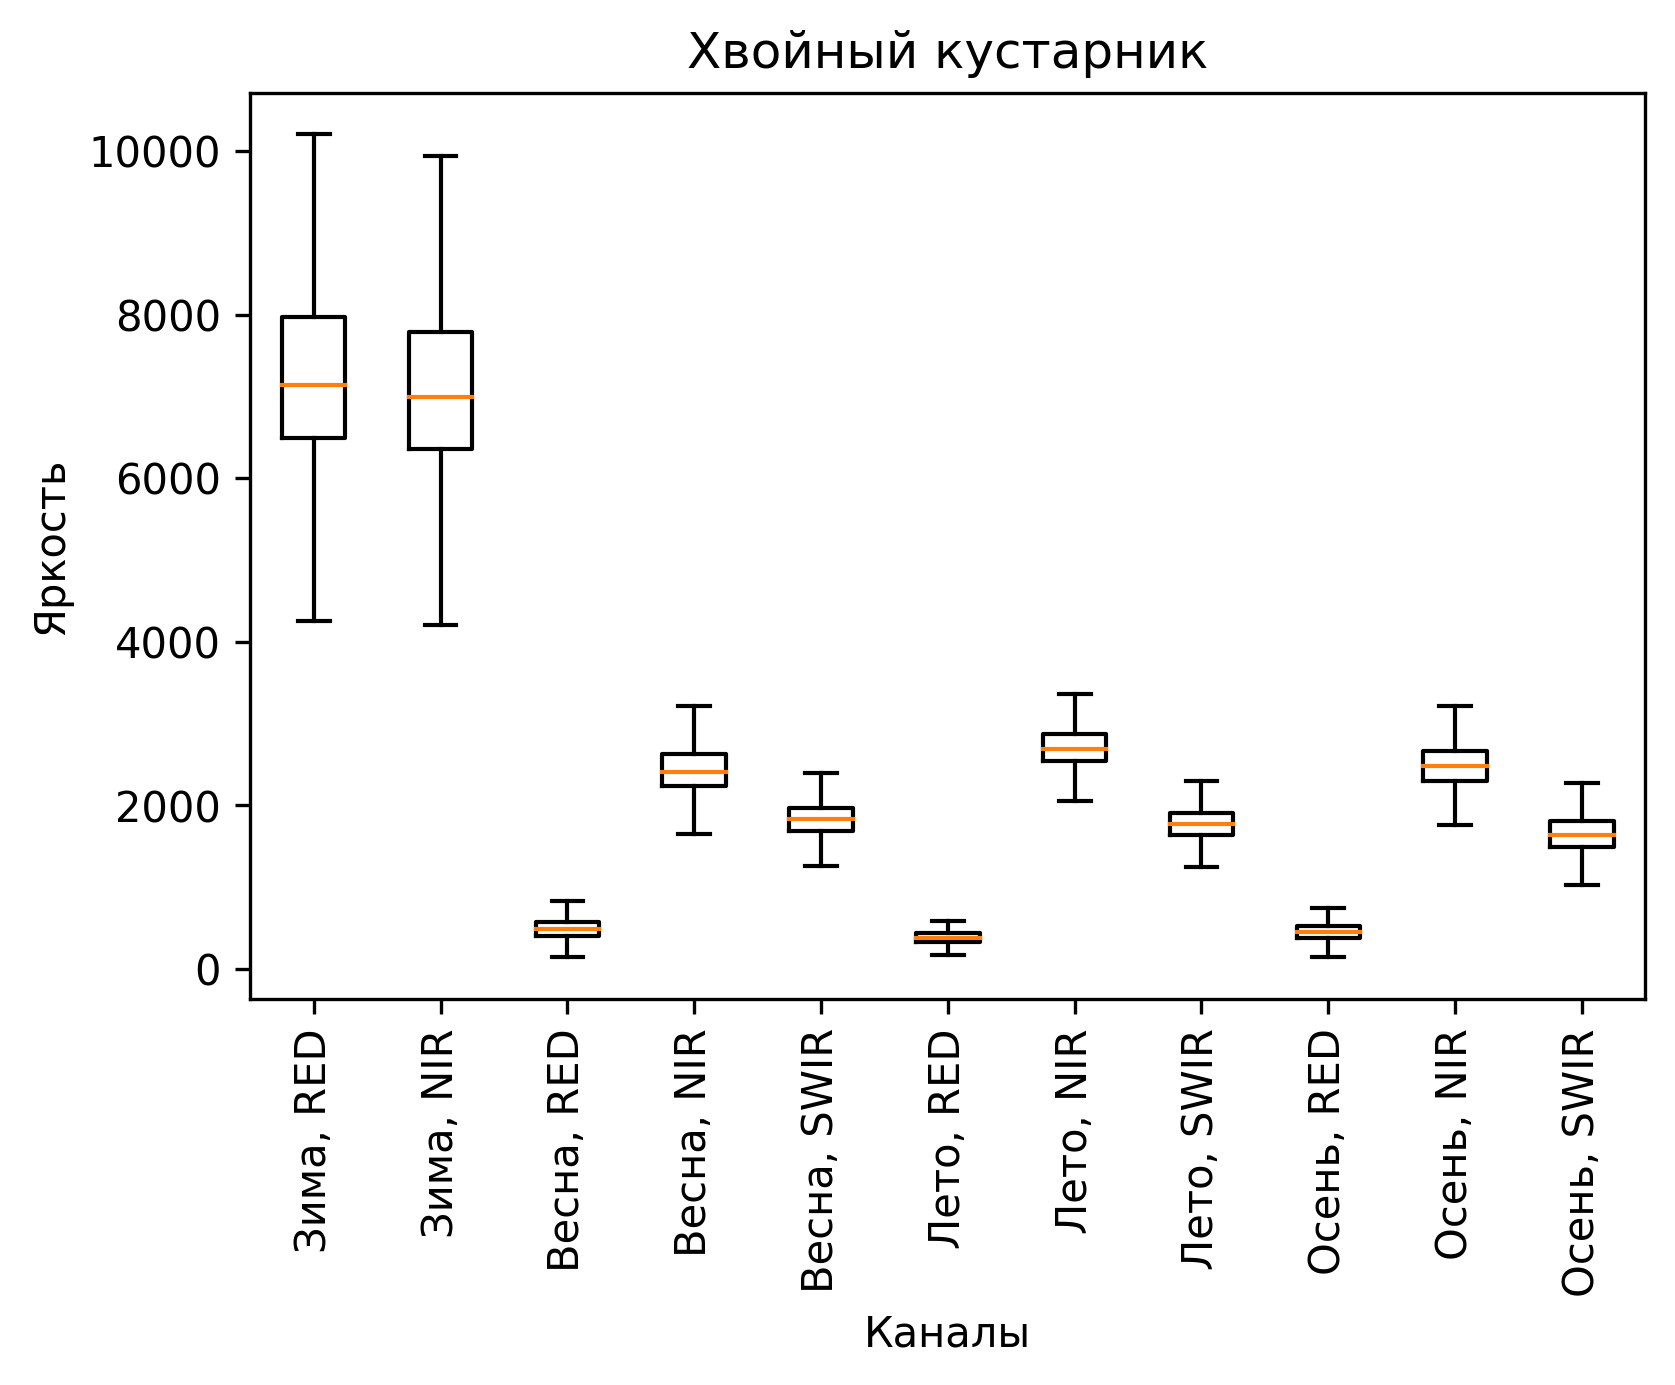

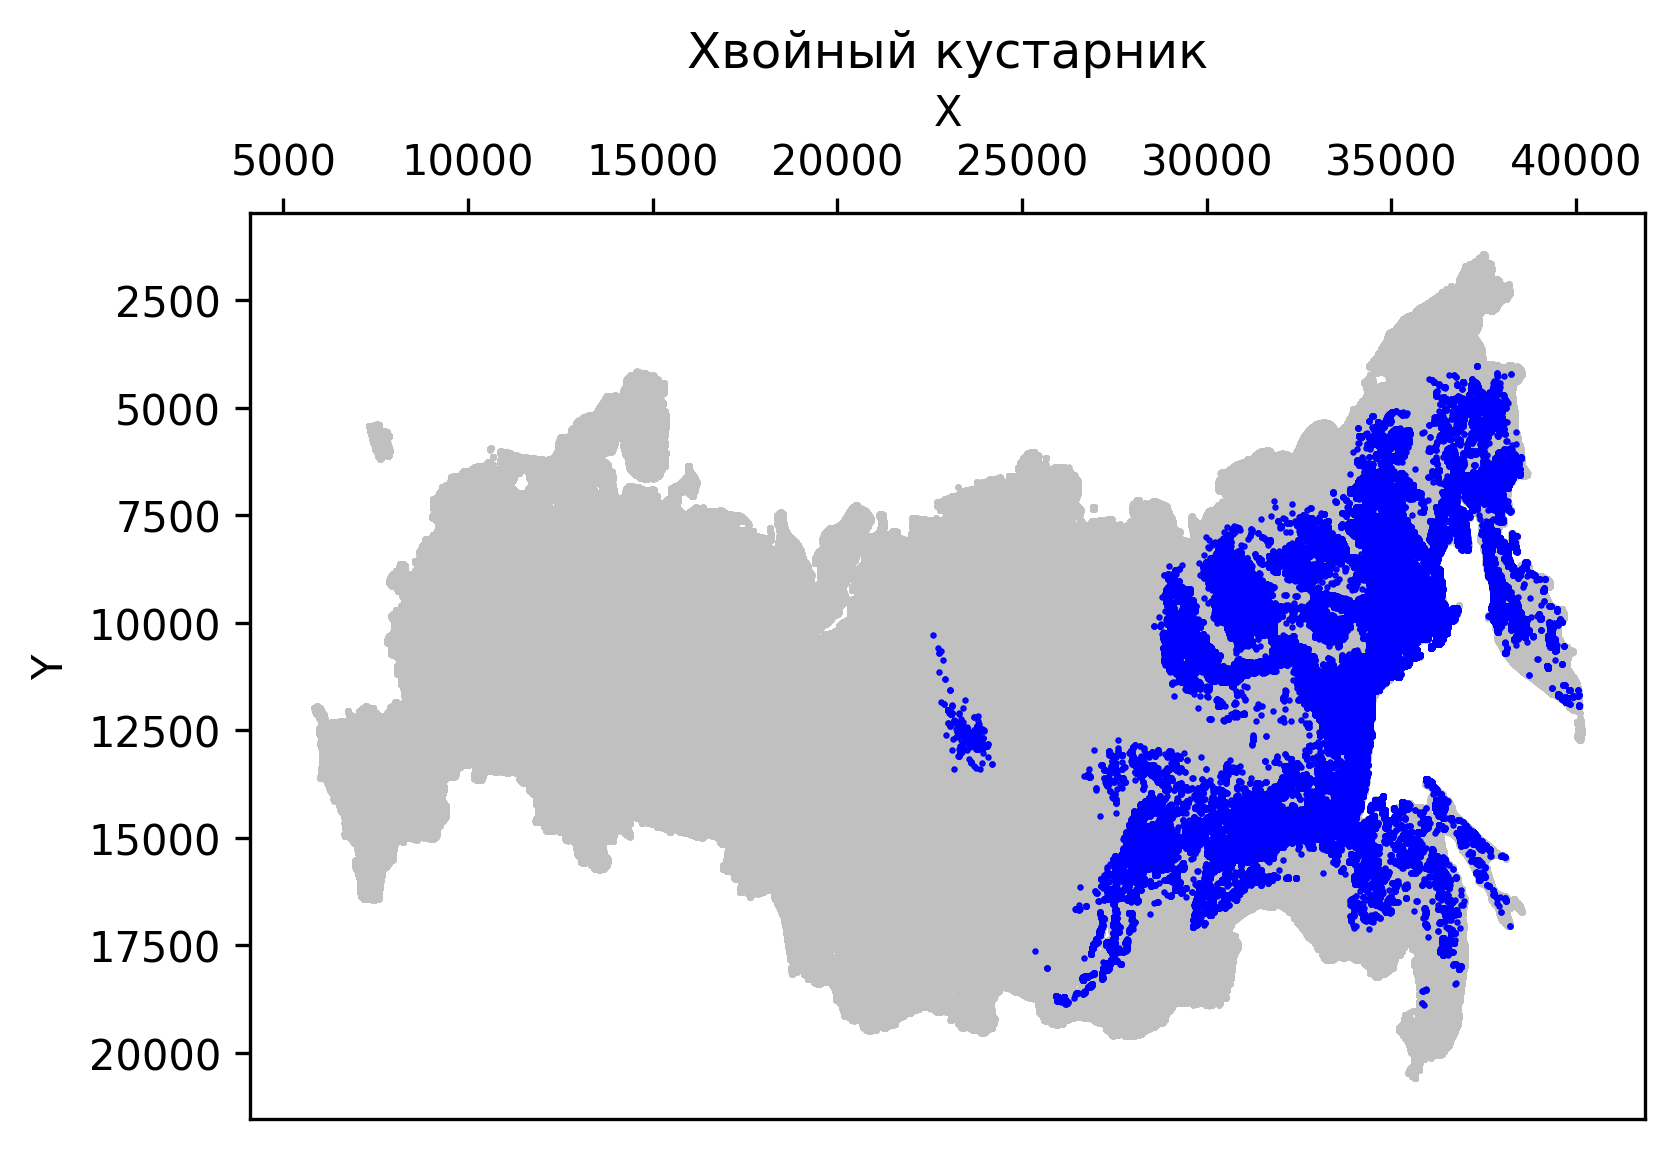

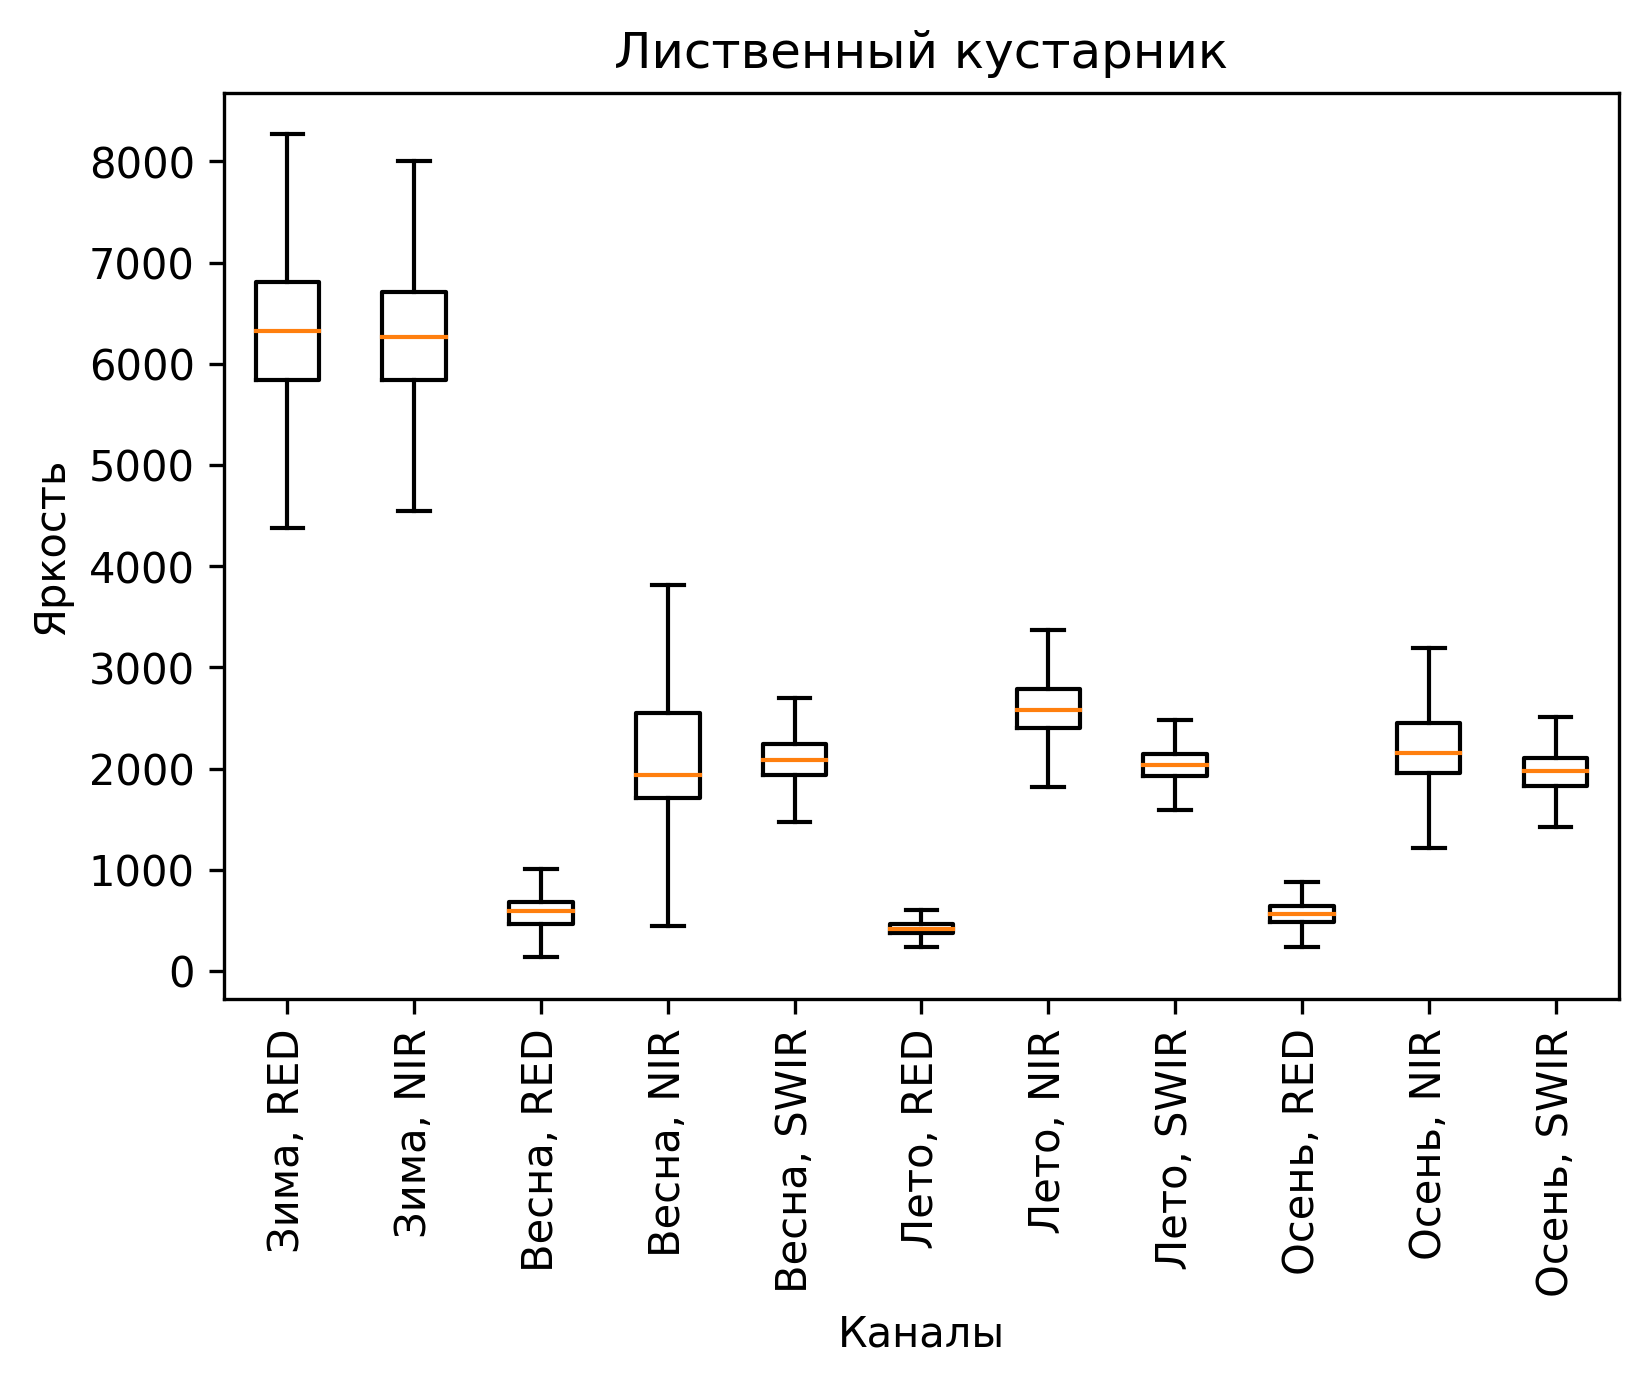

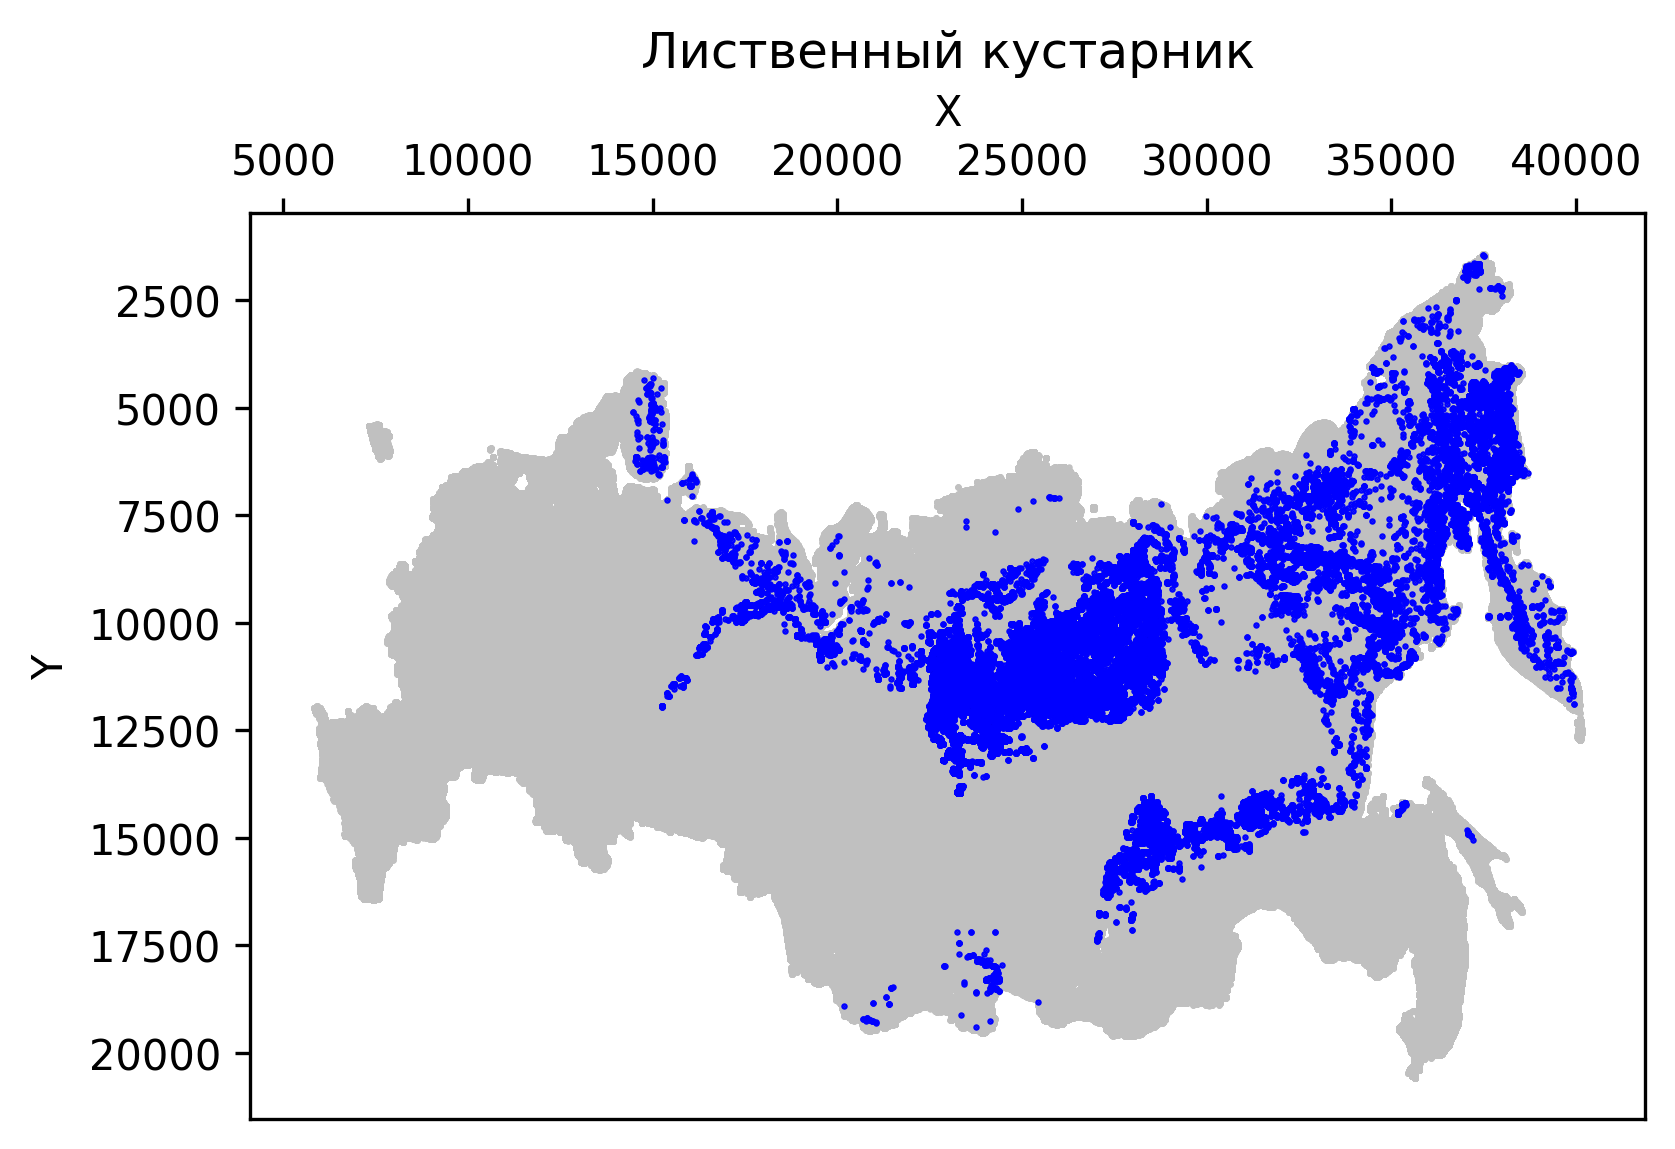

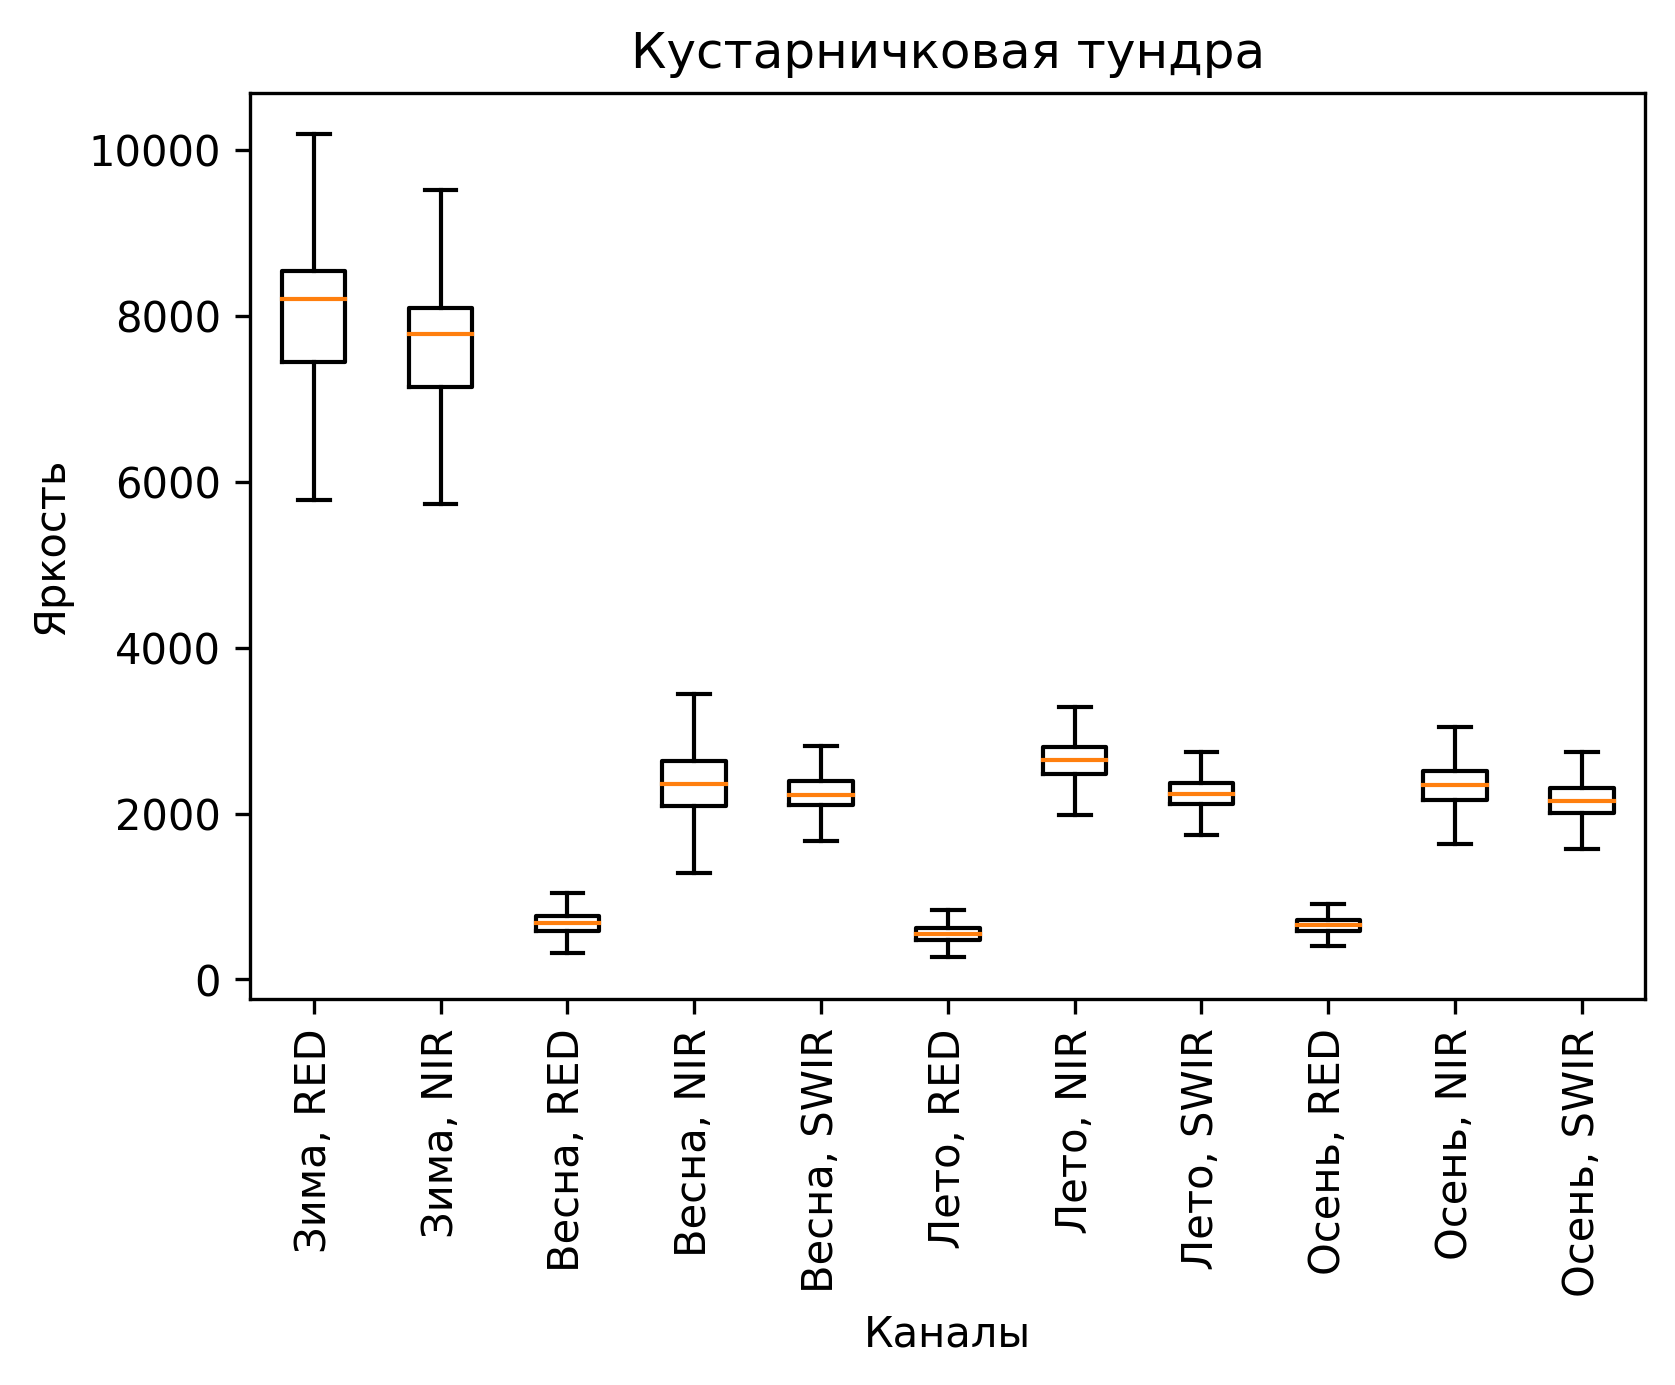

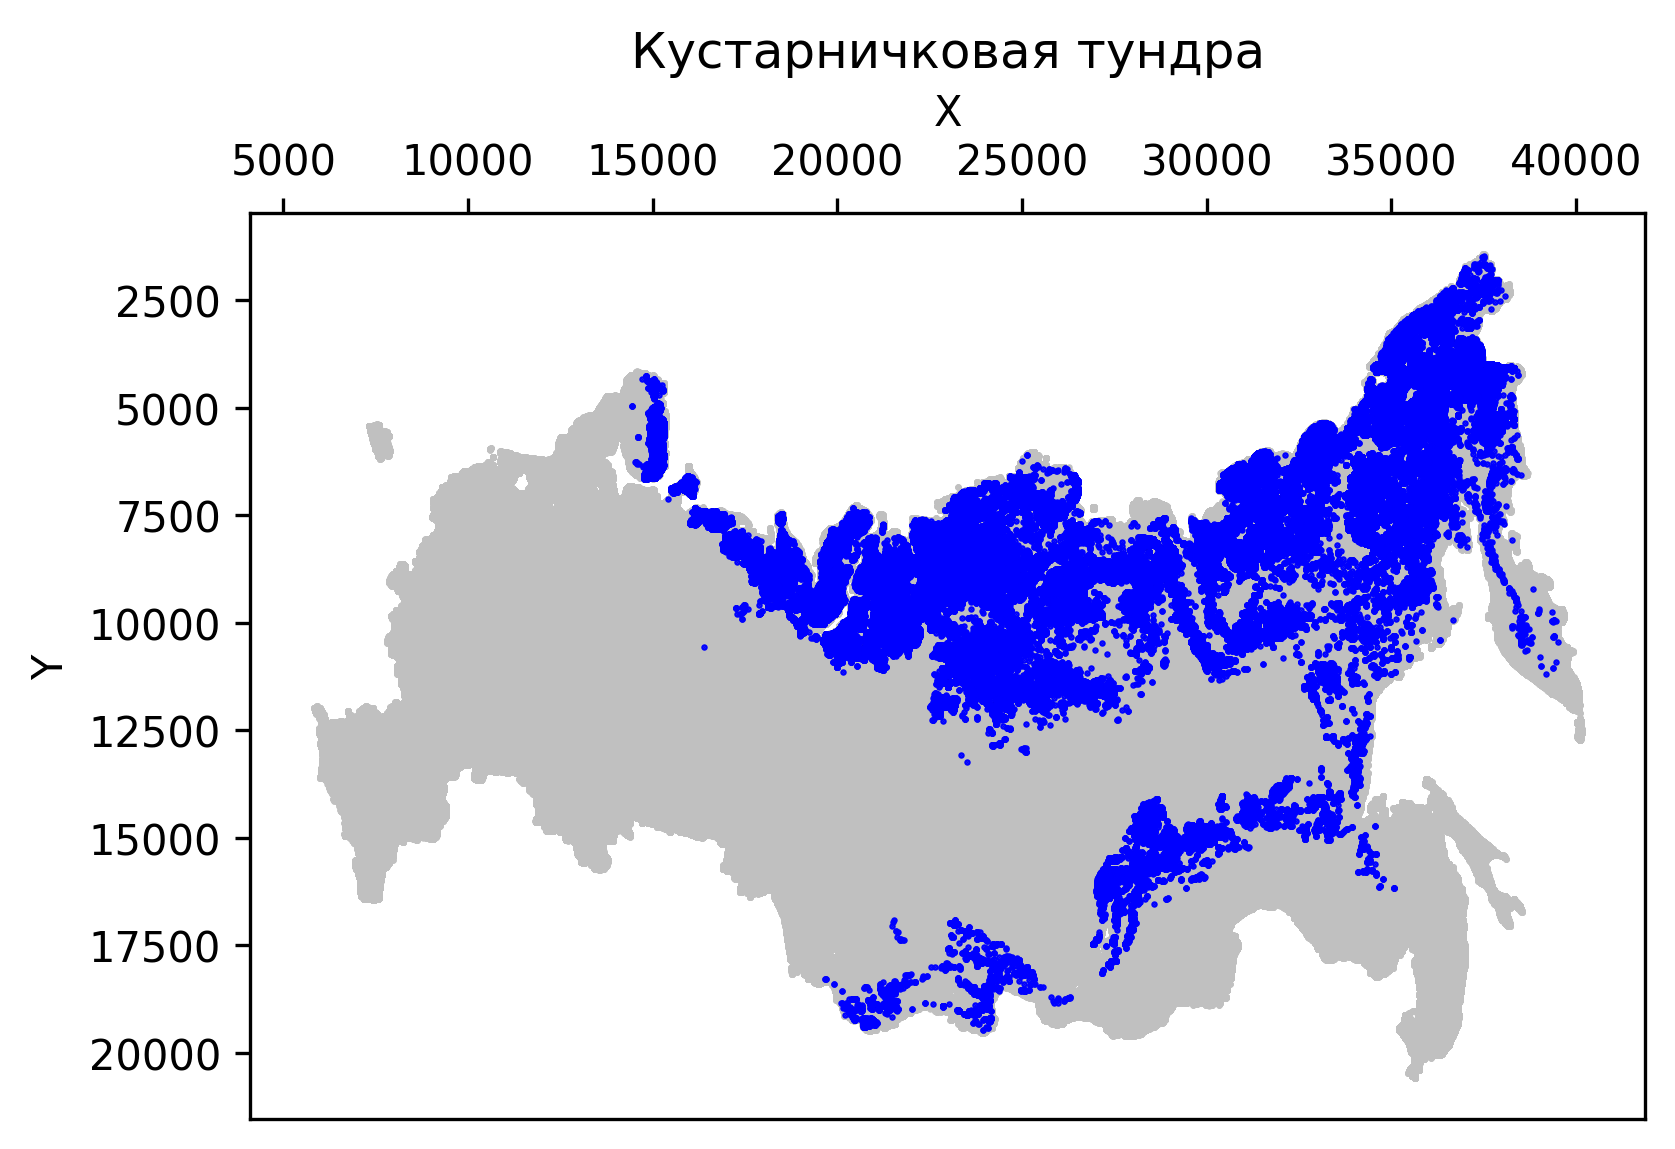

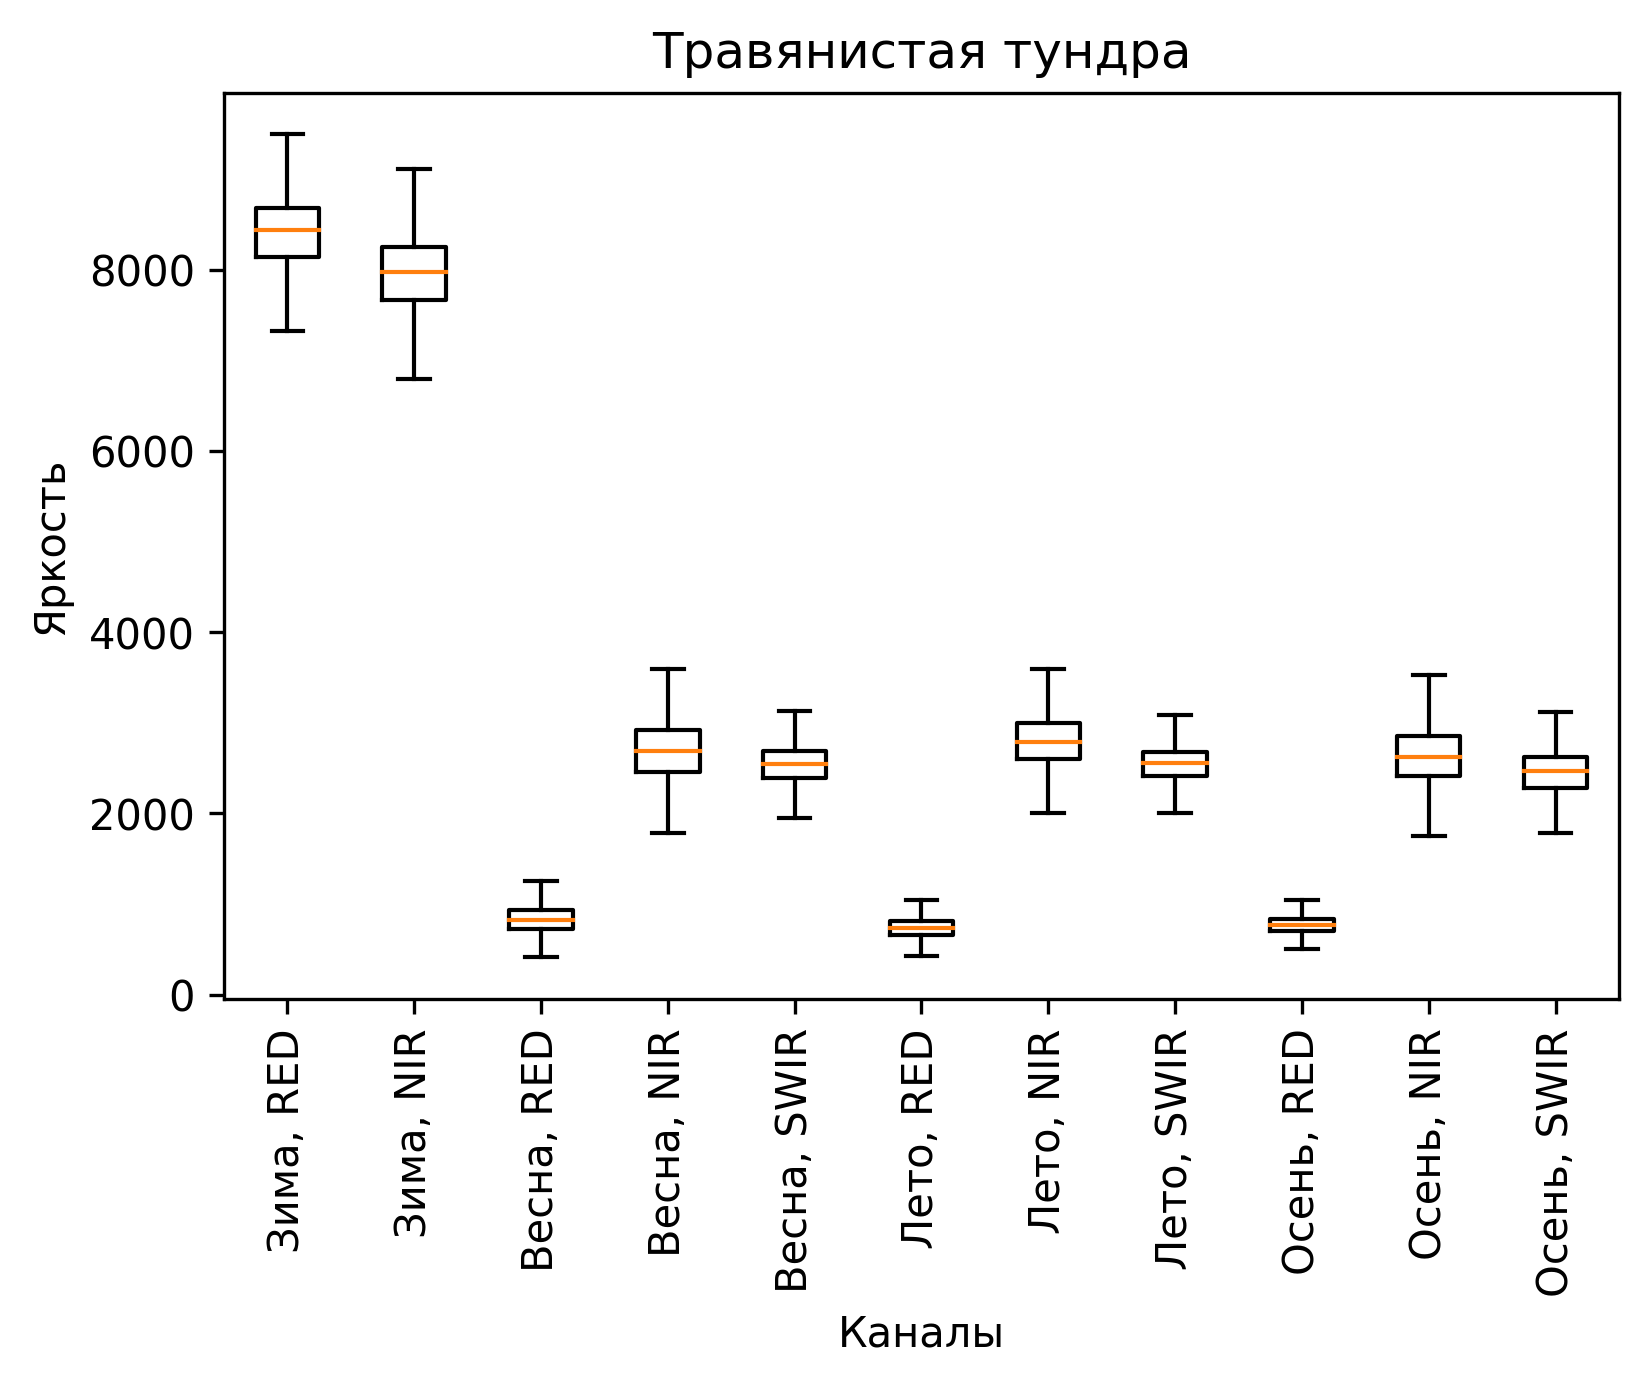

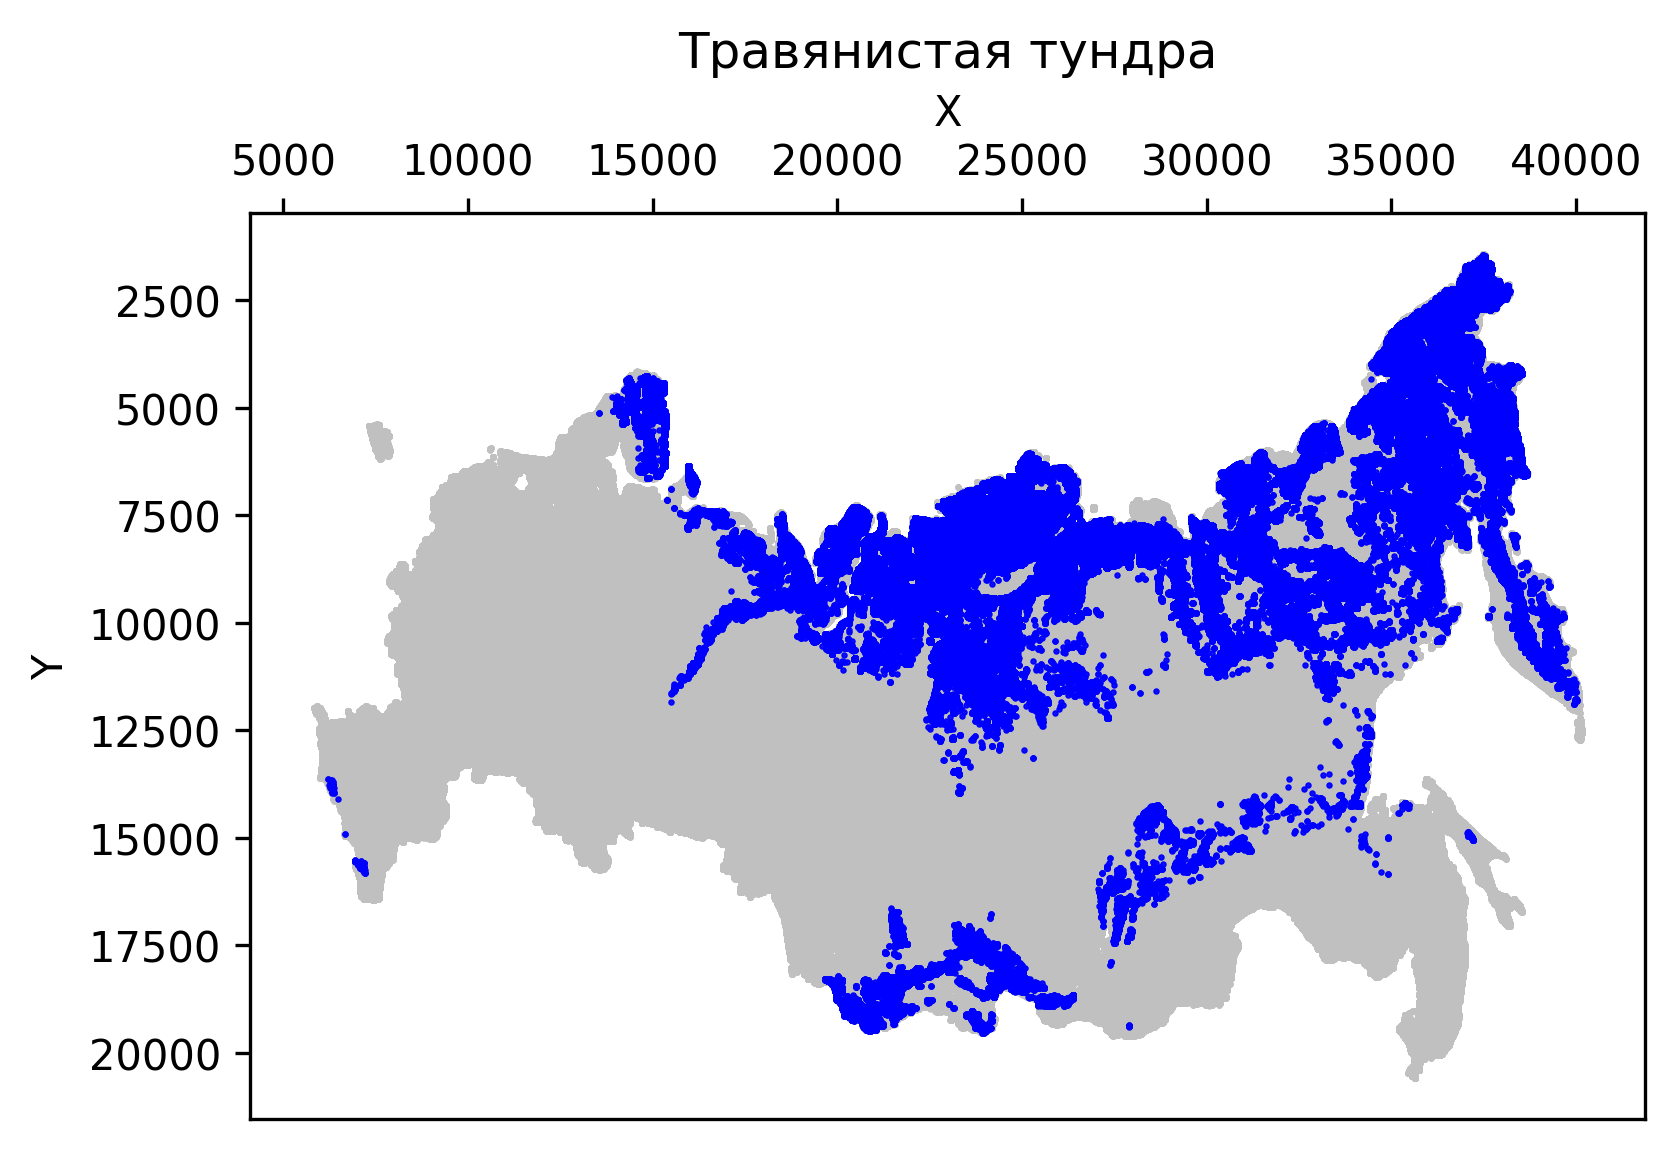

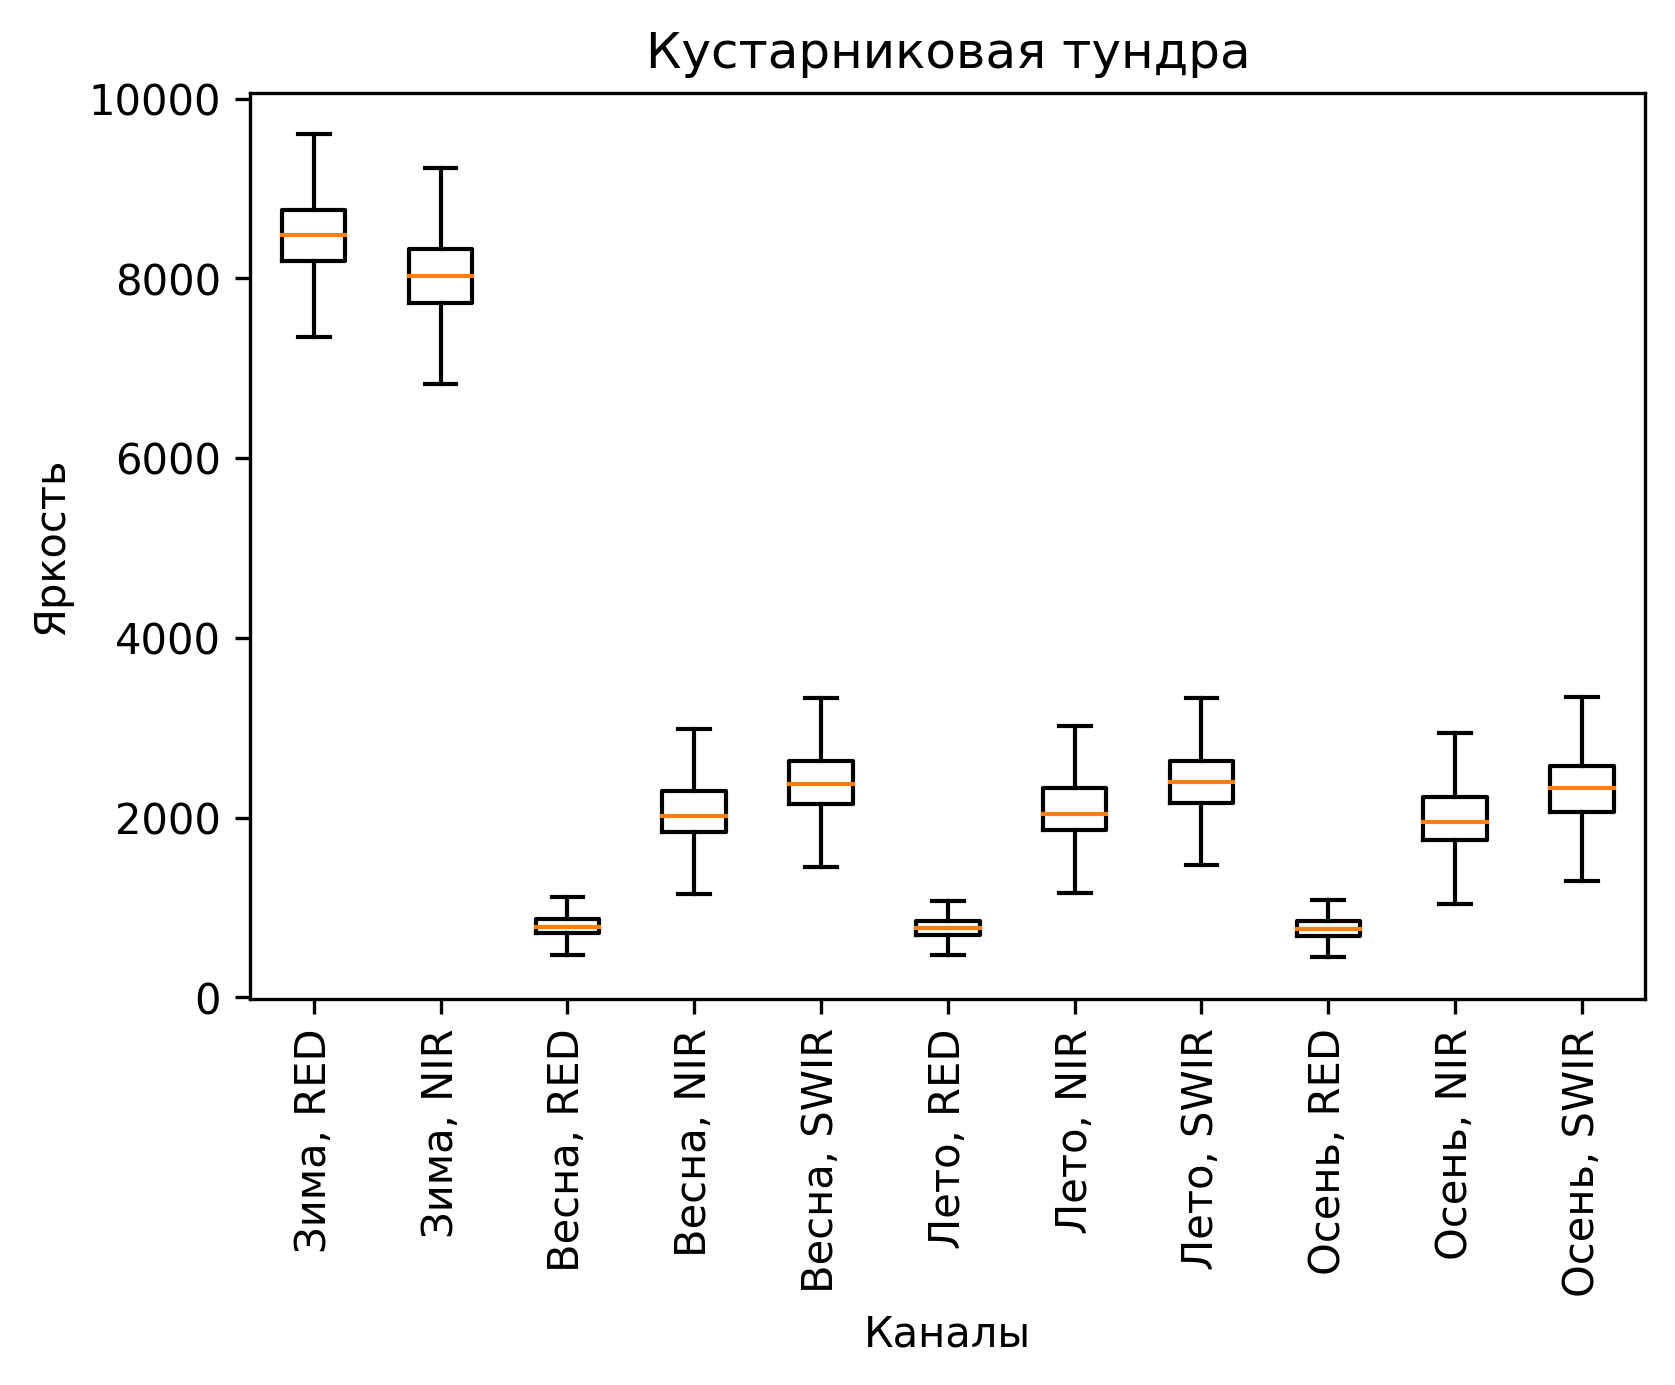

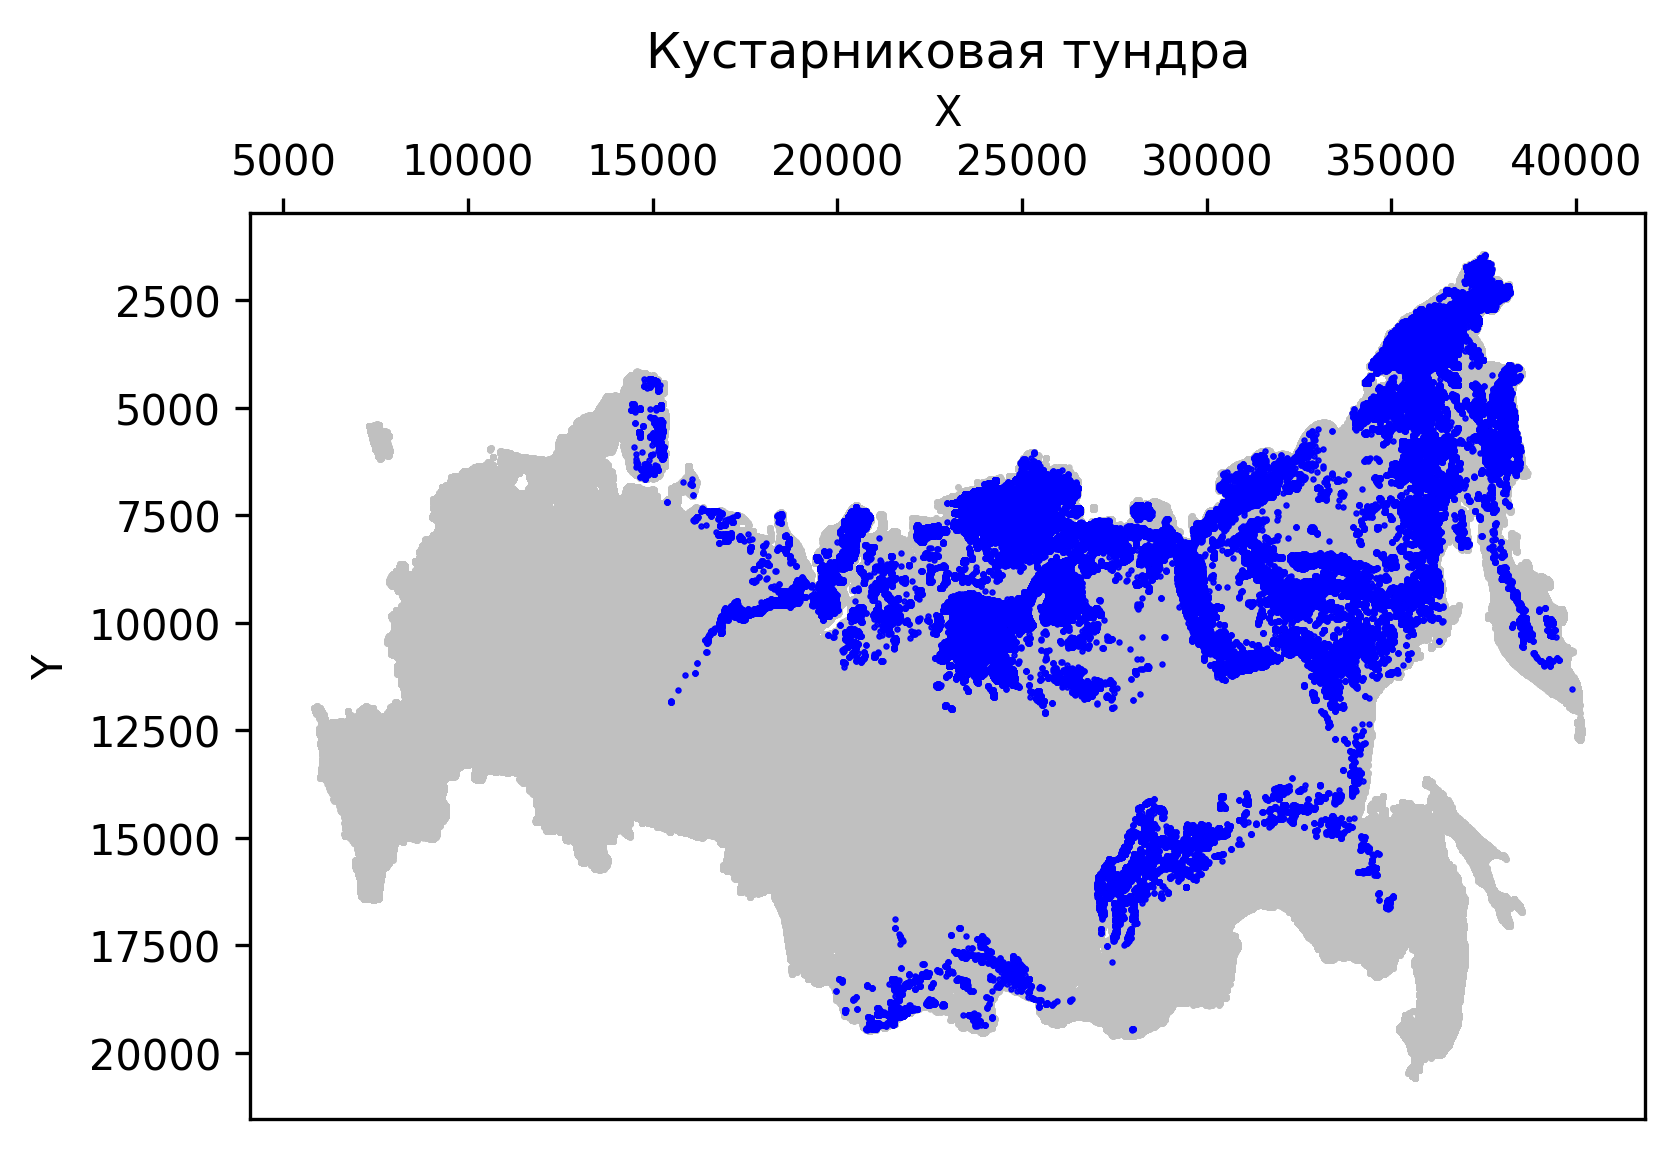

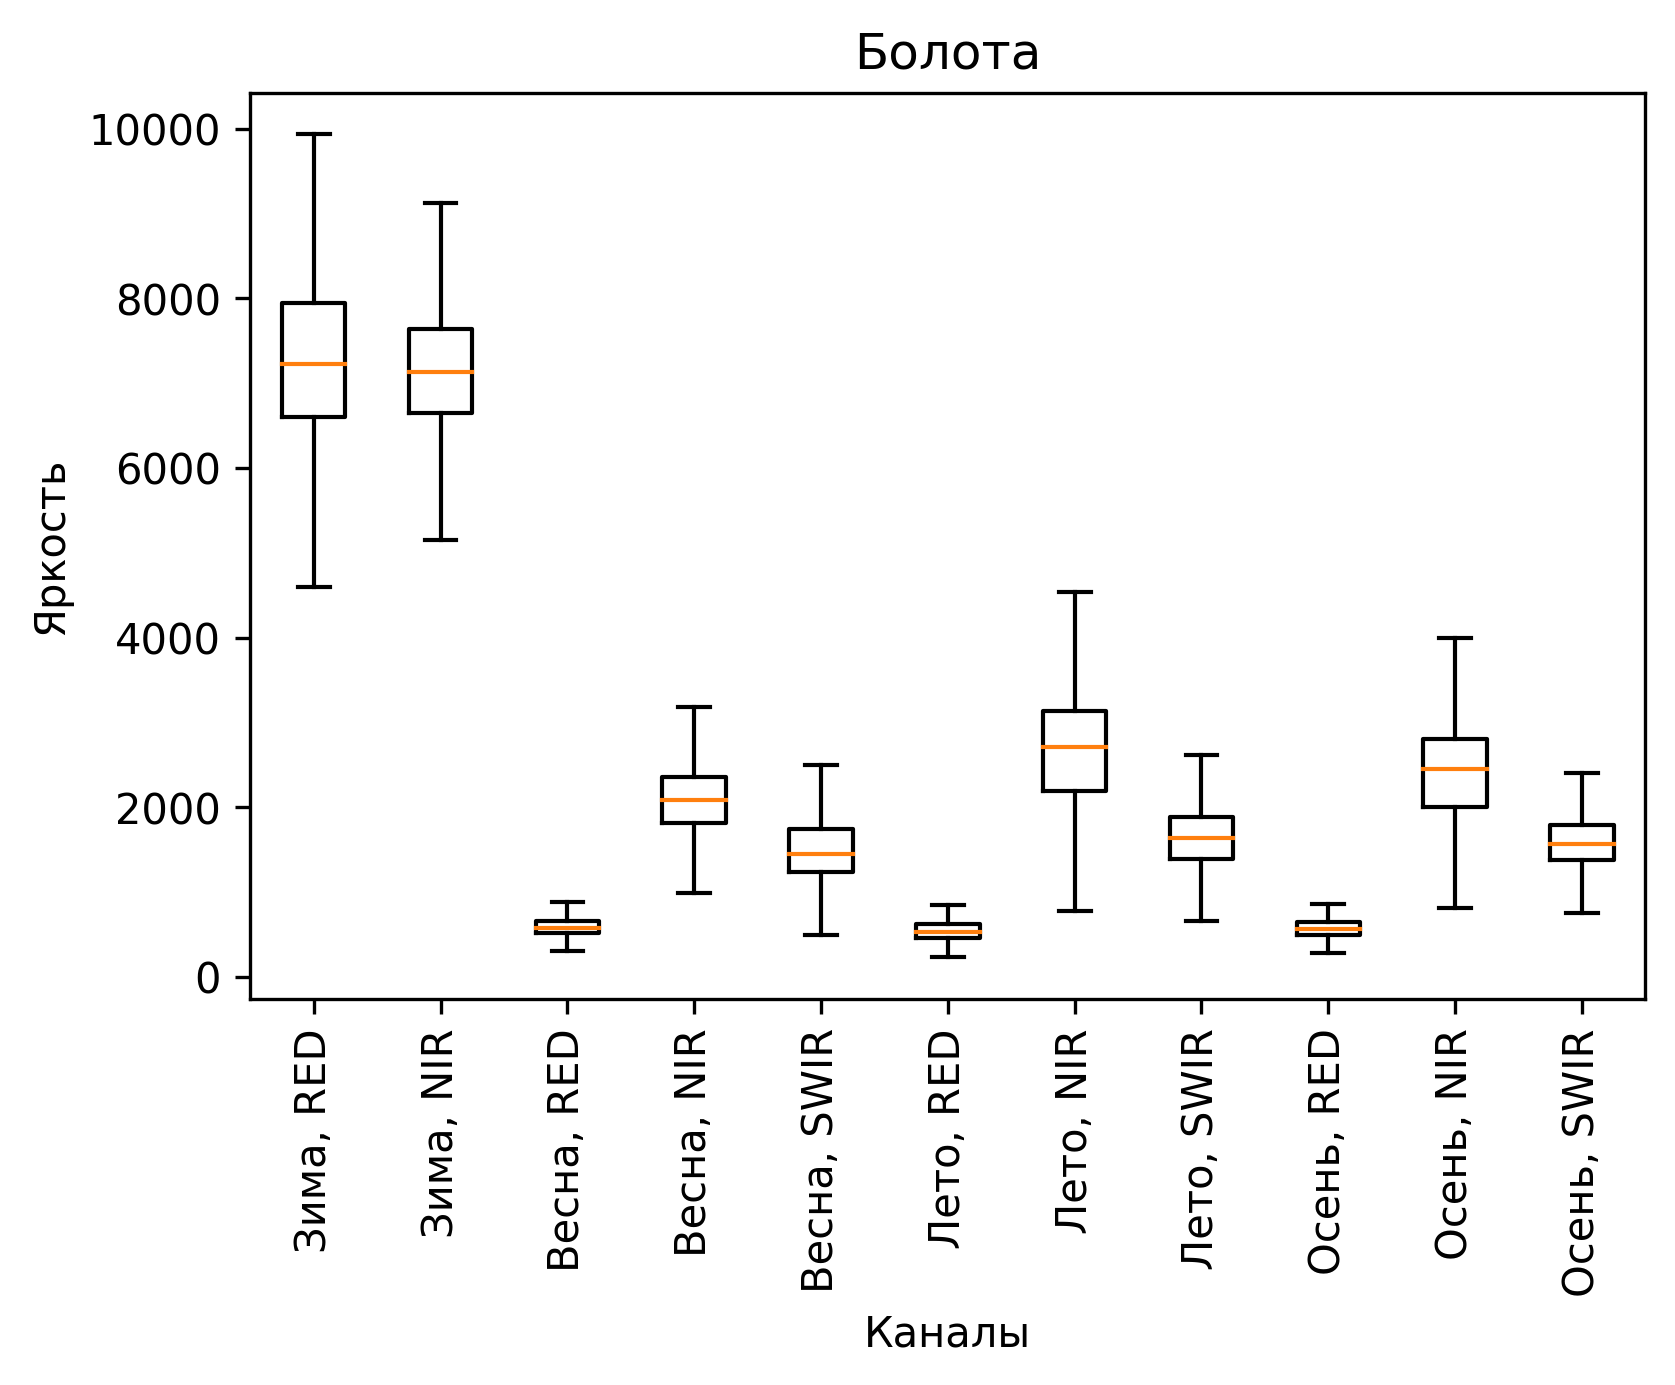

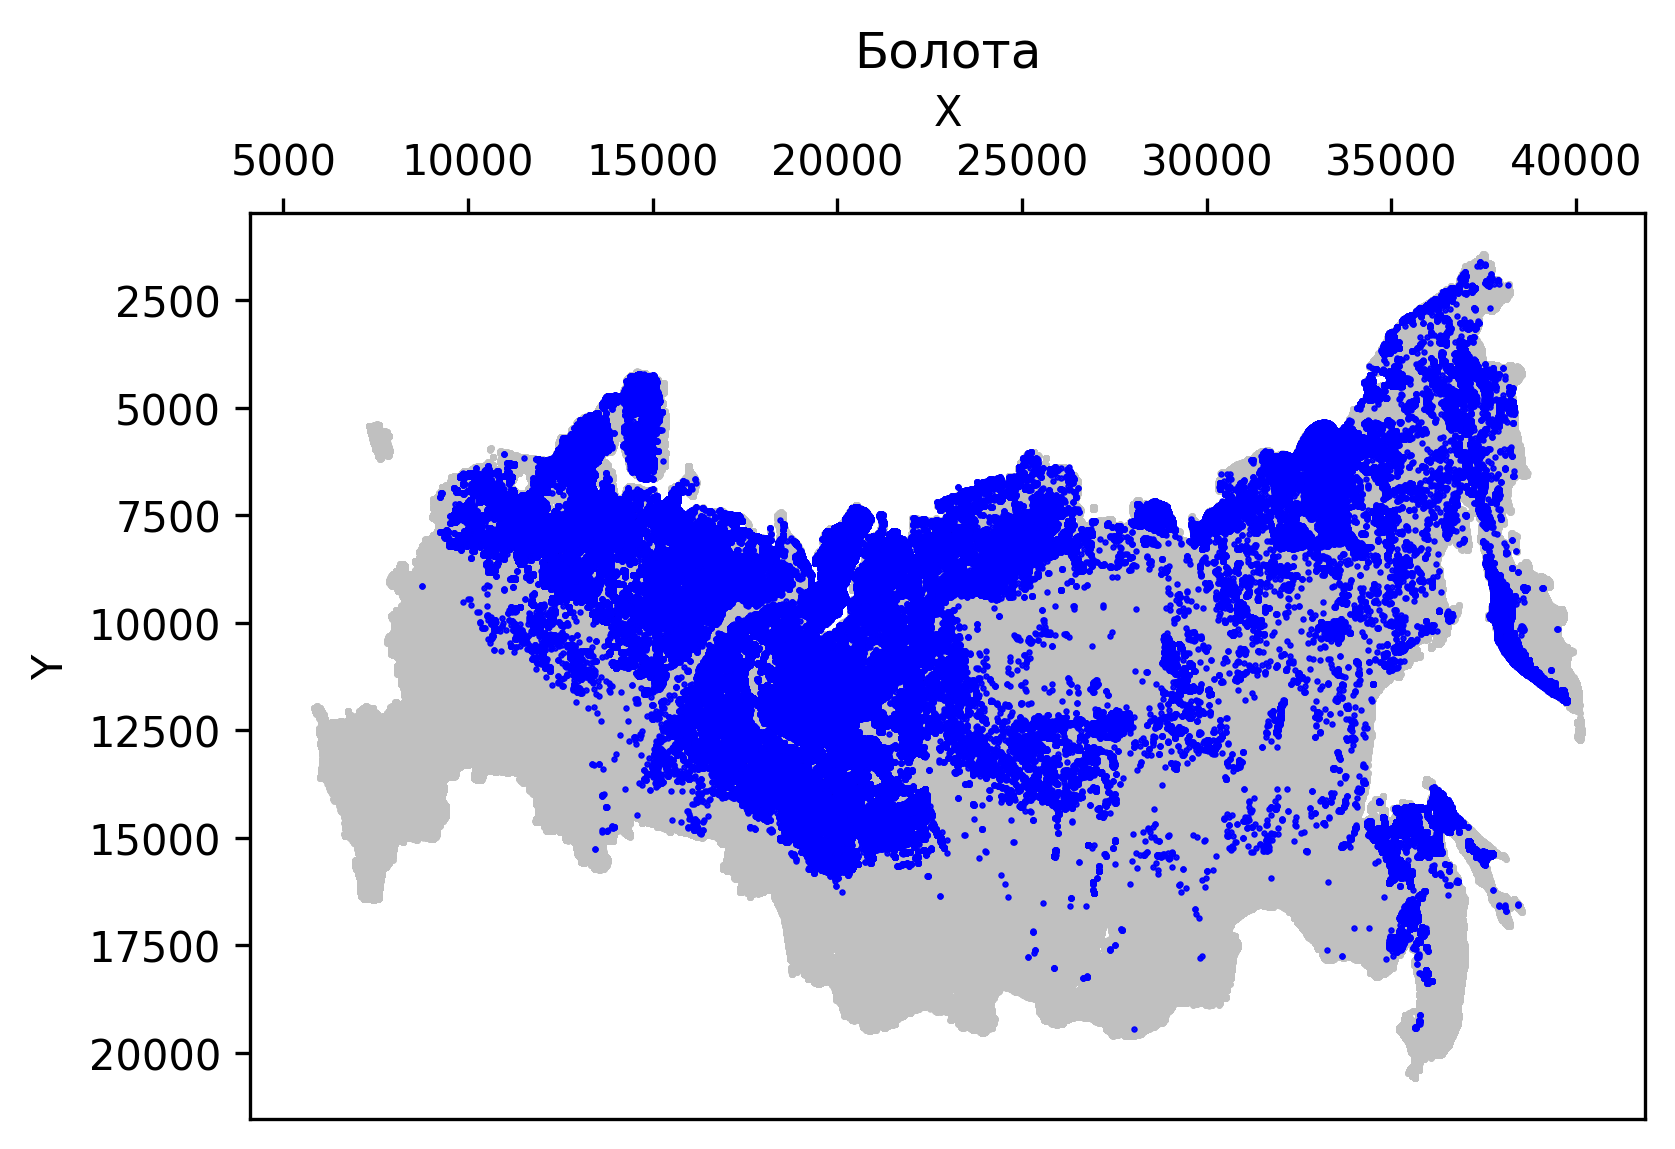

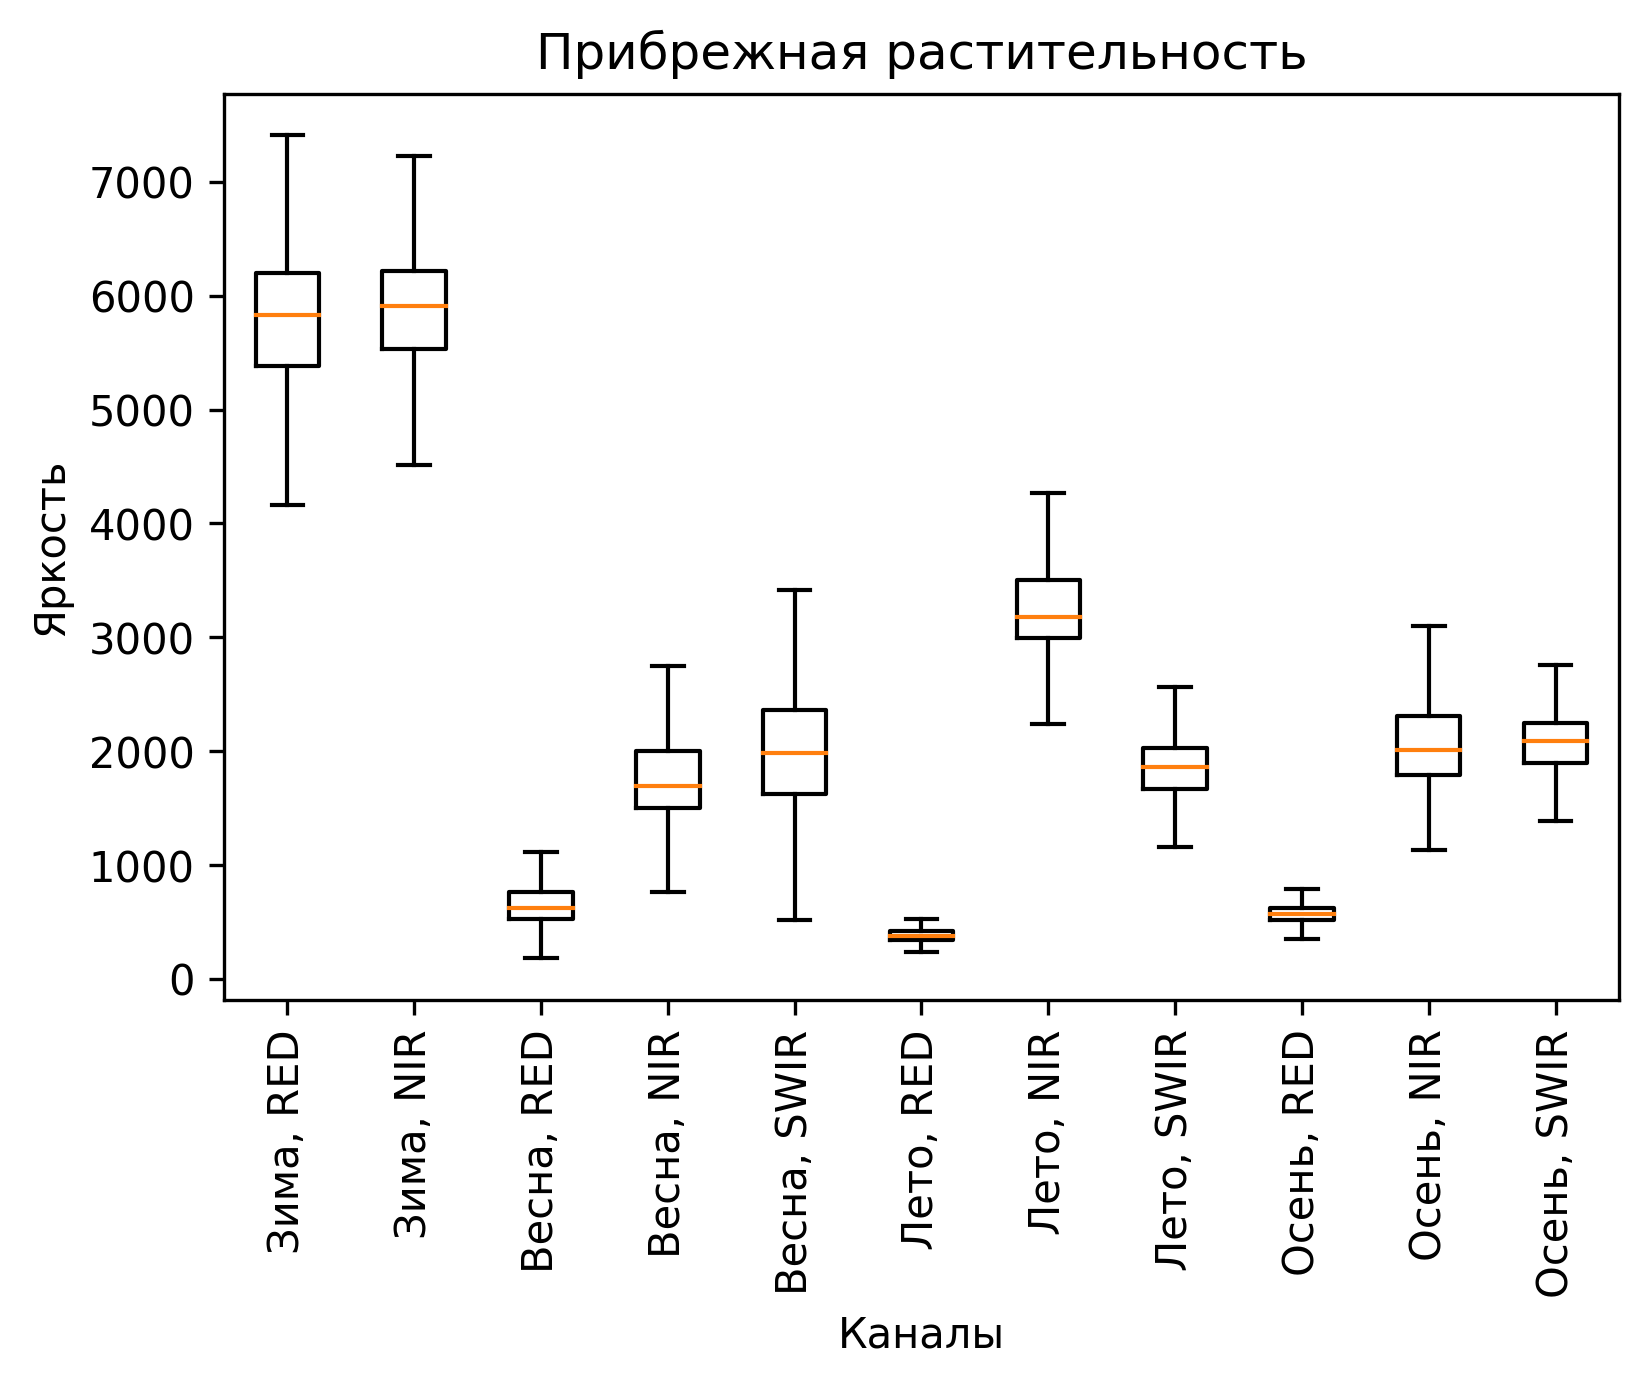

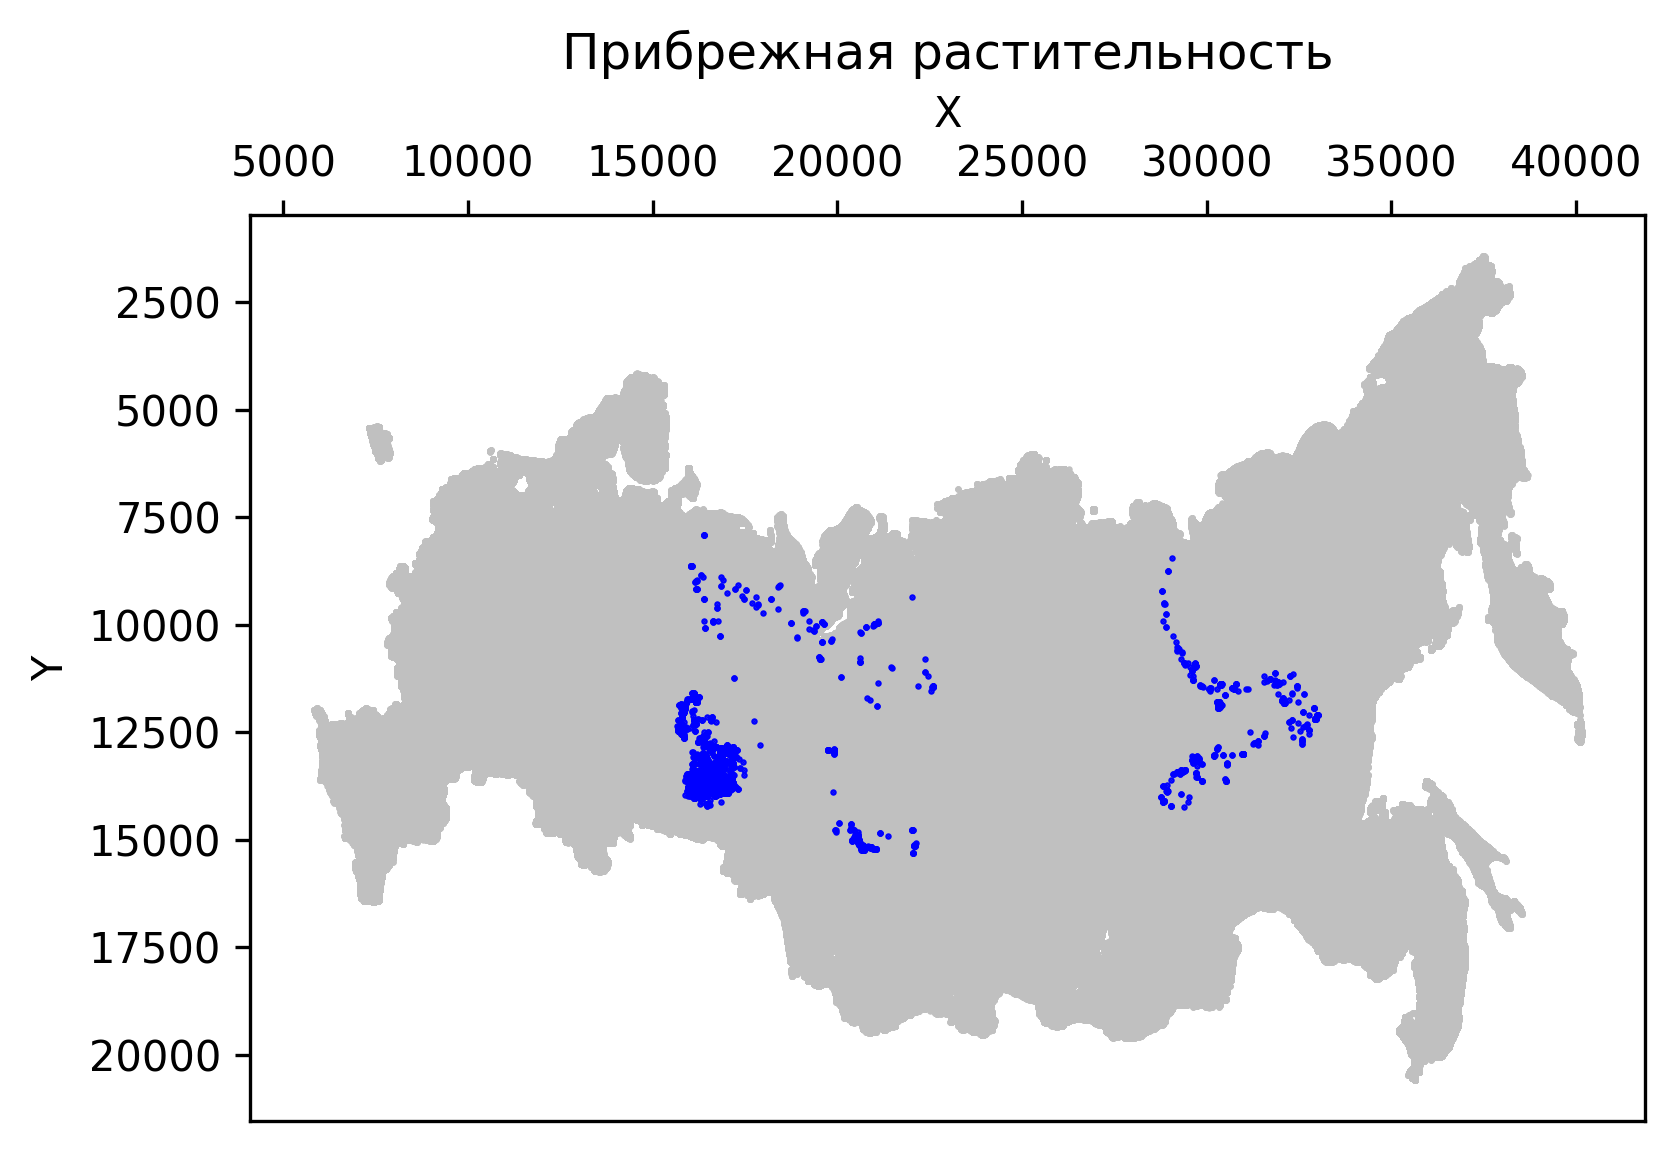

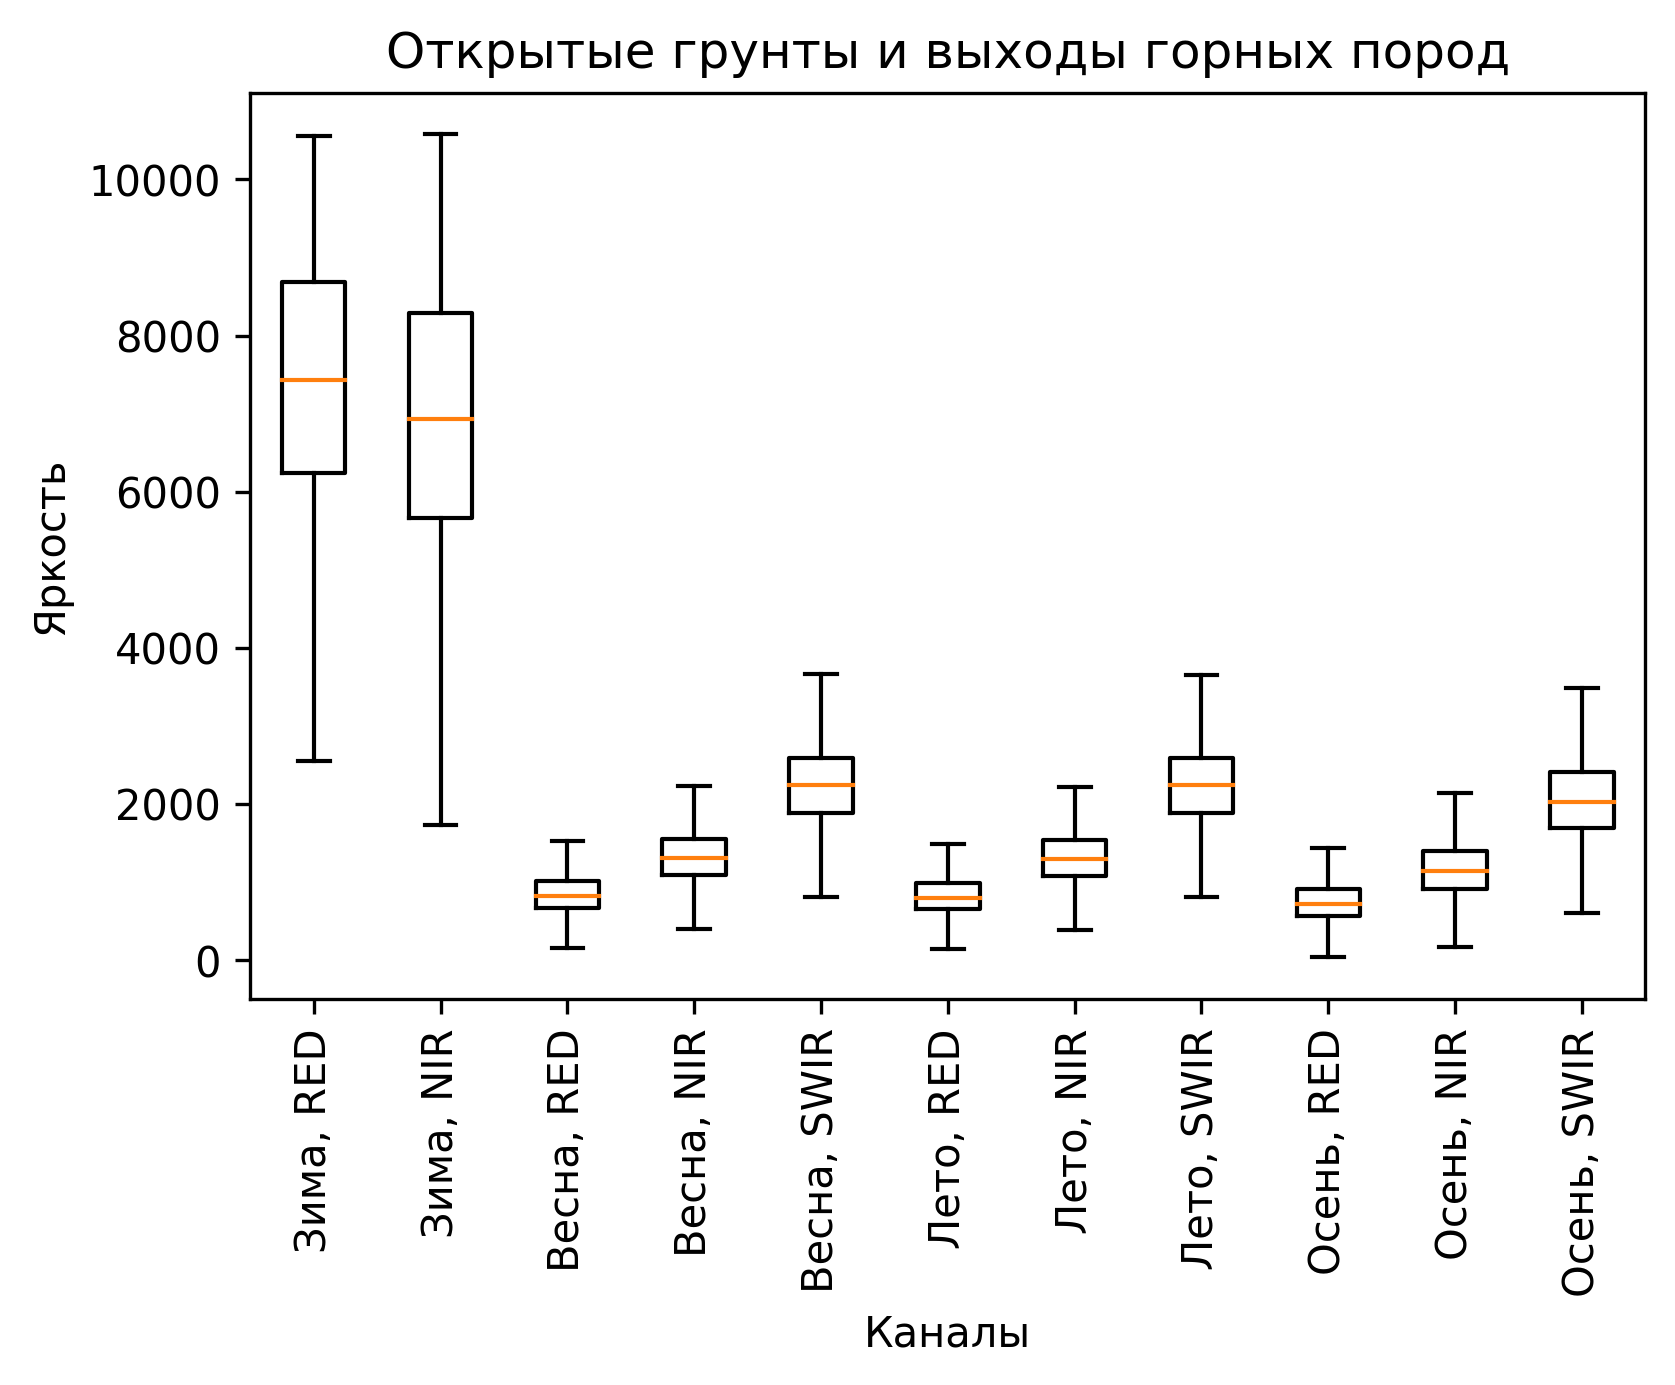

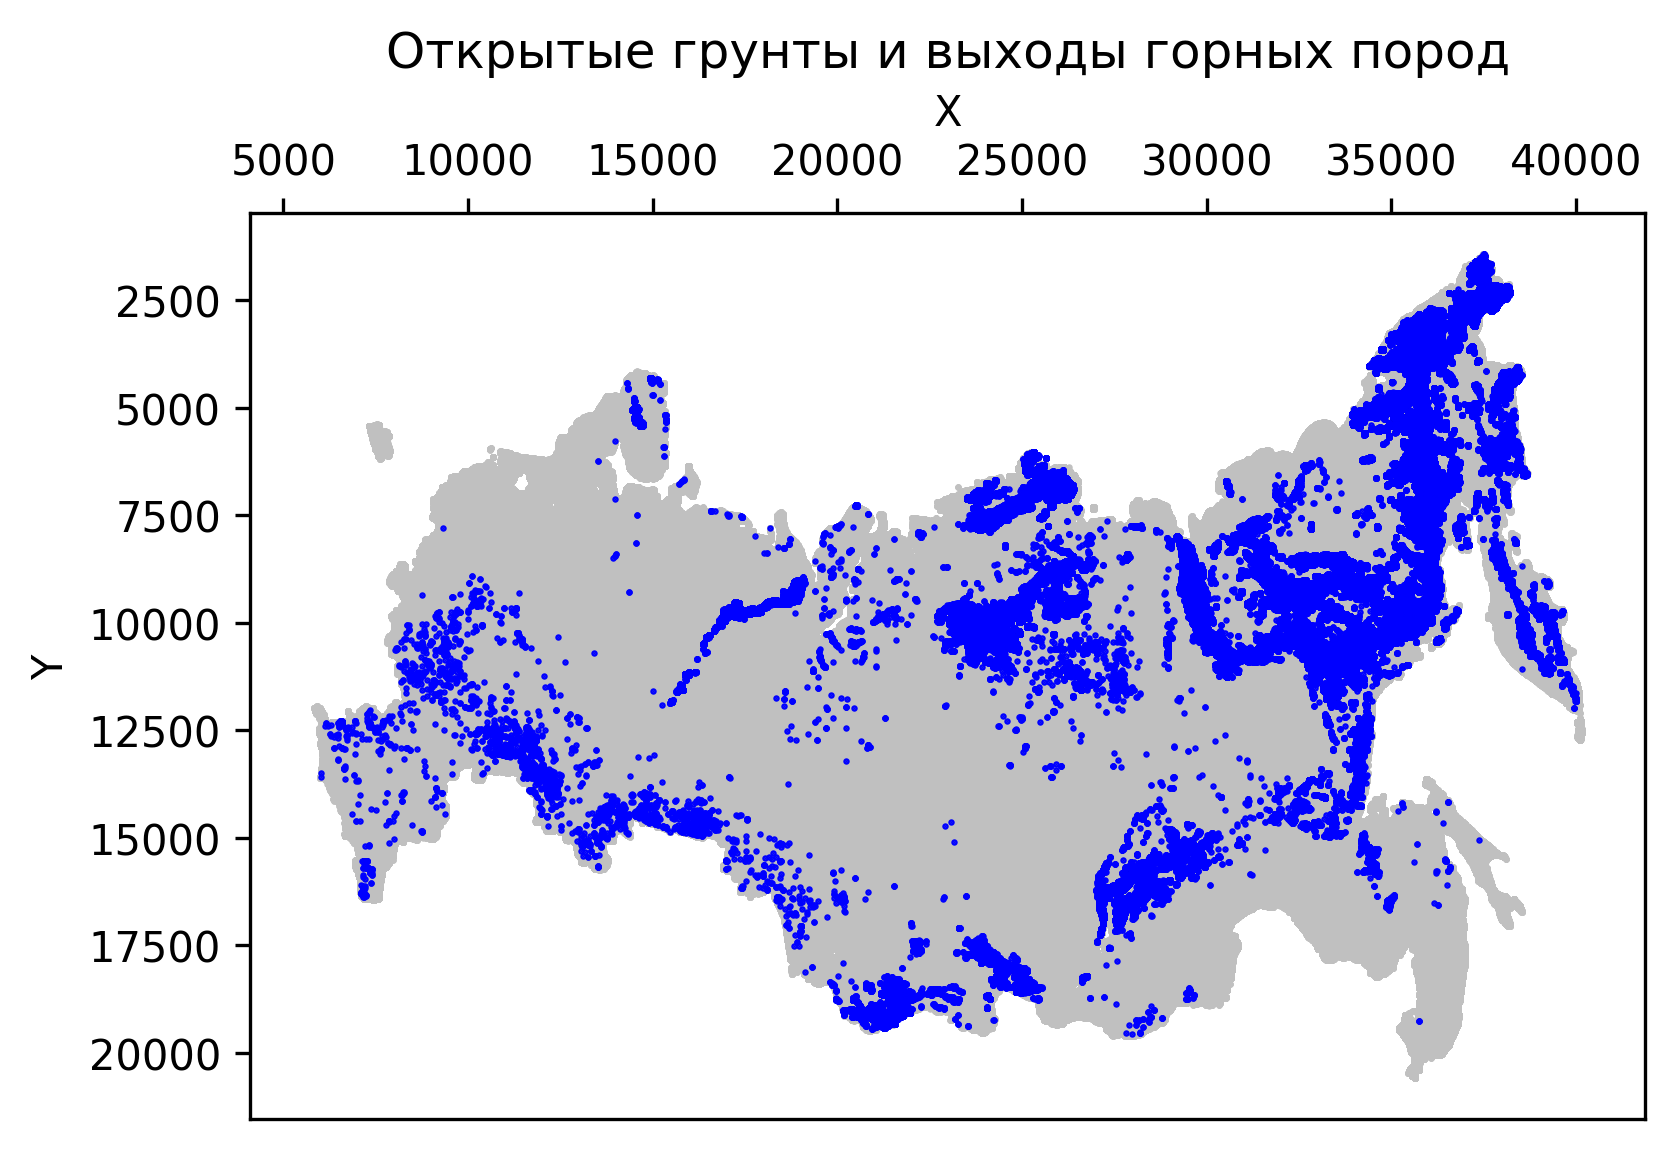

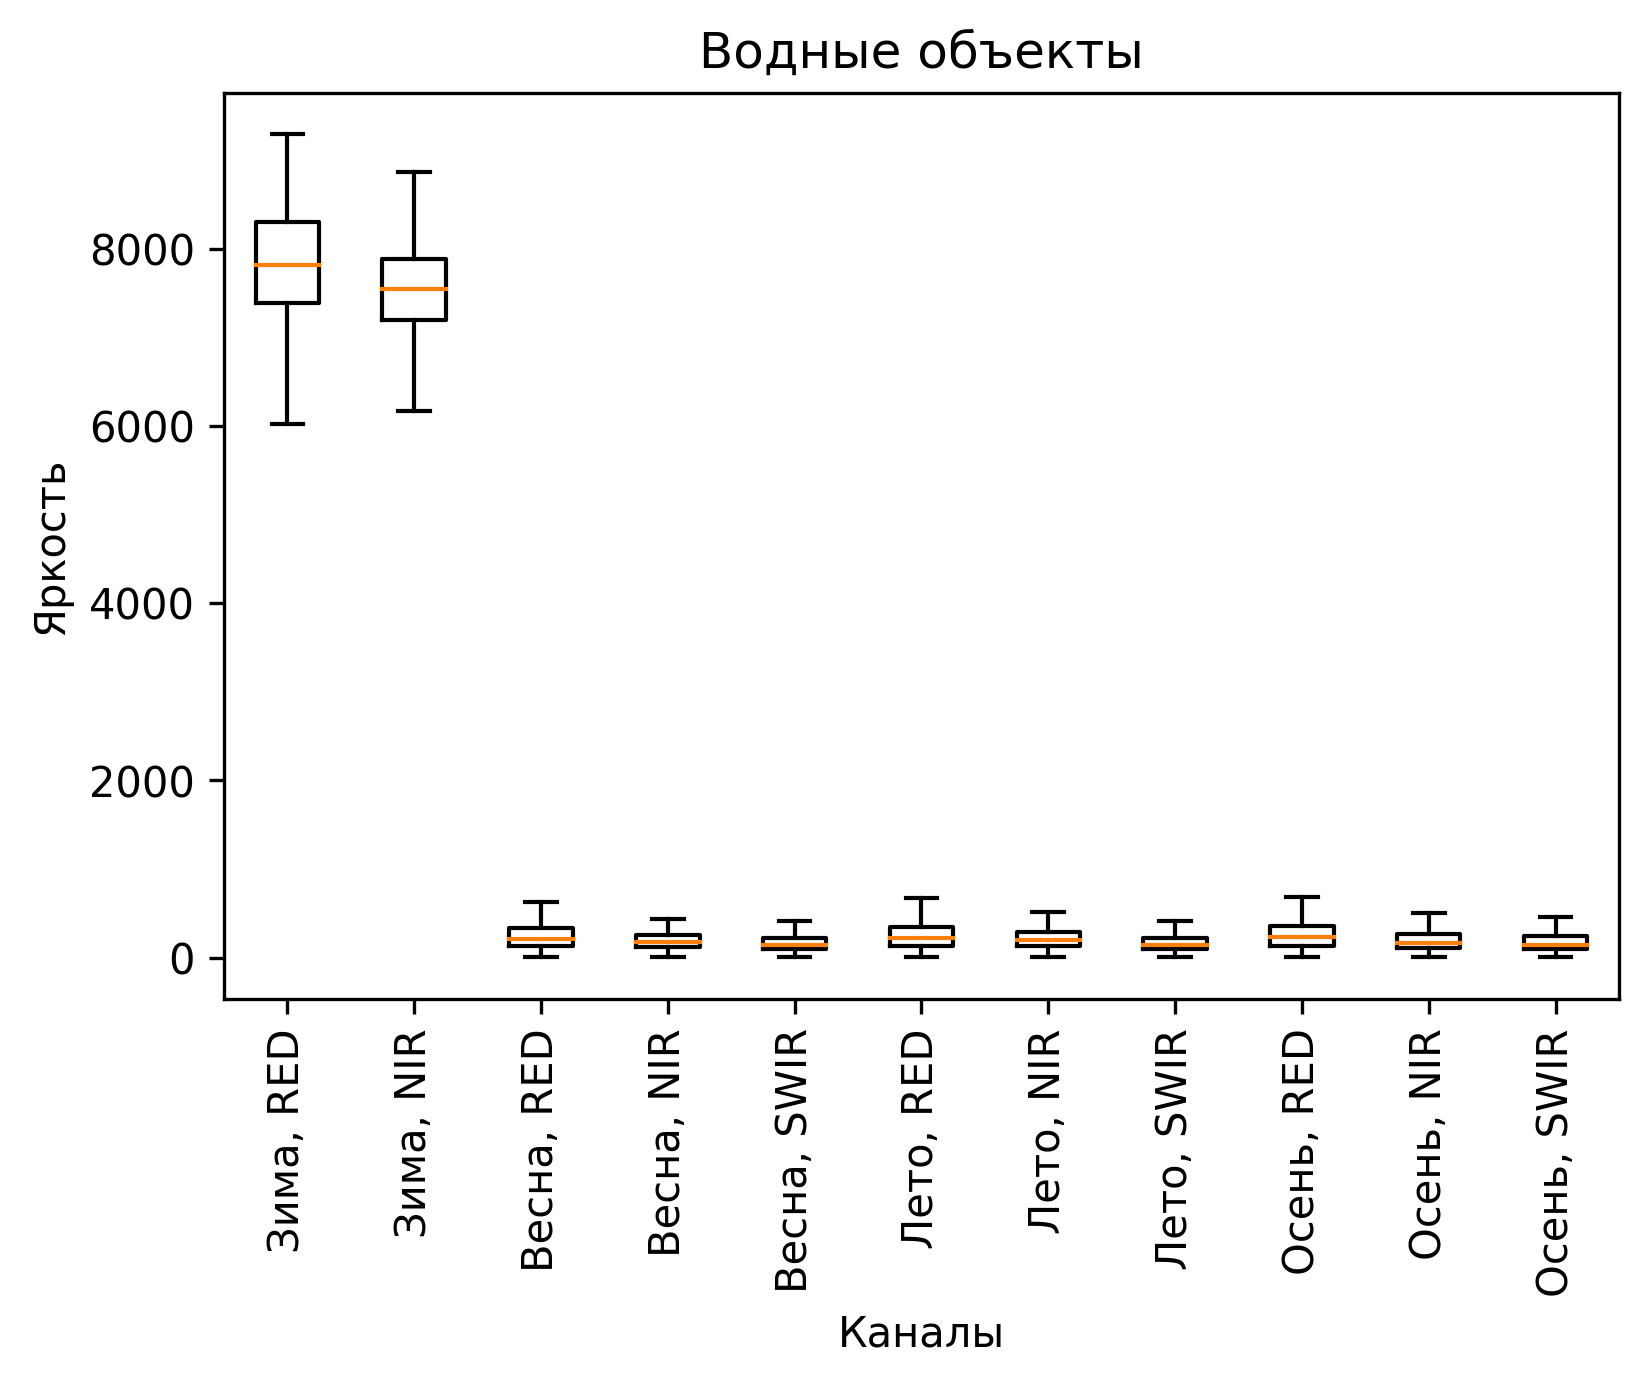

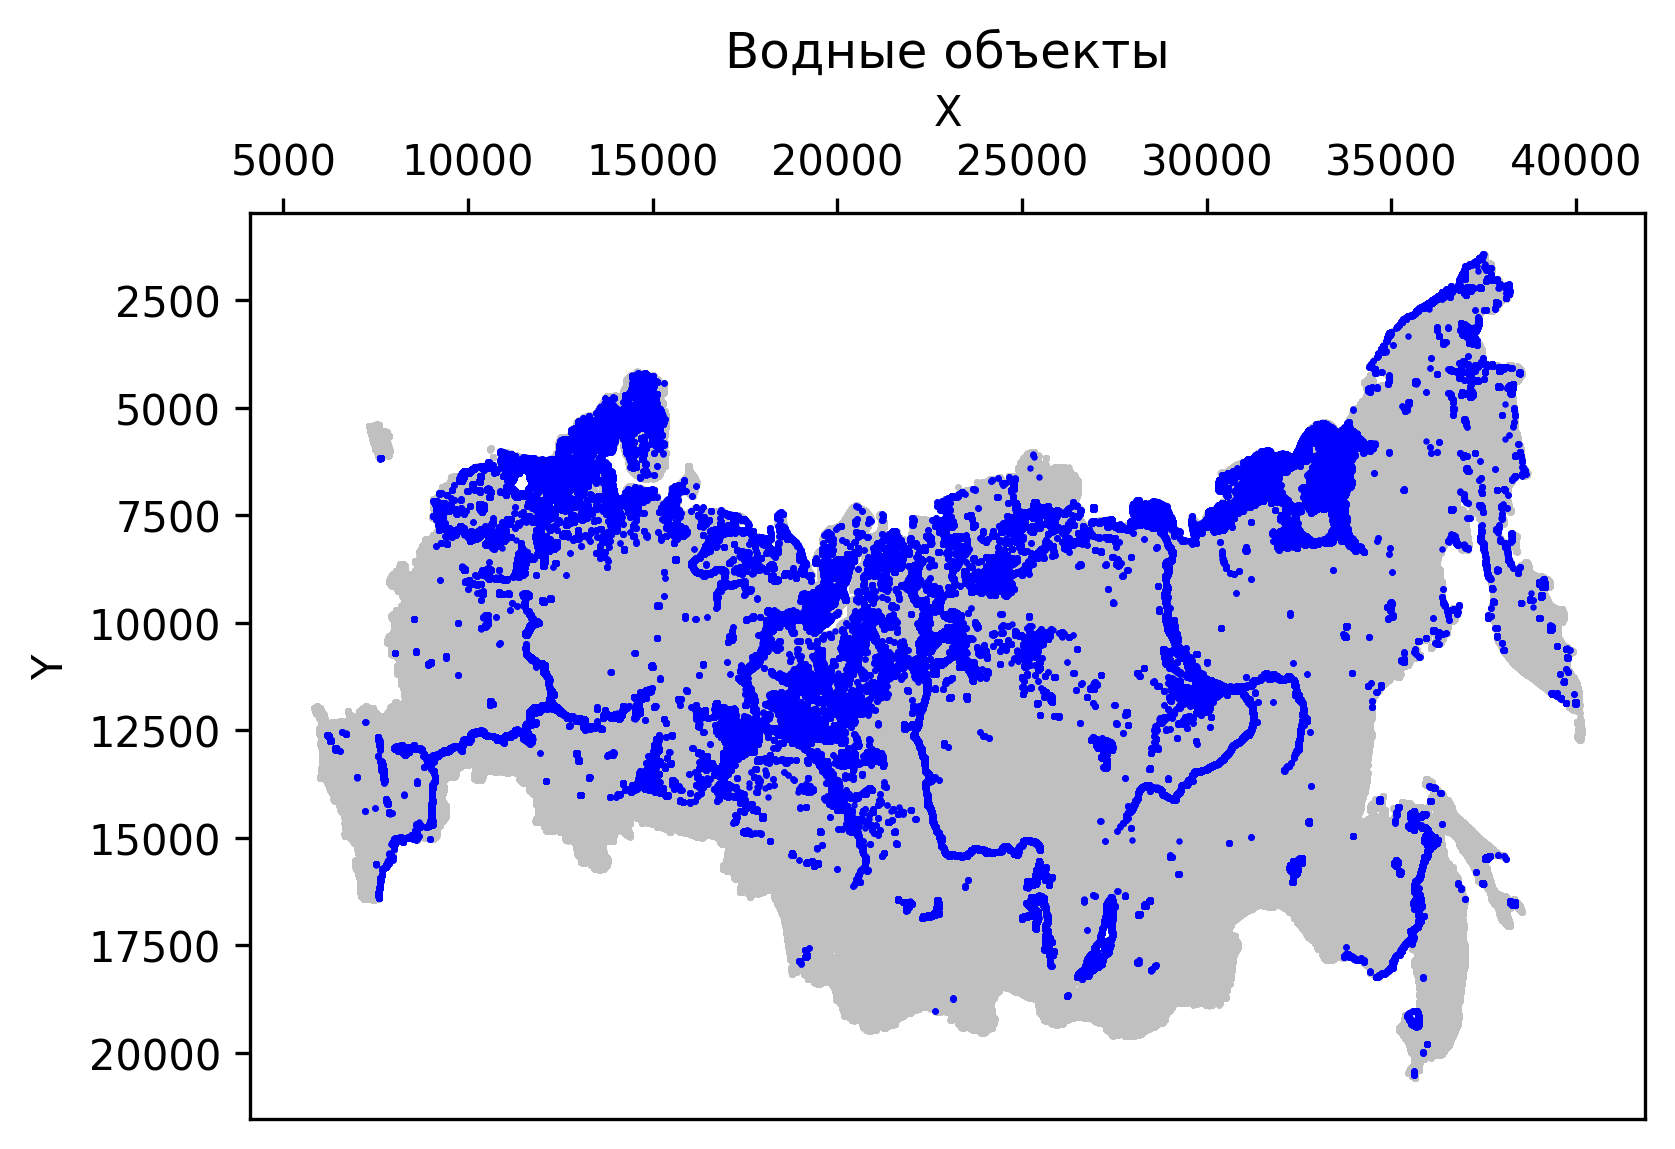

CPU times: total: 1h 10min 44s
Wall time: 3h 22min 48s


In [129]:
%%time

for class_name in classes_names[7:]:
    render_class_boxplot(class_name)
    render_class_map(class_name)